In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

# Under the Hood: Training a Digit Classifier

## Pixels: The Foundations of Computer Vision

## Sidebar: Tenacity and Deep Learning

## End sidebar

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)

In [4]:
#hide
Path.BASE_PATH = path

In [5]:
path.ls()

(#3) [Path('labels.csv'),Path('train'),Path('valid')]

In [6]:
(path/'train').ls()

(#2) [Path('train/3'),Path('train/7')]

In [7]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [8]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [9]:
type(im3)

PIL.PngImagePlugin.PngImageFile

In [10]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [11]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [12]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


## First Try: Pixel Similarity

In [13]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]  # list comprehension
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

In [15]:
three_tensors[1].shape

torch.Size([28, 28])

In [16]:
type(three_tensors)

list

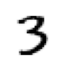

In [14]:
show_image(three_tensors[1]);

In [17]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [18]:
len(stacked_threes.shape)

3

In [19]:
stacked_threes.ndim

3

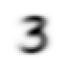

In [20]:
mean3 = stacked_threes.mean(0)  #mean across first axis, in this case across images
show_image(mean3);

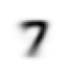

In [21]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

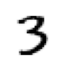

In [22]:
a_3 = stacked_threes[1]
show_image(a_3);

In [23]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [24]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In [25]:
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

### NumPy Arrays and PyTorch Tensors

In [26]:
data = [[1,2,3],[4,5,6]]
arr = array (data)
tns = tensor(data)

In [27]:
arr  # numpy

array([[1, 2, 3],
       [4, 5, 6]])

In [28]:
tns  # pytorch

tensor([[1, 2, 3],
        [4, 5, 6]])

In [29]:
tns[1] #0 based

tensor([4, 5, 6])

In [30]:
tns[:,1]

tensor([2, 5])

In [37]:
tns[1,1:3]

tensor([5, 6])

In [32]:
tns+1

tensor([[2, 3, 4],
        [5, 6, 7]])

In [33]:
tns.type()

'torch.LongTensor'

In [34]:
tns*1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

## Computing Metrics Using Broadcasting

In [38]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [39]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2)) # takes the mean over the last (-1) and second to last (-2) dims
mnist_distance(a_3, mean3)

tensor(0.1114)

In [175]:
valid_3_dist = mnist_distance(valid_3_tens, mean3) #broadcasting, here we could pass in an array(above) or a rank 3 tensor. 
#if it is a rank 3 tensor it will perform on the GPU, pretends to copy, without allocating memory

valid_3_dist, valid_3_dist.shape

(tensor([0.1280, 0.1623, 0.1242,  ..., 0.1508, 0.1263, 0.1260]),
 torch.Size([1010]))

In [41]:
tensor([1,2,3]) + tensor([1,1,1])

tensor([2, 3, 4])

In [42]:
(valid_3_tens-mean3).shape

torch.Size([1010, 28, 28])

In [43]:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7) #basically the classifier

In [44]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [45]:
is_3(valid_3_tens)

tensor([ True,  True,  True,  ..., False,  True,  True])

In [46]:
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

## Stochastic Gradient Descent (SGD)

In [ ]:
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

In [146]:
def f(x): return x**2

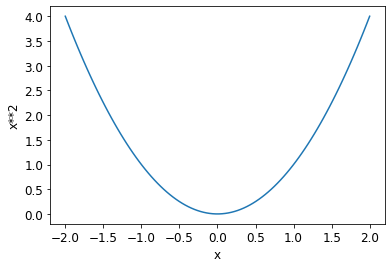

In [147]:
plot_function(f, 'x', 'x**2')

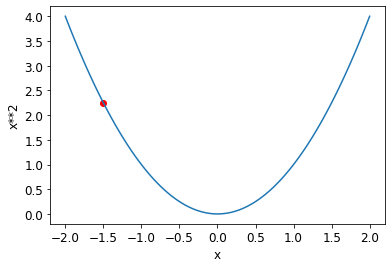

In [148]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red');

### Calculating Gradients

In [178]:
xt = tensor(3.).requires_grad_() #remembers calculation so we can calculate derivative later, and the "_" at the end rememebers.
# it is really the gradient at the specific value, in this example 3.  So it is a value not a function

In [150]:
yt = f(xt)  # below see the result 9, and the memory that the power of "xt" was taken
yt

tensor(9., grad_fn=<PowBackward0>)

In [151]:
yt.backward()  #back propagation, calculate the gradient.  after this look in to xt to find its gradient

In [181]:
xt.grad
xt

tensor(3., requires_grad=True)

In [153]:
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [154]:
def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [155]:
yt.backward()
xt.grad  #vector calculus

tensor([ 6.,  8., 20.])

### Stepping With a Learning Rate

### An End-to-End SGD Example

In [182]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

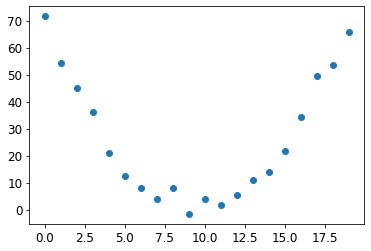

In [183]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

In [184]:
def f(t, params):  #model
    a,b,c = params
    return a*(t**2) + (b*t) + c

In [192]:
def mse(preds, targets): return ((preds-targets)**2).mean() #.sqrt() #loss function

#### Step 1: Initialize the parameters

In [193]:
params
params = torch.randn(3).requires_grad_()
params

tensor([-1.1929, -0.9351,  0.2138], requires_grad=True)

In [194]:
#hide
orig_params = params.clone()  #save for comparison
orig_params

tensor([-1.1929, -0.9351,  0.2138], grad_fn=<CloneBackward>)

#### Step 2: Calculate the predictions

In [195]:
preds = f(time, params)
preds

tensor([ 2.1380e-01, -1.9142e+00, -6.4279e+00, -1.3327e+01, -2.2613e+01, -3.4284e+01, -4.8341e+01, -6.4783e+01, -8.3612e+01, -1.0483e+02, -1.2843e+02, -1.5441e+02, -1.8278e+02, -2.1354e+02,
        -2.4668e+02, -2.8221e+02, -3.2013e+02, -3.6043e+02, -4.0311e+02, -4.4819e+02], grad_fn=<AddBackward0>)

In [196]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

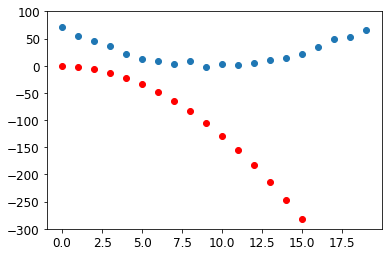

In [197]:
show_preds(preds)

#### Step 3: Calculate the loss

In [198]:
loss = mse(preds, speed)
loss

tensor(54944.5859, grad_fn=<MeanBackward0>)

#### Step 4: Calculate the gradients

In [199]:
loss.backward()
params.grad

tensor([-78159.2734,  -5024.9819,   -363.9268])

In [201]:
params.grad * 1e-5  #learning rate

tensor([-0.7816, -0.0502, -0.0036])

In [202]:
params

tensor([-1.1929, -0.9351,  0.2138], requires_grad=True)

#### Step 5: Step the weights. 

In [203]:
lr = 1e-5
params.data -= lr * params.grad.data  #stepping the weights do not calcualte the gradient by calling ".data"
params.grad = None  #delte previous gradient

In [204]:
preds = f(time,params)
mse(preds, speed)

tensor(10931.1074, grad_fn=<MeanBackward0>)

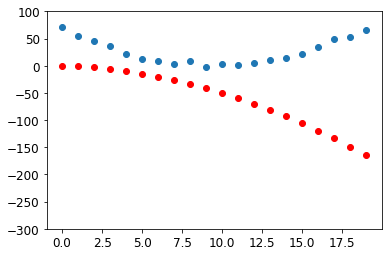

In [205]:
show_preds(preds)

In [206]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

#### Step 6: Repeat the process 

In [216]:
for i in range(100000): apply_step(params)

653.2578125
653.2532958984375
653.2488403320312
653.2443237304688
653.23974609375
653.2351684570312
653.2308349609375
653.2261962890625
653.2217407226562
653.21728515625
653.2127685546875
653.2083129882812
653.2037963867188
653.1993408203125
653.1947631835938
653.1903686523438
653.1859130859375
653.1813354492188
653.1768188476562
653.1724243164062
653.1679077148438
653.1634521484375
653.1588745117188
653.1544799804688
653.1500244140625
653.1455078125
653.1409912109375
653.136474609375
653.1319580078125
653.12744140625
653.1229248046875
653.1185302734375
653.1140747070312
653.1094970703125
653.10498046875
653.1005249023438
653.0960693359375
653.091552734375
653.0870971679688
653.0826416015625
653.0782470703125
653.0736694335938
653.0692138671875
653.064697265625
653.0602416992188
653.0557861328125
653.05126953125
653.0467529296875
653.0423583984375
653.0377807617188
653.0332641601562
653.0289306640625
653.0243530273438
653.0198364257812
653.0154418945312
653.010986328125
653.00640869140

650.8057250976562
650.8013916015625
650.797119140625
650.7928466796875
650.78857421875
650.7842407226562
650.7799072265625
650.7756958007812
650.7713623046875
650.7670288085938
650.7628173828125
650.7584838867188
650.754150390625
650.7498779296875
650.74560546875
650.7412719726562
650.7369995117188
650.7327270507812
650.7283935546875
650.72412109375
650.7197875976562
650.7155151367188
650.7112426757812
650.7069702148438
650.70263671875
650.6983642578125
650.6940307617188
650.6898193359375
650.6854248046875
650.68115234375
650.6768798828125
650.6726684570312
650.6683349609375
650.6640625
650.6597900390625
650.655517578125
650.6511840820312
650.64697265625
650.6427001953125
650.6383666992188
650.6341552734375
650.6298217773438
650.6256103515625
650.621337890625
650.616943359375
650.6127319335938
650.6083374023438
650.6041870117188
650.5999145507812
650.5956420898438
650.59130859375
650.5870361328125
650.5827026367188
650.5784912109375
650.57421875
650.5699462890625
650.5656127929688
650.

648.734375
648.7302856445312
648.7261962890625
648.7220458984375
648.7178344726562
648.7136840820312
648.7095947265625
648.7054443359375
648.7012939453125
648.6972045898438
648.6929931640625
648.6888427734375
648.6847534179688
648.6806030273438
648.6764526367188
648.6723022460938
648.6681518554688
648.6640625
648.659912109375
648.65576171875
648.6516723632812
648.6474609375
648.6432495117188
648.63916015625
648.6350708007812
648.6309204101562
648.6268310546875
648.6226806640625
648.6185913085938
648.6144409179688
648.6102294921875
648.6061401367188
648.6019897460938
648.5978393554688
648.59375
648.589599609375
648.5853881835938
648.581298828125
648.5770874023438
648.572998046875
648.5689086914062
648.564697265625
648.560546875
648.5565185546875
648.5523681640625
648.54833984375
648.5440673828125
648.5399780273438
648.5358276367188
648.53173828125
648.527587890625
648.5234985351562
648.5194091796875
648.51513671875
648.5111083984375
648.5069580078125
648.5029296875
648.4986572265625
648

646.464111328125
646.460205078125
646.4561767578125
646.4520874023438
646.4481201171875
646.444091796875
646.4400634765625
646.4361572265625
646.4320678710938
646.4281616210938
646.4241333007812
646.4201049804688
646.4161376953125
646.4121704101562
646.4080810546875
646.4041748046875
646.4002075195312
646.3961181640625
646.3922119140625
646.3882446289062
646.3841552734375
646.3802490234375
646.3762817382812
646.3722534179688
646.3682250976562
646.3642578125
646.3602294921875
646.3563232421875
646.352294921875
646.3482666015625
646.3442993164062
646.34033203125
646.3363647460938
646.332275390625
646.328369140625
646.3243408203125
646.3203735351562
646.3163452148438
646.3123779296875
646.308349609375
646.3043823242188
646.3004760742188
646.2965087890625
646.29248046875
646.2884521484375
646.2844848632812
646.2805786132812
646.2764892578125
646.2725219726562
646.2686157226562
646.2645874023438
646.2606201171875
646.2566528320312
646.2525634765625
646.2486572265625
646.2445678710938
646.24

644.2462158203125
644.2423095703125
644.2384643554688
644.2347412109375
644.2308349609375
644.2269287109375
644.2230224609375
644.2191162109375
644.2152709960938
644.2113647460938
644.2074584960938
644.2037353515625
644.1998291015625
644.1959228515625
644.1920776367188
644.1881713867188
644.184326171875
644.1805419921875
644.1766357421875
644.1727294921875
644.1688232421875
644.1649780273438
644.1610717773438
644.1572265625
644.1534423828125
644.1495361328125
644.1456909179688
644.1417846679688
644.137939453125
644.134033203125
644.1301879882812
644.12646484375
644.1224365234375
644.1185913085938
644.1146850585938
644.1109008789062
644.1070556640625
644.1031494140625
644.0993041992188
644.0953369140625
644.091552734375
644.0877075195312
644.0838623046875
644.0799560546875
644.0760498046875
644.072265625
644.0684814453125
644.0645751953125
644.0607299804688
644.0568237304688
644.0529174804688
644.0491333007812
644.0452880859375
644.0413818359375
644.0374755859375
644.03369140625
644.029

642.3201293945312
642.3162841796875
642.3125610351562
642.3087158203125
642.3048706054688
642.3012084960938
642.2974243164062
642.2936401367188
642.2899169921875
642.2860717773438
642.2822875976562
642.2784423828125
642.2747802734375
642.27099609375
642.2672119140625
642.263427734375
642.2596435546875
642.2559204101562
642.2521362304688
642.2484130859375
642.2445068359375
642.2408447265625
642.2369995117188
642.2332153320312
642.2294921875
642.2257080078125
642.2219848632812
642.2182006835938
642.2144775390625
642.210693359375
642.206787109375
642.2030639648438
642.1992797851562
642.195556640625
642.1917724609375
642.1880493164062
642.184326171875
642.1805419921875
642.1766967773438
642.1729736328125
642.169189453125
642.1654052734375
642.1617431640625
642.1578369140625
642.1541748046875
642.1503295898438
642.1466064453125
642.1428833007812
642.1390991210938
642.1353759765625
642.131591796875
642.1278076171875
642.1240234375
642.1202392578125
642.1165161132812
642.1127319335938
642.109

640.4057006835938
640.4020385742188
640.3983764648438
640.3946533203125
640.3909912109375
640.3873291015625
640.3836669921875
640.3800048828125
640.3762817382812
640.37255859375
640.3687744140625
640.3651733398438
640.3615112304688
640.3577880859375
640.3541259765625
640.3504638671875
640.3468017578125
640.3430786132812
640.3394165039062
640.3358154296875
640.3319702148438
640.328369140625
640.3245849609375
640.3208618164062
640.3172607421875
640.3134765625
640.309814453125
640.3060302734375
640.3023681640625
640.2987060546875
640.2951049804688
640.2913818359375
640.2877197265625
640.2841186523438
640.2803955078125
640.2766723632812
640.2730712890625
640.269287109375
640.2655639648438
640.261962890625
640.2581787109375
640.2545166015625
640.2507934570312
640.2471923828125
640.2435302734375
640.2398071289062
640.2362060546875
640.2325439453125
640.228759765625
640.22509765625
640.2213745117188
640.2176513671875
640.2140502929688
640.2103881835938
640.2067260742188
640.2030029296875
640.

638.5969848632812
638.5933227539062
638.5897216796875
638.5861206054688
638.5824584960938
638.5789184570312
638.5752563476562
638.5715942382812
638.5679931640625
638.5643920898438
638.5606689453125
638.55712890625
638.5535278320312
638.5497436523438
638.5462646484375
638.5426025390625
638.5389404296875
638.5354614257812
638.5317993164062
638.5281372070312
638.5245361328125
638.5209350585938
638.5173950195312
638.5137939453125
638.5101318359375
638.5064086914062
638.5028686523438
638.4991455078125
638.4955444335938
638.4920043945312
638.4884033203125
638.4847412109375
638.481201171875
638.4775390625
638.4739990234375
638.4703369140625
638.4666748046875
638.463134765625
638.4595947265625
638.4558715820312
638.4522705078125
638.4486083984375
638.4449462890625
638.4413452148438
638.4378051757812
638.4341430664062
638.4305419921875
638.4268798828125
638.4232788085938
638.4197998046875
638.4161376953125
638.4124755859375
638.4088745117188
638.4052734375
638.4017333984375
638.3980712890625
63

636.7212524414062
636.7176513671875
636.7140502929688
636.7105712890625
636.7069702148438
636.7034912109375
636.6998291015625
636.6962890625
636.6927490234375
636.6891479492188
636.6856689453125
636.68212890625
636.6785278320312
636.6749877929688
636.6713256835938
636.6679077148438
636.664306640625
636.6607666015625
636.6572265625
636.6536865234375
636.650146484375
636.6466064453125
636.6430053710938
636.6393432617188
636.6358642578125
636.63232421875
636.6287841796875
636.6251831054688
636.6217041015625
636.6182250976562
636.6146240234375
636.6110229492188
636.6074829101562
636.6038818359375
636.6004028320312
636.5968627929688
636.59326171875
636.5897216796875
636.5861206054688
636.5827026367188
636.5789794921875
636.5755615234375
636.5719604492188
636.5684204101562
636.5648803710938
636.5613403320312
636.557861328125
636.5541381835938
636.5507202148438
636.5471801757812
636.5435791015625
636.5401000976562
636.5364379882812
636.5330200195312
636.5293579101562
636.5257568359375
636.522

634.8875122070312
634.8839111328125
634.8804931640625
634.876953125
634.8735961914062
634.8699951171875
634.8665161132812
634.8629150390625
634.8594970703125
634.8560180664062
634.8524780273438
634.8489990234375
634.8455200195312
634.8419189453125
634.8385009765625
634.8350830078125
634.83154296875
634.8280029296875
634.824462890625
634.8209838867188
634.8175659179688
634.8140258789062
634.810546875
634.8070068359375
634.8035278320312
634.7999877929688
634.7965087890625
634.7930908203125
634.7894897460938
634.7860107421875
634.7825927734375
634.7789916992188
634.775634765625
634.77197265625
634.7685546875
634.7650756835938
634.7615356445312
634.758056640625
634.7545166015625
634.7510986328125
634.74755859375
634.744140625
634.7405395507812
634.7371826171875
634.7335205078125
634.7301025390625
634.7266845703125
634.7230834960938
634.7196044921875
634.7161865234375
634.712646484375
634.7091674804688
634.7056884765625
634.7022705078125
634.6986083984375
634.6951904296875
634.691650390625


633.0462646484375
633.04296875
633.03955078125
633.0360107421875
633.0325317382812
633.029052734375
633.0256958007812
633.022216796875
633.0186767578125
633.0153198242188
633.0118408203125
633.0084228515625
633.0050048828125
633.0015258789062
632.9981079101562
632.9945068359375
632.9910888671875
632.9876708984375
632.9842529296875
632.9808959960938
632.9773559570312
632.9739990234375
632.9705200195312
632.9671020507812
632.9635620117188
632.9601440429688
632.9567260742188
632.9532470703125
632.9497680664062
632.9463500976562
632.9429321289062
632.939453125
632.9359130859375
632.9324951171875
632.92919921875
632.9256591796875
632.9221801757812
632.9187622070312
632.915283203125
632.9119262695312
632.9083251953125
632.9049682617188
632.9014892578125
632.8980712890625
632.8946533203125
632.8912353515625
632.8876953125
632.8842163085938
632.880859375
632.8773193359375
632.8739624023438
632.87060546875
632.8670654296875
632.8635864257812
632.8602294921875
632.8568115234375
632.8532104492188

631.3217163085938
631.3182373046875
631.3148803710938
631.3114624023438
631.3081665039062
631.3047485351562
631.3013305664062
631.2978515625
631.2944946289062
631.2911376953125
631.2877197265625
631.2843017578125
631.2808837890625
631.2774047851562
631.2740478515625
631.2706298828125
631.2672119140625
631.2637939453125
631.2603149414062
631.2570190429688
631.2535400390625
631.2501220703125
631.2467041015625
631.2432861328125
631.2398681640625
631.2365112304688
631.233154296875
631.229736328125
631.226318359375
631.222900390625
631.219482421875
631.2161254882812
631.212646484375
631.2093505859375
631.2058715820312
631.202392578125
631.1990966796875
631.1956787109375
631.1922607421875
631.1888427734375
631.1854248046875
631.1820068359375
631.1785888671875
631.1752319335938
631.171875
631.1683349609375
631.1650390625
631.1614990234375
631.1581420898438
631.15478515625
631.1514282226562
631.1480102539062
631.1444091796875
631.1412353515625
631.1378173828125
631.1343994140625
631.1309814453

629.2964477539062
629.2930297851562
629.2896728515625
629.2862548828125
629.2828979492188
629.279541015625
629.2762451171875
629.2727661132812
629.2694702148438
629.2660522460938
629.2627563476562
629.2593994140625
629.2560424804688
629.2526245117188
629.2493286132812
629.2459106445312
629.24267578125
629.2391357421875
629.23583984375
629.2323608398438
629.2290649414062
629.2256469726562
629.2223510742188
629.2189331054688
629.215576171875
629.2122192382812
629.2088623046875
629.2055053710938
629.2021484375
629.1987915039062
629.1953735351562
629.1920776367188
629.188720703125
629.185302734375
629.1819458007812
629.1785888671875
629.17529296875
629.1719360351562
629.1685791015625
629.1652221679688
629.1617431640625
629.1585083007812
629.1551513671875
629.1517333984375
629.1483154296875
629.14501953125
629.1415405273438
629.1383056640625
629.1348876953125
629.1315307617188
629.128173828125
629.1248779296875
629.1213989257812
629.1180419921875
629.1146240234375
629.111328125
629.10803222

627.561279296875
627.557861328125
627.5545654296875
627.5512084960938
627.5479736328125
627.5445556640625
627.541259765625
627.5379028320312
627.5346069335938
627.5311889648438
627.5278930664062
627.5245971679688
627.521240234375
627.5178833007812
627.5145874023438
627.51123046875
627.5078735351562
627.5045776367188
627.501220703125
627.4979248046875
627.4945678710938
627.4912719726562
627.4879150390625
627.4845581054688
627.4813232421875
627.4779052734375
627.4745483398438
627.4713134765625
627.4678955078125
627.4644775390625
627.4612426757812
627.4578857421875
627.45458984375
627.4512939453125
627.447998046875
627.444580078125
627.4412841796875
627.4378662109375
627.4346923828125
627.4312744140625
627.4279174804688
627.424560546875
627.4212646484375
627.4180297851562
627.4146728515625
627.4113159179688
627.4080200195312
627.4046020507812
627.4013671875
627.39794921875
627.3945922851562
627.3912963867188
627.3878784179688
627.3846435546875
627.38134765625
627.3779296875
627.3746337890

625.7030639648438
625.6997680664062
625.6964721679688
625.693115234375
625.6898193359375
625.6864624023438
625.6832275390625
625.679931640625
625.6766357421875
625.6734008789062
625.6700439453125
625.6668090820312
625.6634521484375
625.6602172851562
625.6567993164062
625.6535034179688
625.650146484375
625.6468505859375
625.6436767578125
625.6402587890625
625.6370849609375
625.6337280273438
625.6304931640625
625.6271362304688
625.6239013671875
625.6204833984375
625.6171875
625.6139526367188
625.6105346679688
625.6073608398438
625.6039428710938
625.6007080078125
625.5972900390625
625.5941162109375
625.5908203125
625.5875244140625
625.5841064453125
625.5809326171875
625.5775146484375
625.5743408203125
625.5709838867188
625.5676879882812
625.5643920898438
625.56103515625
625.5577392578125
625.5545043945312
625.5512084960938
625.5477905273438
625.5445556640625
625.5413208007812
625.5379638671875
625.5346069335938
625.5313720703125
625.5279541015625
625.5247802734375
625.521484375
625.518127

624.0806274414062
624.077392578125
624.0740966796875
624.0708618164062
624.0675048828125
624.0642700195312
624.0609741210938
624.0577392578125
624.0543823242188
624.0511474609375
624.0479125976562
624.0445556640625
624.0413208007812
624.0379638671875
624.0347900390625
624.0315551757812
624.0281982421875
624.0249633789062
624.0216674804688
624.0184326171875
624.0150756835938
624.0117797851562
624.008544921875
624.0052490234375
624.0020141601562
623.9987182617188
623.9954223632812
623.9921264648438
623.9888916015625
623.9855346679688
623.9822998046875
623.97900390625
623.9757080078125
623.9724731445312
623.96923828125
623.9658813476562
623.9625854492188
623.9593505859375
623.9561157226562
623.9527587890625
623.9495849609375
623.9462890625
623.9429321289062
623.939697265625
623.9364013671875
623.93310546875
623.9298095703125
623.9266357421875
623.9232177734375
623.9199829101562
623.9166870117188
623.9134521484375
623.91015625
623.906982421875
623.9036254882812
623.900390625
623.8970336914

622.4075927734375
622.4044189453125
622.401123046875
622.3980102539062
622.3946533203125
622.391357421875
622.3880615234375
622.3848876953125
622.381591796875
622.37841796875
622.3751220703125
622.3718872070312
622.3685302734375
622.3652954101562
622.362060546875
622.3588256835938
622.35546875
622.352294921875
622.3489990234375
622.3457641601562
622.342529296875
622.3391723632812
622.3360595703125
622.332763671875
622.3294677734375
622.3262939453125
622.3229370117188
622.3197021484375
622.3165283203125
622.313232421875
622.3099365234375
622.3067626953125
622.303466796875
622.3001708984375
622.2969970703125
622.293701171875
622.2904052734375
622.2871704101562
622.283935546875
622.2806396484375
622.27734375
622.274169921875
622.2708740234375
622.2677001953125
622.2643432617188
622.2611083984375
622.2579345703125
622.254638671875
622.2513427734375
622.248046875
622.2447509765625
622.2415771484375
622.2383422851562
622.235107421875
622.2317504882812
622.2285766601562
622.2252807617188
622.

620.7877197265625
620.7844848632812
620.78125
620.7780151367188
620.7747802734375
620.7715454101562
620.7681884765625
620.76513671875
620.7617797851562
620.758544921875
620.7552490234375
620.7520751953125
620.7489013671875
620.7457275390625
620.7423706054688
620.7391967773438
620.7359619140625
620.7327880859375
620.7294921875
620.726318359375
620.7230224609375
620.7197265625
620.7164916992188
620.7132568359375
620.7100830078125
620.7067260742188
620.70361328125
620.7003173828125
620.6972045898438
620.69384765625
620.690673828125
620.6874389648438
620.6842041015625
620.6809692382812
620.677734375
620.6744995117188
620.6712646484375
620.6680297851562
620.6646728515625
620.6615600585938
620.6582641601562
620.6550903320312
620.6517333984375
620.6486206054688
620.6453857421875
620.6421508789062
620.6387939453125
620.6358032226562
620.6324462890625
620.629150390625
620.6258544921875
620.6226806640625
620.6194458007812
620.6162109375
620.6129150390625
620.6097412109375
620.6065673828125
620.6

619.0613403320312
619.0581665039062
619.0548706054688
619.0516967773438
619.0485229492188
619.0452880859375
619.0421142578125
619.0389404296875
619.0355834960938
619.032470703125
619.0291748046875
619.0260620117188
619.0228271484375
619.0194702148438
619.0164184570312
619.0131225585938
619.0098876953125
619.006591796875
619.0035400390625
619.0003051757812
618.9970092773438
618.9938354492188
618.9906005859375
618.9873657226562
618.9842529296875
618.9810180664062
618.977783203125
618.974609375
618.9713745117188
618.9681396484375
618.9649047851562
618.961669921875
618.9584350585938
618.9552001953125
618.9520874023438
618.9488525390625
618.9456176757812
618.9425048828125
618.9391479492188
618.9359741210938
618.9327392578125
618.9295654296875
618.92626953125
618.9231567382812
618.919921875
618.9166259765625
618.9135131835938
618.9102172851562
618.9071044921875
618.9037475585938
618.9005126953125
618.8973388671875
618.8941650390625
618.8909301757812
618.8877563476562
618.8845825195312
618.88

617.3865966796875
617.3834228515625
617.3801879882812
617.3770751953125
617.3738403320312
617.37060546875
617.3673706054688
617.3641967773438
617.3609619140625
617.3577880859375
617.3546142578125
617.3514404296875
617.3482666015625
617.344970703125
617.341796875
617.338623046875
617.3353271484375
617.3321533203125
617.3289794921875
617.3258056640625
617.3225708007812
617.3194580078125
617.3162231445312
617.3129272460938
617.3096923828125
617.3065185546875
617.3033447265625
617.3001708984375
617.2969970703125
617.2938232421875
617.2906494140625
617.287353515625
617.2841796875
617.2808837890625
617.27783203125
617.2745361328125
617.2714233398438
617.2681884765625
617.2649536132812
617.2618408203125
617.258544921875
617.25537109375
617.252197265625
617.2490234375
617.2457275390625
617.2426147460938
617.2393188476562
617.2362060546875
617.23291015625
617.2297973632812
617.2266845703125
617.223388671875
617.2201538085938
617.2169799804688
617.2137451171875
617.2105712890625
617.207397460937

615.7554931640625
615.7523193359375
615.7491455078125
615.7459716796875
615.74267578125
615.7396240234375
615.7363891601562
615.7332763671875
615.72998046875
615.7268676757812
615.7237548828125
615.7205810546875
615.71728515625
615.714111328125
615.7109375
615.707763671875
615.7045288085938
615.7012939453125
615.6982421875
615.695068359375
615.69189453125
615.6885986328125
615.6854248046875
615.6823120117188
615.6791381835938
615.6759033203125
615.6727294921875
615.6695556640625
615.6664428710938
615.6632080078125
615.6599731445312
615.6568603515625
615.6536865234375
615.6504516601562
615.6473388671875
615.6441040039062
615.6409912109375
615.6377563476562
615.634521484375
615.6314086914062
615.6281127929688
615.6249389648438
615.6217651367188
615.61865234375
615.615478515625
615.6123046875
615.6090698242188
615.60595703125
615.6026611328125
615.5994873046875
615.5963134765625
615.59326171875
615.5899658203125
615.5867919921875
615.5836181640625
615.5804443359375
615.5772705078125
615.5

614.0560302734375
614.0529174804688
614.0497436523438
614.0465087890625
614.0433959960938
614.0402221679688
614.0370483398438
614.0338134765625
614.0306396484375
614.0274658203125
614.0243530273438
614.021240234375
614.0179443359375
614.0147705078125
614.0116577148438
614.008544921875
614.0052490234375
614.0021362304688
613.9989624023438
613.9957275390625
613.9927368164062
613.9894409179688
613.9862060546875
613.9830932617188
613.9800415039062
613.976806640625
613.9736938476562
613.9705200195312
613.9673461914062
613.964111328125
613.9609375
613.9578247070312
613.9546508789062
613.9514770507812
613.9481811523438
613.9451293945312
613.94189453125
613.9387817382812
613.935546875
613.932373046875
613.92919921875
613.9260864257812
613.9229736328125
613.9197387695312
613.9165649414062
613.9133911132812
613.9102172851562
613.9071044921875
613.9039306640625
613.9007568359375
613.8975830078125
613.8944702148438
613.8912353515625
613.8880004882812
613.8848876953125
613.8816528320312
613.8785400

612.3263549804688
612.3233032226562
612.3201293945312
612.31689453125
612.3138427734375
612.310546875
612.3074951171875
612.3043212890625
612.3011474609375
612.2979736328125
612.2948608398438
612.2916870117188
612.28857421875
612.285400390625
612.2822875976562
612.279052734375
612.27587890625
612.2728271484375
612.2696533203125
612.2664794921875
612.2633666992188
612.2601318359375
612.2570190429688
612.2537841796875
612.2507934570312
612.2476806640625
612.2444458007812
612.2413330078125
612.2381591796875
612.23486328125
612.2318115234375
612.2286376953125
612.2254638671875
612.222412109375
612.21923828125
612.2161254882812
612.2130126953125
612.2098388671875
612.2066040039062
612.2034301757812
612.2003173828125
612.1971435546875
612.1939697265625
612.1908569335938
612.187744140625
612.1845092773438
612.1813354492188
612.1781616210938
612.1751098632812
612.1719360351562
612.1688232421875
612.1656494140625
612.1624755859375
612.1593017578125
612.1561279296875
612.1529541015625
612.149841

610.6139526367188
610.6109008789062
610.6077270507812
610.6044921875
610.6014404296875
610.5982666015625
610.5951538085938
610.592041015625
610.5888671875
610.5857543945312
610.5826416015625
610.5794677734375
610.5763549804688
610.5732421875
610.5699462890625
610.56689453125
610.5637817382812
610.5604858398438
610.5574340820312
610.5543212890625
610.5512084960938
610.5479736328125
610.5450439453125
610.5418090820312
610.5386352539062
610.5355224609375
610.5323486328125
610.5292358398438
610.5260620117188
610.52294921875
610.519775390625
610.5166625976562
610.5134887695312
610.5103759765625
610.5072021484375
610.5040893554688
610.5009155273438
610.497802734375
610.4946899414062
610.4915771484375
610.4884033203125
610.4853515625
610.4820556640625
610.47900390625
610.4758911132812
610.47265625
610.4695434570312
610.4663696289062
610.4633178710938
610.4600830078125
610.4569091796875
610.4537963867188
610.4507446289062
610.4475708007812
610.4444580078125
610.4412841796875
610.438232421875
6

609.0086669921875
609.005615234375
609.0023803710938
608.999267578125
608.9962158203125
608.9930419921875
608.9898681640625
608.9868774414062
608.983642578125
608.9805908203125
608.9774169921875
608.974365234375
608.97119140625
608.9680786132812
608.9649047851562
608.9617919921875
608.9586181640625
608.9555053710938
608.952392578125
608.9492797851562
608.9461669921875
608.9430541992188
608.9398193359375
608.936767578125
608.93359375
608.9304809570312
608.9273071289062
608.9241943359375
608.9210815429688
608.91796875
608.9149169921875
608.9117431640625
608.90869140625
608.9054565429688
608.9022827148438
608.8992919921875
608.8961181640625
608.8929443359375
608.8898315429688
608.8865966796875
608.8836059570312
608.8804321289062
608.8773193359375
608.8741455078125
608.87109375
608.867919921875
608.8648681640625
608.8616333007812
608.8585205078125
608.8553466796875
608.852294921875
608.8491821289062
608.8460693359375
608.8428955078125
608.83984375
608.836669921875
608.8336181640625
608.830

607.3345947265625
607.3314819335938
607.3282470703125
607.3252563476562
607.3221435546875
607.3189697265625
607.31591796875
607.3126831054688
607.3096923828125
607.3064575195312
607.3034057617188
607.3002319335938
607.2972412109375
607.2940673828125
607.2909545898438
607.2879028320312
607.2847290039062
607.2815551757812
607.2785034179688
607.275390625
607.2723388671875
607.2691650390625
607.26611328125
607.2628784179688
607.2598266601562
607.2566528320312
607.2535400390625
607.2505493164062
607.247314453125
607.2442626953125
607.2410888671875
607.2379760742188
607.23486328125
607.231689453125
607.2286376953125
607.2254638671875
607.2223510742188
607.2191772460938
607.2161865234375
607.2130126953125
607.2099609375
607.2068481445312
607.2037353515625
607.20068359375
607.1974487304688
607.1944580078125
607.1912841796875
607.1881713867188
607.1849975585938
607.1819458007812
607.1787719726562
607.1756591796875
607.1724853515625
607.1693725585938
607.1663208007812
607.1632080078125
607.16003

605.7877197265625
605.78466796875
605.781494140625
605.7784423828125
605.7752685546875
605.772216796875
605.76904296875
605.7659912109375
605.762939453125
605.7598876953125
605.7567138671875
605.7535400390625
605.75048828125
605.7474365234375
605.7442626953125
605.7411499023438
605.7380981445312
605.7349853515625
605.7318115234375
605.7286987304688
605.7256469726562
605.7224731445312
605.719482421875
605.7162475585938
605.7131958007812
605.7100830078125
605.7069702148438
605.7039794921875
605.7007446289062
605.6976318359375
605.694580078125
605.69140625
605.6883544921875
605.685302734375
605.68212890625
605.6790771484375
605.6759033203125
605.6728515625
605.669677734375
605.6665649414062
605.6635131835938
605.6603393554688
605.6574096679688
605.6541748046875
605.651123046875
605.6480712890625
605.6448974609375
605.6417846679688
605.6387329101562
605.6356201171875
605.6325073242188
605.62939453125
605.6263427734375
605.6231689453125
605.6200561523438
605.6168823242188
605.6138916015625


604.1284790039062
604.1253662109375
604.1222534179688
604.1190795898438
604.1160888671875
604.1129150390625
604.10986328125
604.1068115234375
604.1036376953125
604.1005859375
604.0974731445312
604.0943603515625
604.0911865234375
604.0882568359375
604.0850830078125
604.08203125
604.0789184570312
604.0758056640625
604.0726318359375
604.0696411132812
604.0665283203125
604.0634155273438
604.0604248046875
604.0571899414062
604.0540771484375
604.0510864257812
604.0479125976562
604.0447998046875
604.041748046875
604.0386352539062
604.0355224609375
604.0324096679688
604.0293579101562
604.0262451171875
604.0231323242188
604.0200805664062
604.0169677734375
604.013916015625
604.0108032226562
604.0076904296875
604.004638671875
604.00146484375
603.9984130859375
603.995361328125
603.9922485351562
603.9891357421875
603.9860229492188
603.98291015625
603.9799194335938
603.9768676757812
603.9736938476562
603.9705810546875
603.9674682617188
603.9644165039062
603.9612426757812
603.9581298828125
603.954956

602.5643310546875
602.5614013671875
602.5582885742188
602.55517578125
602.5521240234375
602.5490112304688
602.5458374023438
602.5428466796875
602.5397338867188
602.5366821289062
602.5335083007812
602.5303955078125
602.5274047851562
602.5242919921875
602.5211791992188
602.5181884765625
602.5150756835938
602.5120239257812
602.5089111328125
602.5057983398438
602.502685546875
602.4996337890625
602.4966430664062
602.4934692382812
602.4903564453125
602.4872436523438
602.4842529296875
602.4810791015625
602.47802734375
602.4749755859375
602.471923828125
602.4688110351562
602.4656982421875
602.4625244140625
602.45947265625
602.4564208984375
602.453369140625
602.4501342773438
602.4471435546875
602.4440307617188
602.4409790039062
602.4378662109375
602.4347534179688
602.4317626953125
602.4285888671875
602.425537109375
602.4224853515625
602.4193115234375
602.416259765625
602.4132080078125
602.4100341796875
602.406982421875
602.4039306640625
602.4008178710938
602.3978271484375
602.3946533203125
602.

600.9191284179688
600.9160766601562
600.9129638671875
600.9098510742188
600.9068603515625
600.9036865234375
600.900634765625
600.8976440429688
600.89453125
600.8914794921875
600.8884887695312
600.8853149414062
600.8822021484375
600.8790893554688
600.8760986328125
600.873046875
600.8699951171875
600.8668212890625
600.8638305664062
600.8607177734375
600.857666015625
600.8545532226562
600.8514404296875
600.8484497070312
600.8453369140625
600.8421630859375
600.8392333984375
600.8360595703125
600.8330688476562
600.8299560546875
600.8268432617188
600.8238525390625
600.8207397460938
600.817626953125
600.8145751953125
600.8115844726562
600.8084716796875
600.8053588867188
600.8023071289062
600.7991943359375
600.796142578125
600.7930297851562
600.7900390625
600.786865234375
600.7838134765625
600.7807006835938
600.7777099609375
600.7747192382812
600.7716064453125
600.7684936523438
600.765380859375
600.7623291015625
600.75927734375
600.7561645507812
600.7531127929688
600.75
600.7469482421875
600.7

599.3649291992188
599.3618774414062
599.35888671875
599.3558349609375
599.3526611328125
599.3497314453125
599.3465576171875
599.3436279296875
599.3405151367188
599.3373413085938
599.3343505859375
599.3311767578125
599.3282470703125
599.3250732421875
599.3219604492188
599.3189697265625
599.3158569335938
599.3128662109375
599.3097534179688
599.3067016601562
599.3036499023438
599.3005981445312
599.2974853515625
599.2944946289062
599.2913818359375
599.2883911132812
599.28515625
599.2821044921875
599.2789916992188
599.2760009765625
599.27294921875
599.2698974609375
599.2667846679688
599.263671875
599.2606811523438
599.2576293945312
599.2545166015625
599.2515258789062
599.2484130859375
599.2453002929688
599.2423095703125
599.2391357421875
599.2361450195312
599.2330322265625
599.22998046875
599.2269287109375
599.223876953125
599.2208251953125
599.2177124023438
599.2147216796875
599.2115478515625
599.20849609375
599.2054443359375
599.202392578125
599.1993408203125
599.1962280273438
599.1932373

597.7392578125
597.7362060546875
597.7330932617188
597.7301025390625
597.7269897460938
597.7239990234375
597.7210083007812
597.7178955078125
597.71484375
597.7117309570312
597.7086181640625
597.7056274414062
597.7025146484375
597.6995239257812
597.6964111328125
597.693359375
597.6903076171875
597.6873168945312
597.6842041015625
597.6812744140625
597.6780395507812
597.675048828125
597.6719360351562
597.6688842773438
597.6658935546875
597.662841796875
597.6597290039062
597.6566162109375
597.6536865234375
597.6505737304688
597.6475830078125
597.6444702148438
597.6414184570312
597.638427734375
597.6353149414062
597.6322631835938
597.6292724609375
597.6260986328125
597.6231079101562
597.6201171875
597.616943359375
597.6139526367188
597.6107788085938
597.6077880859375
597.604736328125
597.6016235351562
597.5986328125
597.5955810546875
597.5924682617188
597.5895385742188
597.58642578125
597.5833740234375
597.5803833007812
597.5772094726562
597.5741577148438
597.5711059570312
597.5680541992188

596.170166015625
596.1671142578125
596.1639404296875
596.1609497070312
596.1578369140625
596.1548461914062
596.1517944335938
596.1486206054688
596.1456298828125
596.1426391601562
596.1395263671875
596.1365966796875
596.1334838867188
596.13037109375
596.1273193359375
596.1243286132812
596.1212768554688
596.1182861328125
596.1151733398438
596.1121826171875
596.1091918945312
596.1060180664062
596.10302734375
596.0999755859375
596.0969848632812
596.093994140625
596.0909423828125
596.0878295898438
596.0848388671875
596.0817260742188
596.0787353515625
596.07568359375
596.0726318359375
596.069580078125
596.0665283203125
596.0635375976562
596.0603637695312
596.0574340820312
596.0543212890625
596.0511474609375
596.0482177734375
596.0452270507812
596.0421142578125
596.0390625
596.0360107421875
596.0330810546875
596.030029296875
596.02685546875
596.0238647460938
596.0208129882812
596.0177001953125
596.0147705078125
596.0116577148438
596.0086669921875
596.0056762695312
596.0025634765625
595.999511

594.6454467773438
594.642333984375
594.639404296875
594.6362915039062
594.6332397460938
594.6302490234375
594.6271362304688
594.6240844726562
594.62109375
594.6180419921875
594.6150512695312
594.6119384765625
594.60888671875
594.60595703125
594.6029052734375
594.5997924804688
594.5968017578125
594.5938110351562
594.5906982421875
594.5877075195312
594.5846557617188
594.5816040039062
594.57861328125
594.5755615234375
594.5724487304688
594.5694580078125
594.5663452148438
594.5633544921875
594.5603637695312
594.5572509765625
594.5543212890625
594.55126953125
594.5482177734375
594.5451049804688
594.5419921875
594.5389404296875
594.5360107421875
594.532958984375
594.5299072265625
594.5269165039062
594.5238647460938
594.5208129882812
594.517822265625
594.5147094726562
594.5115966796875
594.5086669921875
594.505615234375
594.5026245117188
594.49951171875
594.4965209960938
594.4934692382812
594.4904174804688
594.4873657226562
594.484375
594.4813232421875
594.4783935546875
594.4752197265625
594.

593.1005249023438
593.0975341796875
593.0944213867188
593.0914306640625
593.0884399414062
593.08544921875
593.0823974609375
593.079345703125
593.0762939453125
593.0732421875
593.0701293945312
593.0671997070312
593.0641479492188
593.0610961914062
593.05810546875
593.0550537109375
593.052001953125
593.0490112304688
593.0460205078125
593.0429077148438
593.0399780273438
593.0369873046875
593.0338134765625
593.0308837890625
593.0277709960938
593.0247802734375
593.0217895507812
593.0186767578125
593.015625
593.0126953125
593.0096435546875
593.006591796875
593.0035400390625
593.00048828125
592.9974975585938
592.9944458007812
592.9913330078125
592.9884033203125
592.9853515625
592.9823608398438
592.9793701171875
592.9762573242188
592.9732055664062
592.9702758789062
592.9671630859375
592.9641723632812
592.9610595703125
592.9580688476562
592.9550170898438
592.9520263671875
592.948974609375
592.9459228515625
592.9429321289062
592.93994140625
592.9368896484375
592.933837890625
592.9307861328125
592

591.3547973632812
591.3517456054688
591.3487548828125
591.3456420898438
591.3427124023438
591.339599609375
591.336669921875
591.3335571289062
591.3305053710938
591.3275146484375
591.3245849609375
591.321533203125
591.3184814453125
591.3155517578125
591.3123779296875
591.3095092773438
591.3065185546875
591.3034057617188
591.3004150390625
591.29736328125
591.2943115234375
591.2913818359375
591.288330078125
591.2852783203125
591.2823486328125
591.2791748046875
591.2762451171875
591.273193359375
591.2701416015625
591.2671508789062
591.26416015625
591.2611083984375
591.2579956054688
591.255126953125
591.2520751953125
591.2490844726562
591.2460327148438
591.2430419921875
591.239990234375
591.2369384765625
591.2340087890625
591.23095703125
591.2279052734375
591.2249145507812
591.2218627929688
591.2188110351562
591.2157592773438
591.2127685546875
591.209716796875
591.2067260742188
591.2037353515625
591.20068359375
591.1976928710938
591.1947021484375
591.1917114257812
591.1886596679688
591.1856

589.7650146484375
589.7620239257812
589.7589111328125
589.7559814453125
589.7529907226562
589.7498779296875
589.7469482421875
589.743896484375
589.7408447265625
589.7379150390625
589.73486328125
589.7318725585938
589.7288818359375
589.725830078125
589.7227783203125
589.7198486328125
589.7168579101562
589.7138061523438
589.7108154296875
589.707763671875
589.7047119140625
589.7017822265625
589.6987915039062
589.6956787109375
589.6927490234375
589.6897583007812
589.6866455078125
589.6837158203125
589.6807861328125
589.6776123046875
589.6746826171875
589.671630859375
589.6685791015625
589.6656494140625
589.6625366210938
589.6595458984375
589.656494140625
589.6535034179688
589.6505126953125
589.6475219726562
589.6444702148438
589.6414794921875
589.6384887695312
589.6354370117188
589.6324462890625
589.6295166015625
589.6264038085938
589.6234130859375
589.6204833984375
589.6173706054688
589.6143798828125
589.6113891601562
589.6082763671875
589.6053466796875
589.6024169921875
589.5993041992188

588.1376953125
588.1347045898438
588.1317138671875
588.128662109375
588.1256713867188
588.1227416992188
588.1196899414062
588.11669921875
588.1137084960938
588.1106567382812
588.107666015625
588.1046752929688
588.1016845703125
588.0986938476562
588.095703125
588.0926513671875
588.0897216796875
588.086669921875
588.083740234375
588.0806884765625
588.07763671875
588.0746459960938
588.0716552734375
588.0687255859375
588.065673828125
588.0626220703125
588.0596923828125
588.056640625
588.0536499023438
588.0505981445312
588.0476684570312
588.044677734375
588.0416259765625
588.0386962890625
588.03564453125
588.0325927734375
588.0296630859375
588.0266723632812
588.023681640625
588.0206298828125
588.017578125
588.0145874023438
588.0115966796875
588.0086669921875
588.005615234375
588.0026245117188
587.9996337890625
587.9966430664062
587.9935913085938
587.9906616210938
587.9876098632812
587.984619140625
587.9816284179688
587.9786376953125
587.9756469726562
587.97265625
587.9696044921875
587.96667

586.6239013671875
586.6207885742188
586.6177978515625
586.6148681640625
586.6118774414062
586.6088256835938
586.6058349609375
586.6029052734375
586.599853515625
586.596923828125
586.5939331054688
586.5908203125
586.587890625
586.5848999023438
586.5818481445312
586.5789184570312
586.5758666992188
586.5728759765625
586.5699462890625
586.5670166015625
586.5639038085938
586.5609130859375
586.5579833984375
586.5549926757812
586.5520629882812
586.5490112304688
586.5460205078125
586.54296875
586.5400390625
586.5369873046875
586.5340576171875
586.531005859375
586.5280151367188
586.5250244140625
586.5220336914062
586.51904296875
586.5159912109375
586.5130615234375
586.5100708007812
586.507080078125
586.5040893554688
586.5010986328125
586.4981079101562
586.4950561523438
586.4920654296875
586.4891357421875
586.4860229492188
586.4830932617188
586.4801025390625
586.4771118164062
586.47412109375
586.4711303710938
586.4681396484375
586.465087890625
586.462158203125
586.4591674804688
586.4561157226562

585.12451171875
585.1215209960938
585.1185913085938
585.1156005859375
585.1126098632812
585.109619140625
585.1066284179688
585.1036376953125
585.1006469726562
585.09765625
585.0946655273438
585.0916748046875
585.0886840820312
585.085693359375
585.082763671875
585.0797119140625
585.0767822265625
585.0738525390625
585.0708618164062
585.0678100585938
585.0648803710938
585.0618896484375
585.058837890625
585.0559692382812
585.0528564453125
585.0499267578125
585.0469970703125
585.0439453125
585.0408935546875
585.0380249023438
585.0350341796875
585.0320434570312
585.029052734375
585.026123046875
585.0230712890625
585.0201416015625
585.0171508789062
585.0140991210938
585.0111083984375
585.0081787109375
585.005126953125
585.002197265625
584.9992065429688
584.9962158203125
584.9932861328125
584.9903564453125
584.9873046875
584.9842529296875
584.9813232421875
584.9783935546875
584.9754028320312
584.9723510742188
584.9693603515625
584.9663696289062
584.9635009765625
584.9605102539062
584.957397460

583.6694946289062
583.6664428710938
583.6635131835938
583.6605224609375
583.6575317382812
583.6546020507812
583.6515502929688
583.6486206054688
583.6456298828125
583.6427001953125
583.6396484375
583.6365966796875
583.6337280273438
583.6307373046875
583.6276245117188
583.624755859375
583.621826171875
583.6188354492188
583.6158447265625
583.6129150390625
583.6098022460938
583.6069946289062
583.6038818359375
583.6009521484375
583.5979614257812
583.5950317382812
583.5919799804688
583.5889892578125
583.5860595703125
583.5830688476562
583.5800170898438
583.5770874023438
583.5740966796875
583.5711669921875
583.568115234375
583.565185546875
583.5621337890625
583.5592041015625
583.5562133789062
583.5532836914062
583.5502319335938
583.5473022460938
583.5443115234375
583.5413208007812
583.538330078125
583.5354614257812
583.5323486328125
583.5294189453125
583.5264282226562
583.5234375
583.5205078125
583.5174560546875
583.5145263671875
583.5115966796875
583.508544921875
583.5055541992188
583.502624

581.6620483398438
581.6590576171875
581.6560668945312
581.6531372070312
581.6500854492188
581.6470947265625
581.6441650390625
581.6412353515625
581.6383056640625
581.6353149414062
581.63232421875
581.62939453125
581.6264038085938
581.6234130859375
581.6204833984375
581.6174926757812
581.6145629882812
581.6116333007812
581.6085205078125
581.6055908203125
581.6026611328125
581.5997924804688
581.5966796875
581.59375
581.5908203125
581.5877685546875
581.5847778320312
581.5819091796875
581.5789184570312
581.575927734375
581.5729370117188
581.5699462890625
581.5670166015625
581.5641479492188
581.5611572265625
581.55810546875
581.55517578125
581.55224609375
581.5492553710938
581.5462646484375
581.5432739257812
581.5404052734375
581.537353515625
581.534423828125
581.5314331054688
581.5284423828125
581.5255126953125
581.5225219726562
581.5195922851562
581.5166015625
581.5135498046875
581.5106201171875
581.5076904296875
581.5047607421875
581.5018310546875
581.498779296875
581.4957885742188
581.4

580.1018676757812
580.0989990234375
580.0958862304688
580.093017578125
580.0900268554688
580.0870361328125
580.0841064453125
580.0811767578125
580.0782470703125
580.0751342773438
580.072265625
580.0692138671875
580.0662841796875
580.0633544921875
580.0604248046875
580.057373046875
580.054443359375
580.0514526367188
580.0485229492188
580.0455932617188
580.0426025390625
580.0396728515625
580.0366821289062
580.0337524414062
580.0308227539062
580.0278930664062
580.02490234375
580.0219116210938
580.01904296875
580.0159912109375
580.0130615234375
580.0101318359375
580.007080078125
580.0042114257812
580.0013427734375
579.998291015625
579.995361328125
579.9923095703125
579.9893798828125
579.9864501953125
579.9835205078125
579.9805908203125
579.9774780273438
579.9745483398438
579.9718017578125
579.96875
579.9656982421875
579.9627685546875
579.9598388671875
579.9569091796875
579.9540405273438
579.9510498046875
579.9480590820312
579.9451293945312
579.9420776367188
579.9390869140625
579.9361572265

578.63037109375
578.62744140625
578.6244506835938
578.6213989257812
578.6185302734375
578.6156005859375
578.612548828125
578.6096801757812
578.6067504882812
578.6038208007812
578.600830078125
578.5978393554688
578.5949096679688
578.5919799804688
578.5890502929688
578.5860595703125
578.5831298828125
578.5802001953125
578.5772705078125
578.5742797851562
578.5712890625
578.5682983398438
578.5653076171875
578.5623779296875
578.5594482421875
578.5565185546875
578.5535888671875
578.5505981445312
578.547607421875
578.5447998046875
578.5416870117188
578.5387573242188
578.5358276367188
578.5328369140625
578.5299072265625
578.5269775390625
578.5240478515625
578.5211181640625
578.5181274414062
578.5151977539062
578.5122680664062
578.5093383789062
578.5064086914062
578.5033569335938
578.5003662109375
578.4974975585938
578.4945068359375
578.4915771484375
578.4885864257812
578.4857177734375
578.4827880859375
578.479736328125
578.4768676757812
578.4738159179688
578.470947265625
578.4679565429688
578.

576.9876708984375
576.9847412109375
576.9818115234375
576.9788208007812
576.9759521484375
576.972900390625
576.9700317382812
576.967041015625
576.964111328125
576.9611206054688
576.958251953125
576.955322265625
576.9523315429688
576.9494018554688
576.9464721679688
576.9435424804688
576.9405517578125
576.9376831054688
576.934814453125
576.9317626953125
576.9288330078125
576.9259033203125
576.9229736328125
576.919921875
576.9169921875
576.9141845703125
576.9111938476562
576.9082641601562
576.9052734375
576.90234375
576.8994750976562
576.8964233398438
576.8935546875
576.8907470703125
576.8876953125
576.884765625
576.8818969726562
576.8787841796875
576.8758544921875
576.8729858398438
576.8699951171875
576.8670654296875
576.8641357421875
576.8612060546875
576.8582153320312
576.8553466796875
576.8524169921875
576.8494873046875
576.8464965820312
576.8436279296875
576.8406372070312
576.837646484375
576.8347778320312
576.8318481445312
576.8287963867188
576.825927734375
576.8229370117188
576.820

575.4796142578125
575.476806640625
575.473876953125
575.4708251953125
575.4678955078125
575.4649658203125
575.4620361328125
575.4591064453125
575.4561767578125
575.4532470703125
575.4503173828125
575.4473876953125
575.4443969726562
575.4415283203125
575.4385986328125
575.4356689453125
575.4326782226562
575.4297485351562
575.4268188476562
575.423828125
575.4208984375
575.4180297851562
575.4150390625
575.412109375
575.4091186523438
575.40625
575.4032592773438
575.4002685546875
575.3974609375
575.3945922851562
575.3915405273438
575.3885498046875
575.3856811523438
575.3827514648438
575.3797607421875
575.3768920898438
575.3739013671875
575.3709716796875
575.3679809570312
575.3651123046875
575.3621826171875
575.359130859375
575.3563232421875
575.3533325195312
575.350341796875
575.3475341796875
575.3445434570312
575.341552734375
575.338623046875
575.3358154296875
575.3328247070312
575.329833984375
575.3270263671875
575.323974609375
575.3209838867188
575.318115234375
575.315185546875
575.31219

573.8115234375
573.8087158203125
573.8057250976562
573.802734375
573.7998657226562
573.7969360351562
573.7940063476562
573.7910766601562
573.7881469726562
573.7852172851562
573.7822875976562
573.7793579101562
573.7764282226562
573.7736206054688
573.7706298828125
573.7677001953125
573.7647705078125
573.7618408203125
573.7588500976562
573.7559814453125
573.7530517578125
573.7501220703125
573.7471923828125
573.7442626953125
573.7413330078125
573.7384643554688
573.7354736328125
573.7325439453125
573.7296142578125
573.7267456054688
573.7237548828125
573.7208862304688
573.7179565429688
573.7150268554688
573.7120361328125
573.7091064453125
573.7061767578125
573.7032470703125
573.7003784179688
573.6974487304688
573.6945190429688
573.691650390625
573.6886596679688
573.6857299804688
573.6829223632812
573.679931640625
573.6769409179688
573.674072265625
573.671142578125
573.6682739257812
573.6654052734375
573.6624145507812
573.6593627929688
573.6564331054688
573.653564453125
573.6506958007812
573.

572.28515625
572.2822875976562
572.279296875
572.2764282226562
572.2734985351562
572.2705688476562
572.267578125
572.2647094726562
572.2617797851562
572.2589111328125
572.255859375
572.2529907226562
572.2500610351562
572.2471313476562
572.2442016601562
572.2413330078125
572.2384033203125
572.2354736328125
572.2325439453125
572.2296142578125
572.2266845703125
572.2237548828125
572.2208862304688
572.2179565429688
572.2149658203125
572.2120361328125
572.2091674804688
572.2062377929688
572.2032470703125
572.2003173828125
572.197509765625
572.1945190429688
572.1915893554688
572.1886596679688
572.1857299804688
572.1829223632812
572.179931640625
572.1769409179688
572.1741943359375
572.1712036132812
572.1680908203125
572.165283203125
572.1624755859375
572.1595458984375
572.1565551757812
572.1536865234375
572.1507568359375
572.1478271484375
572.1448974609375
572.1419677734375
572.1389770507812
572.1361083984375
572.1331787109375
572.1303100585938
572.1273193359375
572.1243896484375
572.12145996

570.6764526367188
570.6734619140625
570.6705322265625
570.6676635742188
570.6648559570312
570.6618041992188
570.6590576171875
570.6561279296875
570.653076171875
570.6502075195312
570.6473388671875
570.6444091796875
570.6414794921875
570.6385498046875
570.6356201171875
570.6327514648438
570.6298217773438
570.6268310546875
570.6239624023438
570.6212158203125
570.6182250976562
570.6153564453125
570.6124267578125
570.6094970703125
570.6065673828125
570.6036987304688
570.6007080078125
570.5978393554688
570.5948486328125
570.5919799804688
570.589111328125
570.586181640625
570.5833129882812
570.580322265625
570.577392578125
570.5745239257812
570.5716552734375
570.5687255859375
570.5658569335938
570.5628662109375
570.5599975585938
570.5570678710938
570.5542602539062
570.5512084960938
570.5484008789062
570.5453491210938
570.5425415039062
570.5396728515625
570.5367431640625
570.5338134765625
570.5308837890625
570.5279541015625
570.5250854492188
570.522216796875
570.519287109375
570.5162963867188

569.1173706054688
569.1144409179688
569.1114501953125
569.108642578125
569.1056518554688
569.102783203125
569.099853515625
569.0969848632812
569.0940551757812
569.0911865234375
569.0883178710938
569.0853881835938
569.08251953125
569.07958984375
569.0767211914062
569.07373046875
569.07080078125
569.0680541992188
569.0650634765625
569.062255859375
569.0592041015625
569.056396484375
569.0535888671875
569.0505981445312
569.0476684570312
569.0447998046875
569.0419921875
569.0390014648438
569.0361328125
569.033203125
569.0302734375
569.0274658203125
569.0245361328125
569.0216064453125
569.0186767578125
569.0159301757812
569.012939453125
569.010009765625
569.007080078125
569.0042114257812
569.0012817382812
568.99853515625
568.9955444335938
568.99267578125
568.98974609375
568.98681640625
568.9839477539062
568.9810791015625
568.9781494140625
568.9752807617188
568.972412109375
568.969482421875
568.9664916992188
568.9635620117188
568.9607543945312
568.9578857421875
568.9548950195312
568.952148437

567.5036010742188
567.500732421875
567.4978637695312
567.4949340820312
567.4920654296875
567.4891357421875
567.4863891601562
567.4833984375
567.48046875
567.4776611328125
567.474609375
567.4718017578125
567.468994140625
567.4660034179688
567.4630737304688
567.4602661132812
567.4573364257812
567.4544067382812
567.4515380859375
567.4486083984375
567.4458618164062
567.4429321289062
567.4400634765625
567.4370727539062
567.4342041015625
567.4312744140625
567.4283447265625
567.4254760742188
567.422607421875
567.419677734375
567.4168090820312
567.4138793945312
567.4110107421875
567.4080810546875
567.4052734375
567.40234375
567.3994140625
567.3966064453125
567.3936767578125
567.3907470703125
567.3878784179688
567.3849487304688
567.3819580078125
567.379150390625
567.3764038085938
567.3734130859375
567.3704223632812
567.3676147460938
567.36474609375
567.36181640625
567.3589477539062
567.3560180664062
567.3531494140625
567.3502197265625
567.3472900390625
567.3443603515625
567.341552734375
567.338

565.9508056640625
565.9479370117188
565.9450073242188
565.9421997070312
565.9393310546875
565.9364013671875
565.9335327148438
565.9306640625
565.927734375
565.9249267578125
565.9219970703125
565.9190673828125
565.9163208007812
565.9133911132812
565.9104614257812
565.9075927734375
565.9047241210938
565.90185546875
565.8989868164062
565.89599609375
565.8931884765625
565.8902587890625
565.887451171875
565.884521484375
565.8816528320312
565.8787841796875
565.8758544921875
565.873046875
565.8700561523438
565.8671875
565.8643188476562
565.8614501953125
565.8585205078125
565.8556518554688
565.8528442382812
565.8499755859375
565.8469848632812
565.8441772460938
565.84130859375
565.83837890625
565.83544921875
565.8326416015625
565.8297119140625
565.8267822265625
565.8239135742188
565.8211669921875
565.8182373046875
565.8153076171875
565.8123779296875
565.8095092773438
565.8067016601562
565.8038330078125
565.8009033203125
565.7979736328125
565.7952270507812
565.7922973632812
565.7893676757812
565

564.3085327148438
564.3057250976562
564.3027954101562
564.2998657226562
564.2969970703125
564.294189453125
564.291259765625
564.2884521484375
564.2855224609375
564.28271484375
564.2797241210938
564.27685546875
564.2739868164062
564.2711181640625
564.2681884765625
564.2653198242188
564.2625122070312
564.2595825195312
564.2567138671875
564.25390625
564.2509765625
564.248046875
564.2452392578125
564.242431640625
564.2393798828125
564.2365112304688
564.2337036132812
564.2307739257812
564.2279052734375
564.22509765625
564.2222900390625
564.21923828125
564.2164306640625
564.2135009765625
564.2106323242188
564.207763671875
564.2048950195312
564.2020263671875
564.1990966796875
564.1962280273438
564.1934204101562
564.1904907226562
564.1876220703125
564.1846923828125
564.1818237304688
564.178955078125
564.1760864257812
564.1732177734375
564.1702880859375
564.1674194335938
564.1646118164062
564.1617431640625
564.1588134765625
564.1558837890625
564.1530151367188
564.1502075195312
564.1473388671875

562.8653564453125
562.8624267578125
562.8594970703125
562.8567504882812
562.8538818359375
562.8509521484375
562.84814453125
562.8453369140625
562.8424072265625
562.8394775390625
562.8366088867188
562.8338012695312
562.8309326171875
562.8280029296875
562.8251342773438
562.8223266601562
562.8193359375
562.8165283203125
562.8136596679688
562.8108520507812
562.8079223632812
562.8051147460938
562.8021850585938
562.7993774414062
562.7965087890625
562.7935791015625
562.7907104492188
562.7879638671875
562.7850341796875
562.7821655273438
562.779296875
562.7764282226562
562.7735595703125
562.7706298828125
562.7677001953125
562.7649536132812
562.7620849609375
562.7591552734375
562.7562866210938
562.7535400390625
562.7506713867188
562.7476806640625
562.744873046875
562.7420043945312
562.7391357421875
562.7362670898438
562.7333984375
562.7305297851562
562.7277221679688
562.7247924804688
562.7218017578125
562.7190551757812
562.71630859375
562.7133178710938
562.7103881835938
562.7076416015625
562.704

561.1287841796875
561.1259155273438
561.123046875
561.1201782226562
561.1173095703125
561.1144409179688
561.1116333007812
561.1087646484375
561.1058349609375
561.10302734375
561.1001586914062
561.0972900390625
561.0943603515625
561.0916137695312
561.0886840820312
561.0858154296875
561.0829467773438
561.0801391601562
561.0772705078125
561.0743408203125
561.0714721679688
561.0687255859375
561.0657958984375
561.0628662109375
561.06005859375
561.0571899414062
561.0543212890625
561.0514526367188
561.0487060546875
561.0457763671875
561.0428466796875
561.0401000976562
561.0371704101562
561.0343017578125
561.0313720703125
561.0286254882812
561.0256958007812
561.0228271484375
561.02001953125
561.0170288085938
561.0142211914062
561.0113525390625
561.0084838867188
561.0056762695312
561.0028076171875
560.9999389648438
560.9970703125
560.9942626953125
560.9913330078125
560.9884033203125
560.9857177734375
560.9827880859375
560.9798583984375
560.97705078125
560.9742431640625
560.9713134765625
560.968

559.5914306640625
559.5886840820312
559.5858154296875
559.5830078125
559.5801391601562
559.5772705078125
559.5743408203125
559.571533203125
559.5687255859375
559.5657958984375
559.56298828125
559.5601196289062
559.5573120117188
559.5545043945312
559.5515747070312
559.5487060546875
559.5459594726562
559.5430297851562
559.5402221679688
559.537353515625
559.534423828125
559.5316162109375
559.52880859375
559.5259399414062
559.5230712890625
559.520263671875
559.5174560546875
559.5144653320312
559.5115966796875
559.5088500976562
559.5059814453125
559.5030517578125
559.500244140625
559.4974365234375
559.4945678710938
559.4917602539062
559.4888916015625
559.4859619140625
559.4832153320312
559.4803466796875
559.4774169921875
559.474609375
559.4718017578125
559.4689331054688
559.466064453125
559.4631958007812
559.4603271484375
559.45751953125
559.4547119140625
559.4517822265625
559.4489135742188
559.4461059570312
559.4432373046875
559.4403686523438
559.4376220703125
559.4346923828125
559.4317626

557.92724609375
557.9244384765625
557.9215698242188
557.918701171875
557.9158935546875
557.9130249023438
557.9102172851562
557.9073486328125
557.9044799804688
557.9016723632812
557.8988037109375
557.8959350585938
557.8931274414062
557.8902587890625
557.8873901367188
557.884521484375
557.8817138671875
557.8788452148438
557.8760986328125
557.8731079101562
557.8703002929688
557.8674926757812
557.8646240234375
557.86181640625
557.85888671875
557.8560791015625
557.8533325195312
557.8504638671875
557.8475341796875
557.8447875976562
557.8419189453125
557.8389892578125
557.8361206054688
557.8333740234375
557.8304443359375
557.8275756835938
557.8248291015625
557.8218994140625
557.8190307617188
557.8162841796875
557.8134765625
557.8104858398438
557.8076782226562
557.8048706054688
557.8019409179688
557.7991333007812
557.7963256835938
557.7933959960938
557.79052734375
557.7877807617188
557.784912109375
557.7821044921875
557.7791748046875
557.7764282226562
557.7735595703125
557.7706909179688
557.76

556.300048828125
556.2973022460938
556.29443359375
556.2915649414062
556.2886962890625
556.2860107421875
556.2830810546875
556.2803344726562
556.2774047851562
556.2745361328125
556.271728515625
556.2689208984375
556.2660522460938
556.2632446289062
556.2603759765625
556.2576293945312
556.2547607421875
556.2518310546875
556.2490234375
556.2462158203125
556.243408203125
556.2406005859375
556.2376708984375
556.2349243164062
556.2320556640625
556.229248046875
556.2264404296875
556.2235107421875
556.2206420898438
556.2178955078125
556.2149658203125
556.212158203125
556.2093505859375
556.2064819335938
556.2036743164062
556.200927734375
556.1979370117188
556.1951293945312
556.1923217773438
556.1895141601562
556.1866455078125
556.1837768554688
556.1809692382812
556.1781616210938
556.17529296875
556.1725463867188
556.169677734375
556.1668701171875
556.1640625
556.1611938476562
556.1583251953125
556.155517578125
556.1526489257812
556.1497802734375
556.1470336914062
556.1441650390625
556.141296386

554.8719482421875
554.8690795898438
554.8663330078125
554.8634033203125
554.860595703125
554.8577880859375
554.8549194335938
554.8521728515625
554.8493041992188
554.8465576171875
554.8436279296875
554.8407592773438
554.8380126953125
554.835205078125
554.8323364257812
554.8294677734375
554.82666015625
554.8237915039062
554.821044921875
554.8181762695312
554.8153076171875
554.8125610351562
554.8096923828125
554.806884765625
554.8040161132812
554.8011474609375
554.79833984375
554.7955322265625
554.7926635742188
554.7898559570312
554.7869873046875
554.7842407226562
554.7813720703125
554.7785034179688
554.7757568359375
554.7728881835938
554.77001953125
554.7672119140625
554.7643432617188
554.7615356445312
554.7586669921875
554.755859375
554.7530517578125
554.7501831054688
554.747314453125
554.7445068359375
554.7416381835938
554.7388305664062
554.736083984375
554.7332153320312
554.7303466796875
554.7275390625
554.7247314453125
554.721923828125
554.718994140625
554.7162475585938
554.713378906

553.3272094726562
553.3243408203125
553.321533203125
553.3187255859375
553.3157958984375
553.3130493164062
553.3101806640625
553.3073120117188
553.3046264648438
553.3017578125
553.2989501953125
553.2960205078125
553.2932739257812
553.2904052734375
553.28759765625
553.2847900390625
553.281982421875
553.2791748046875
553.2763061523438
553.2735595703125
553.2706909179688
553.2679443359375
553.2650146484375
553.2622680664062
553.2593994140625
553.2566528320312
553.2537841796875
553.2509765625
553.2481689453125
553.2453002929688
553.2425537109375
553.2396240234375
553.2368774414062
553.2340698242188
553.2313232421875
553.2283325195312
553.2255249023438
553.2227783203125
553.2199096679688
553.2171630859375
553.2142944335938
553.2114868164062
553.2086791992188
553.2058715820312
553.2030639648438
553.2001953125
553.1973876953125
553.194580078125
553.1917724609375
553.18896484375
553.1860961914062
553.1832885742188
553.1804809570312
553.1776123046875
553.1748046875
553.1719970703125
553.1691894

551.9151000976562
551.9122314453125
551.9094848632812
551.9066772460938
551.9038696289062
551.9010009765625
551.898193359375
551.8953857421875
551.8925170898438
551.8897705078125
551.8868408203125
551.8841552734375
551.8812866210938
551.87841796875
551.8756713867188
551.872802734375
551.8699951171875
551.8672485351562
551.8643798828125
551.861572265625
551.8587646484375
551.85595703125
551.8530883789062
551.8502807617188
551.847412109375
551.8446655273438
551.8419189453125
551.839111328125
551.836181640625
551.8333740234375
551.83056640625
551.8276977539062
551.824951171875
551.8220825195312
551.8193969726562
551.8165283203125
551.813720703125
551.8109130859375
551.8079833984375
551.8052368164062
551.8024291992188
551.7996215820312
551.7967529296875
551.7940063476562
551.7911376953125
551.788330078125
551.7855834960938
551.7827758789062
551.7799072265625
551.7770385742188
551.7743530273438
551.7714233398438
551.7686157226562
551.7658081054688
551.762939453125
551.7601318359375
551.7573

550.34765625
550.3448486328125
550.342041015625
550.3392333984375
550.3365478515625
550.3336791992188
550.3306884765625
550.3280029296875
550.3252563476562
550.3223876953125
550.3197021484375
550.3167724609375
550.31396484375
550.3112182617188
550.3084716796875
550.3055419921875
550.3028564453125
550.2999877929688
550.2971801757812
550.2943725585938
550.2916259765625
550.2886962890625
550.2860107421875
550.2830810546875
550.2803955078125
550.2775268554688
550.2747802734375
550.27197265625
550.2691650390625
550.2662963867188
550.2636108398438
550.2606811523438
550.2578735351562
550.255126953125
550.2523193359375
550.2494506835938
550.2467041015625
550.243896484375
550.2410888671875
550.23828125
550.2354736328125
550.232666015625
550.2299194335938
550.22705078125
550.224365234375
550.2214965820312
550.2186279296875
550.2158203125
550.2130126953125
550.210205078125
550.2074584960938
550.20458984375
550.2018432617188
550.1990356445312
550.1961669921875
550.1934204101562
550.1905517578125
5

548.8229370117188
548.8201904296875
548.8173828125
548.8145751953125
548.8118286132812
548.8089599609375
548.80615234375
548.8033447265625
548.8005981445312
548.7977294921875
548.7949829101562
548.7921752929688
548.7894287109375
548.7865600585938
548.7838134765625
548.7809448242188
548.778076171875
548.7753295898438
548.7725219726562
548.7697143554688
548.7669677734375
548.76416015625
548.7613525390625
548.7586059570312
548.7557373046875
548.7529296875
548.7501831054688
548.7473754882812
548.7445678710938
548.7418212890625
548.7389526367188
548.736083984375
548.7333374023438
548.7305297851562
548.7277221679688
548.7249755859375
548.7222290039062
548.7193603515625
548.716552734375
548.7137451171875
548.7109375
548.7081298828125
548.7052612304688
548.7025146484375
548.69970703125
548.6968994140625
548.6942138671875
548.6912841796875
548.6885986328125
548.6856689453125
548.6829223632812
548.68017578125
548.6773681640625
548.6744995117188
548.6718139648438
548.6690063476562
548.66613769531

547.3231201171875
547.3204345703125
547.3175659179688
547.3147583007812
547.31201171875
547.3092041015625
547.3063354492188
547.3037109375
547.3008422851562
547.2979736328125
547.2952880859375
547.2925415039062
547.2896728515625
547.2869262695312
547.2840576171875
547.28125
547.2786254882812
547.2757568359375
547.27294921875
547.2701416015625
547.2673950195312
547.2645874023438
547.2618408203125
547.2590942382812
547.2562255859375
547.25341796875
547.2506103515625
547.2478637695312
547.2449340820312
547.2423095703125
547.239501953125
547.2366943359375
547.2339477539062
547.2310791015625
547.228271484375
547.2255859375
547.2227783203125
547.219970703125
547.2171630859375
547.21435546875
547.2115478515625
547.2088623046875
547.2059936523438
547.2032470703125
547.2003784179688
547.1976318359375
547.19482421875
547.1920776367188
547.1893310546875
547.1864624023438
547.1837158203125
547.180908203125
547.1781005859375
547.1754150390625
547.1725463867188
547.1697998046875
547.1669921875
547.1

545.7206420898438
545.7178955078125
545.7149658203125
545.7122192382812
545.70947265625
545.7066650390625
545.703857421875
545.701171875
545.6983032226562
545.695556640625
545.6928100585938
545.68994140625
545.687255859375
545.6843872070312
545.681640625
545.6788330078125
545.6760864257812
545.6732788085938
545.6705322265625
545.6677856445312
545.6649169921875
545.6622314453125
545.6593017578125
545.6566162109375
545.65380859375
545.6510009765625
545.6483154296875
545.6453857421875
545.6427001953125
545.6398315429688
545.6370849609375
545.6343994140625
545.6314697265625
545.6287231445312
545.6259155273438
545.6231689453125
545.620361328125
545.6176147460938
545.61474609375
545.612060546875
545.6093139648438
545.6064453125
545.6036987304688
545.6008911132812
545.5980834960938
545.5953369140625
545.592529296875
545.5897216796875
545.5869140625
545.5841674804688
545.5814208984375
545.57861328125
545.5758056640625
545.5731201171875
545.5702514648438
545.5675048828125
545.5648193359375
545.

544.2213745117188
544.218505859375
544.2157592773438
544.2130126953125
544.210205078125
544.20751953125
544.2047119140625
544.2019653320312
544.1991577148438
544.1964111328125
544.1937255859375
544.1908569335938
544.1880493164062
544.1853637695312
544.1824951171875
544.1797485351562
544.1771240234375
544.1741333007812
544.1714477539062
544.1685791015625
544.1658935546875
544.1632080078125
544.1602783203125
544.1575317382812
544.15478515625
544.1519775390625
544.1492919921875
544.1465454101562
544.1436767578125
544.1409301757812
544.1381225585938
544.1353759765625
544.1326293945312
544.1297607421875
544.1270751953125
544.124267578125
544.1215209960938
544.1187744140625
544.115966796875
544.1132202148438
544.1104736328125
544.1076049804688
544.1049194335938
544.1021728515625
544.0992431640625
544.0965576171875
544.0938720703125
544.0910034179688
544.0883178710938
544.08544921875
544.0826416015625
544.0799560546875
544.0772094726562
544.0744018554688
544.0716552734375
544.0687866210938
54

542.8026123046875
542.7998657226562
542.7969970703125
542.7942504882812
542.79150390625
542.788818359375
542.7859497070312
542.783203125
542.780517578125
542.7776489257812
542.77490234375
542.7720947265625
542.7693481445312
542.7666625976562
542.7637329101562
542.7610473632812
542.75830078125
542.7554321289062
542.7528076171875
542.7498779296875
542.7471923828125
542.7444458007812
542.7416381835938
542.7388916015625
542.7361450195312
542.7332763671875
542.7305908203125
542.727783203125
542.7250366210938
542.7222900390625
542.719482421875
542.7167358398438
542.7139282226562
542.7111206054688
542.70849609375
542.7056884765625
542.702880859375
542.7001342773438
542.697265625
542.6945190429688
542.69189453125
542.6890258789062
542.686279296875
542.6834716796875
542.6807250976562
542.6779174804688
542.6751708984375
542.6724853515625
542.6695556640625
542.6668701171875
542.6641235351562
542.6612548828125
542.6585693359375
542.6558227539062
542.6529541015625
542.6503295898438
542.647583007812

541.264404296875
541.2616577148438
541.2589111328125
541.2562255859375
541.25341796875
541.2506103515625
541.2478637695312
541.2451782226562
541.242431640625
541.2395629882812
541.23681640625
541.2341918945312
541.2313232421875
541.228515625
541.2258911132812
541.2230224609375
541.2203369140625
541.217529296875
541.21484375
541.2120361328125
541.2092895507812
541.2066040039062
541.2037353515625
541.200927734375
541.1983642578125
541.1954345703125
541.1927490234375
541.1900024414062
541.1871337890625
541.1844482421875
541.1817626953125
541.1790161132812
541.1760864257812
541.1734619140625
541.1707153320312
541.1679077148438
541.1651611328125
541.1624755859375
541.1595458984375
541.1568603515625
541.1541137695312
541.1513061523438
541.1486206054688
541.1458740234375
541.1430053710938
541.1402587890625
541.1375732421875
541.1348266601562
541.1320190429688
541.1292724609375
541.1265869140625
541.1238403320312
541.1210327148438
541.1182861328125
541.115478515625
541.1127319335938
541.110046

539.7764892578125
539.773681640625
539.7708740234375
539.7681884765625
539.7654418945312
539.7626342773438
539.7598876953125
539.7572021484375
539.75439453125
539.7516479492188
539.7489013671875
539.7462158203125
539.743408203125
539.7406005859375
539.7379150390625
539.7351684570312
539.7322998046875
539.7296142578125
539.726806640625
539.72412109375
539.7213134765625
539.7185668945312
539.7158203125
539.7130126953125
539.7103881835938
539.70751953125
539.7047119140625
539.7020263671875
539.6993408203125
539.696533203125
539.6937866210938
539.6910400390625
539.6883544921875
539.685546875
539.682861328125
539.6800537109375
539.6773681640625
539.674560546875
539.6717529296875
539.6690673828125
539.6663208007812
539.6634521484375
539.6607666015625
539.6580200195312
539.6552734375
539.6524658203125
539.6497802734375
539.64697265625
539.6443481445312
539.6414794921875
539.6387329101562
539.6360473632812
539.6331787109375
539.6304931640625
539.6277465820312
539.6249389648438
539.622192382812

538.2935180664062
538.290771484375
538.2880249023438
538.2852783203125
538.2825927734375
538.27978515625
538.2769775390625
538.2742919921875
538.2716064453125
538.268798828125
538.2660522460938
538.2633056640625
538.2606201171875
538.2578735351562
538.255126953125
538.2523803710938
538.2496337890625
538.2468872070312
538.2440795898438
538.2413330078125
538.2386474609375
538.2359619140625
538.233154296875
538.2303466796875
538.2276611328125
538.2249755859375
538.22216796875
538.2194213867188
538.216796875
538.2139892578125
538.211181640625
538.2086181640625
538.2056884765625
538.2030639648438
538.2003173828125
538.197509765625
538.1947631835938
538.1920166015625
538.1892700195312
538.1865844726562
538.1838989257812
538.1810302734375
538.17822265625
538.1755981445312
538.1729125976562
538.1701049804688
538.1674194335938
538.1646118164062
538.161865234375
538.1591186523438
538.1564331054688
538.1536865234375
538.1510009765625
538.1481323242188
538.1453857421875
538.1427001953125
538.14001

536.849365234375
536.8467407226562
536.8440551757812
536.8411865234375
536.8385009765625
536.8357543945312
536.8330688476562
536.8302001953125
536.8275146484375
536.8248291015625
536.8220825195312
536.8192749023438
536.8165893554688
536.8138427734375
536.8110961914062
536.8082885742188
536.8056640625
536.8028564453125
536.8002319335938
536.7973022460938
536.794677734375
536.7918701171875
536.7891845703125
536.7864379882812
536.7837524414062
536.781005859375
536.7781982421875
536.7754516601562
536.7727661132812
536.7699584960938
536.7672729492188
536.7645263671875
536.7617797851562
536.759033203125
536.7564086914062
536.753662109375
536.7508544921875
536.7481079101562
536.7454223632812
536.7426147460938
536.7398681640625
536.7371826171875
536.7344970703125
536.7316284179688
536.7289428710938
536.7261962890625
536.7235107421875
536.7207641601562
536.7178955078125
536.7152709960938
536.7125244140625
536.7097778320312
536.7070922851562
536.7042846679688
536.7015991210938
536.69873046875
53

535.4344482421875
535.4315795898438
535.428955078125
535.4262084960938
535.4234619140625
535.4207763671875
535.4180908203125
535.4152221679688
535.4125366210938
535.4098510742188
535.4071044921875
535.4044189453125
535.4016723632812
535.39892578125
535.3961791992188
535.3934326171875
535.3907470703125
535.3880004882812
535.3853759765625
535.3826293945312
535.3798828125
535.3771362304688
535.3743896484375
535.3717041015625
535.3689575195312
535.3662719726562
535.363525390625
535.3607177734375
535.3579711914062
535.3553466796875
535.3526000976562
535.349853515625
535.34716796875
535.3443603515625
535.3416748046875
535.3389892578125
535.3363037109375
535.33349609375
535.330810546875
535.3280029296875
535.3253173828125
535.3226318359375
535.3198852539062
535.317138671875
535.3143920898438
535.3116455078125
535.3089599609375
535.3062744140625
535.3035888671875
535.30078125
535.2980346679688
535.29541015625
535.2926635742188
535.2899169921875
535.2871704101562
535.2844848632812
535.281677246

534.0364990234375
534.0338134765625
534.0311279296875
534.0284423828125
534.0256958007812
534.02294921875
534.0201416015625
534.0175170898438
534.0147705078125
534.0120849609375
534.0093383789062
534.006591796875
534.00390625
534.0011596679688
533.9984741210938
533.9957275390625
533.9929809570312
533.9902954101562
533.987548828125
533.9847412109375
533.982177734375
533.9793701171875
533.9766235351562
533.9739990234375
533.97119140625
533.9684448242188
533.9658203125
533.9630126953125
533.9603271484375
533.9575805664062
533.9548950195312
533.9520874023438
533.9493408203125
533.9467163085938
533.9439697265625
533.9412841796875
533.9385986328125
533.9358520507812
533.9330444335938
533.9303588867188
533.927734375
533.9249267578125
533.9221801757812
533.9194946289062
533.916748046875
533.9140014648438
533.911376953125
533.9085693359375
533.9058227539062
533.9031372070312
533.9004516601562
533.8976440429688
533.89501953125
533.8922729492188
533.8895263671875
533.88671875
533.8840942382812
53

532.5989990234375
532.5963134765625
532.5936279296875
532.5908203125
532.5882568359375
532.5855102539062
532.582763671875
532.5800170898438
532.5773315429688
532.5745849609375
532.5718994140625
532.5692138671875
532.5664672851562
532.5638427734375
532.56103515625
532.5582885742188
532.5555419921875
532.5529174804688
532.5501708984375
532.5474853515625
532.5447998046875
532.5421142578125
532.5393676757812
532.5365600585938
532.533935546875
532.5311279296875
532.5285034179688
532.5257568359375
532.5231323242188
532.5203857421875
532.517578125
532.5149536132812
532.5121459960938
532.509521484375
532.5068359375
532.504150390625
532.5013427734375
532.498779296875
532.4959716796875
532.4932861328125
532.4906005859375
532.48779296875
532.4850463867188
532.482421875
532.4796752929688
532.4769287109375
532.4742431640625
532.4715576171875
532.4688110351562
532.4661865234375
532.46337890625
532.4607543945312
532.4580688476562
532.455322265625
532.4525756835938
532.449951171875
532.4471435546875
5

531.0708618164062
531.0681762695312
531.0654296875
531.0626831054688
531.0599365234375
531.057373046875
531.0545654296875
531.0518798828125
531.0491943359375
531.04638671875
531.0437622070312
531.0410766601562
531.038330078125
531.03564453125
531.032958984375
531.0301513671875
531.0275268554688
531.0248413085938
531.0220947265625
531.0194091796875
531.0166625976562
531.0140380859375
531.01123046875
531.0086059570312
531.0059204101562
531.0031127929688
531.0004272460938
530.9976806640625
530.9949951171875
530.9923095703125
530.9896240234375
530.9869384765625
530.9842529296875
530.9815063476562
530.978759765625
530.9760131835938
530.973388671875
530.970703125
530.9679565429688
530.9652709960938
530.9625244140625
530.9598388671875
530.9570922851562
530.9544677734375
530.95166015625
530.9490356445312
530.9463500976562
530.9436645507812
530.9407958984375
530.9381713867188
530.9354858398438
530.9327392578125
530.9300537109375
530.9273681640625
530.9246215820312
530.9219970703125
530.91931152

529.4092407226562
529.4066772460938
529.4038696289062
529.4011840820312
529.3984985351562
529.395751953125
529.3930053710938
529.3905029296875
529.3876953125
529.3850708007812
529.38232421875
529.379638671875
529.376953125
529.374267578125
529.3715209960938
529.3688354492188
529.3661499023438
529.3634643554688
529.3607177734375
529.3580322265625
529.3553466796875
529.3526611328125
529.3499755859375
529.3472900390625
529.3446044921875
529.3419189453125
529.3392333984375
529.3364868164062
529.3338623046875
529.3311767578125
529.3284301757812
529.32568359375
529.3229370117188
529.3204345703125
529.3175659179688
529.31494140625
529.3123168945312
529.3095092773438
529.3067626953125
529.30419921875
529.3014526367188
529.298828125
529.296142578125
529.29345703125
529.2907104492188
529.2879638671875
529.2852783203125
529.2825317382812
529.2799072265625
529.2772216796875
529.2745361328125
529.2718505859375
529.2691040039062
529.266357421875
529.2637329101562
529.2610473632812
529.2584228515625


527.9683227539062
527.9656982421875
527.9630126953125
527.9603271484375
527.95751953125
527.9548950195312
527.9522094726562
527.949462890625
527.9467163085938
527.9441528320312
527.94140625
527.938720703125
527.93603515625
527.933349609375
527.9305419921875
527.9279174804688
527.92529296875
527.922607421875
527.9198608398438
527.917236328125
527.9144287109375
527.9118041992188
527.9090576171875
527.9063720703125
527.9037475585938
527.9010620117188
527.8983764648438
527.8956298828125
527.8929443359375
527.8902587890625
527.8875732421875
527.8849487304688
527.8822021484375
527.8795166015625
527.8768310546875
527.8741455078125
527.8715209960938
527.8687744140625
527.8660888671875
527.8634033203125
527.860595703125
527.8578491210938
527.855224609375
527.8525390625
527.849853515625
527.8472290039062
527.844482421875
527.8418579101562
527.839111328125
527.8364868164062
527.8336791992188
527.8311157226562
527.8284912109375
527.8256225585938
527.8229370117188
527.8202514648438
527.817565917968

526.6544799804688
526.6517944335938
526.6491088867188
526.6464233398438
526.6436767578125
526.6410522460938
526.6383666992188
526.6356201171875
526.633056640625
526.6303100585938
526.6276245117188
526.625
526.622314453125
526.61962890625
526.616943359375
526.6143188476562
526.611572265625
526.6089477539062
526.6062622070312
526.6035766601562
526.600830078125
526.59814453125
526.5955810546875
526.5928955078125
526.590087890625
526.5874633789062
526.584716796875
526.5820922851562
526.5794677734375
526.5767822265625
526.5740966796875
526.5714111328125
526.5687255859375
526.5659790039062
526.5633544921875
526.5606689453125
526.5579833984375
526.5552978515625
526.5526123046875
526.5498046875
526.5472412109375
526.5445556640625
526.5418701171875
526.5391845703125
526.5364990234375
526.5338745117188
526.5311889648438
526.5284423828125
526.5258178710938
526.5230712890625
526.5205078125
526.5177612304688
526.51513671875
526.5123291015625
526.5097045898438
526.507080078125
526.5043334960938
526.

525.1224365234375
525.1197509765625
525.1171264648438
525.1143798828125
525.1116943359375
525.1090087890625
525.1063842773438
525.1036376953125
525.1010131835938
525.0983276367188
525.0956420898438
525.093017578125
525.09033203125
525.0875244140625
525.0850219726562
525.082275390625
525.07958984375
525.0769653320312
525.07421875
525.071533203125
525.06884765625
525.0662231445312
525.0635986328125
525.0608520507812
525.0582275390625
525.055419921875
525.0527954101562
525.0501708984375
525.0474853515625
525.0447998046875
525.0421142578125
525.0394897460938
525.0368041992188
525.0340576171875
525.0313720703125
525.0287475585938
525.0260009765625
525.0234375
525.020751953125
525.0180053710938
525.015380859375
525.0126953125
525.0099487304688
525.0073852539062
525.0046997070312
525.001953125
524.9993286132812
524.9967041015625
524.9939575195312
524.9912719726562
524.9886474609375
524.9859008789062
524.9832153320312
524.9805908203125
524.9779052734375
524.9752197265625
524.9725341796875
524.

523.7593383789062
523.7567138671875
523.7540283203125
523.7513427734375
523.7486572265625
523.7460327148438
523.7433471679688
523.7406616210938
523.7379760742188
523.7354125976562
523.732666015625
523.7301025390625
523.7274169921875
523.7247924804688
523.7220458984375
523.7193603515625
523.7166748046875
523.7140502929688
523.7113647460938
523.708740234375
523.7061157226562
523.703369140625
523.7007446289062
523.6980590820312
523.6953125
523.6927490234375
523.6900634765625
523.6874389648438
523.6847534179688
523.6820678710938
523.6793212890625
523.6767578125
523.6741333007812
523.67138671875
523.6687622070312
523.6661376953125
523.6634521484375
523.6607666015625
523.6580200195312
523.6553955078125
523.6527099609375
523.6500854492188
523.6474609375
523.6447143554688
523.6420288085938
523.6394653320312
523.63671875
523.634033203125
523.6314697265625
523.6287841796875
523.6260986328125
523.62353515625
523.6207275390625
523.6180419921875
523.6154174804688
523.6128540039062
523.6100463867188

522.3505249023438
522.347900390625
522.3452758789062
522.3426513671875
522.33984375
522.3372802734375
522.3345947265625
522.3319091796875
522.3292236328125
522.32666015625
522.3240356445312
522.3213500976562
522.318603515625
522.3159790039062
522.3132934570312
522.3106079101562
522.3079833984375
522.3052978515625
522.3026123046875
522.300048828125
522.2973022460938
522.2946166992188
522.2919921875
522.2893676757812
522.28662109375
522.2841186523438
522.2814331054688
522.2787475585938
522.2760009765625
522.2733764648438
522.2706909179688
522.26806640625
522.265380859375
522.2628173828125
522.2601318359375
522.2575073242188
522.2547607421875
522.2520751953125
522.2493896484375
522.246826171875
522.2440795898438
522.241455078125
522.2388916015625
522.2362060546875
522.2334594726562
522.2308349609375
522.2281494140625
522.2254638671875
522.2228393554688
522.2201538085938
522.2175903320312
522.2149047851562
522.212158203125
522.2095336914062
522.2068481445312
522.2042236328125
522.201599121

520.9838256835938
520.981201171875
520.9785766601562
520.9759521484375
520.9732666015625
520.9705810546875
520.9679565429688
520.96533203125
520.9625854492188
520.9600830078125
520.9573364257812
520.9547119140625
520.9520263671875
520.9494018554688
520.9466552734375
520.944091796875
520.9414672851562
520.9387817382812
520.9361572265625
520.9335327148438
520.9307861328125
520.9281616210938
520.925537109375
520.9228515625
520.9202270507812
520.9176025390625
520.9149780273438
520.9122314453125
520.9097290039062
520.9070434570312
520.9043579101562
520.9016723632812
520.8991088867188
520.8963623046875
520.893798828125
520.89111328125
520.8885498046875
520.8857421875
520.8831787109375
520.8804931640625
520.8778076171875
520.875244140625
520.87255859375
520.869873046875
520.8672485351562
520.8645629882812
520.8619384765625
520.8592529296875
520.8566284179688
520.8540649414062
520.8513793945312
520.8486938476562
520.8461303710938
520.8433837890625
520.8406982421875
520.8380737304688
520.835388

519.524658203125
519.5220336914062
519.5194091796875
519.5166625976562
519.5140380859375
519.5115356445312
519.5087890625
519.5061645507812
519.5034790039062
519.5008544921875
519.4981689453125
519.49560546875
519.4929809570312
519.4902954101562
519.4876708984375
519.4849853515625
519.4822998046875
519.4796142578125
519.47705078125
519.4744873046875
519.4717407226562
519.4691772460938
519.466552734375
519.4637451171875
519.4611206054688
519.45849609375
519.4559326171875
519.4532470703125
519.4506225585938
519.4479370117188
519.4454345703125
519.4426879882812
519.4400634765625
519.4373779296875
519.4346923828125
519.43212890625
519.4293823242188
519.4268188476562
519.4241943359375
519.4215087890625
519.4188232421875
519.4161987304688
519.41357421875
519.410888671875
519.4083251953125
519.4056396484375
519.4029541015625
519.4003295898438
519.3976440429688
519.39501953125
519.3923950195312
519.3897094726562
519.3870849609375
519.3843994140625
519.3817749023438
519.379150390625
519.3765258

518.1655883789062
518.1629638671875
518.1602783203125
518.1575927734375
518.1549682617188
518.1522827148438
518.1497802734375
518.1470336914062
518.1444091796875
518.1417846679688
518.1390991210938
518.1365356445312
518.1337890625
518.1311645507812
518.1285400390625
518.1258544921875
518.1232299804688
518.1206665039062
518.1179809570312
518.1153564453125
518.1127319335938
518.1100463867188
518.1073608398438
518.104736328125
518.1021728515625
518.0994262695312
518.0968017578125
518.0941772460938
518.091552734375
518.0888671875
518.0862426757812
518.0836791992188
518.0809326171875
518.0783081054688
518.0757446289062
518.0730590820312
518.0704345703125
518.0677490234375
518.0651245117188
518.0624389648438
518.0599365234375
518.0572509765625
518.0545043945312
518.0519409179688
518.04931640625
518.0465698242188
518.0439453125
518.0413818359375
518.0387573242188
518.0360107421875
518.0333862304688
518.0308837890625
518.028076171875
518.0255126953125
518.0228271484375
518.0201416015625
518.01

516.6446533203125
516.6419677734375
516.6393432617188
516.6367797851562
516.6340942382812
516.6315307617188
516.6287231445312
516.6261596679688
516.6234741210938
516.6209106445312
516.6182861328125
516.6156616210938
516.613037109375
516.6104125976562
516.607666015625
516.6051025390625
516.6024169921875
516.5997314453125
516.5971069335938
516.5946044921875
516.5919189453125
516.5892333984375
516.5866088867188
516.5839233398438
516.581298828125
516.5787353515625
516.5760498046875
516.5734252929688
516.57080078125
516.5681762695312
516.5655517578125
516.5628051757812
516.5602416992188
516.5575561523438
516.554931640625
516.5523071289062
516.5496826171875
516.5469970703125
516.54443359375
516.5416870117188
516.5391845703125
516.5364379882812
516.5338134765625
516.53125
516.528564453125
516.52587890625
516.5233154296875
516.5206298828125
516.5179443359375
516.5154418945312
516.5127563476562
516.5101318359375
516.507568359375
516.5049438476562
516.5022583007812
516.4996337890625
516.49707031

515.2572021484375
515.2545166015625
515.2518920898438
515.2492065429688
515.2467041015625
515.2440185546875
515.2413940429688
515.2388305664062
515.2362060546875
515.2335205078125
515.2308959960938
515.2283935546875
515.2257080078125
515.22314453125
515.2203979492188
515.2178955078125
515.2152099609375
515.212646484375
515.2099609375
515.2073974609375
515.2047119140625
515.2021484375
515.1995239257812
515.1968994140625
515.1942749023438
515.191650390625
515.1890258789062
515.1864013671875
515.183837890625
515.1810913085938
515.1785278320312
515.1759033203125
515.17333984375
515.1707153320312
515.1680908203125
515.16552734375
515.1627807617188
515.1602783203125
515.1575927734375
515.155029296875
515.15234375
515.1497802734375
515.1470947265625
515.14453125
515.1419067382812
515.1392822265625
515.1366577148438
515.134033203125
515.13134765625
515.1287841796875
515.1260986328125
515.1235961914062
515.120849609375
515.1182861328125
515.1156616210938
515.1131591796875
515.1104736328125
515.

513.8488159179688
513.8463134765625
513.8435668945312
513.8410034179688
513.83837890625
513.8357543945312
513.8331298828125
513.8305053710938
513.8277587890625
513.8253173828125
513.8226318359375
513.8200073242188
513.8174438476562
513.8148193359375
513.812255859375
513.8096313476562
513.8069458007812
513.804443359375
513.8016967773438
513.7991333007812
513.7965087890625
513.7939453125
513.7913208007812
513.7886962890625
513.7860717773438
513.783447265625
513.7808227539062
513.7781982421875
513.775634765625
513.7730102539062
513.7703857421875
513.7677001953125
513.76513671875
513.7625122070312
513.7599487304688
513.7572021484375
513.754638671875
513.7520751953125
513.7493896484375
513.746826171875
513.7442626953125
513.7415771484375
513.7389526367188
513.7364501953125
513.7337646484375
513.7311401367188
513.7284545898438
513.7259521484375
513.7232666015625
513.720703125
513.7180786132812
513.7154541015625
513.7128295898438
513.7102661132812
513.7077026367188
513.7049560546875
513.70239

512.4112548828125
512.4085693359375
512.406005859375
512.4033813476562
512.4007568359375
512.3981323242188
512.3955688476562
512.3929443359375
512.3903198242188
512.3877563476562
512.3850708007812
512.3825073242188
512.3798217773438
512.3773193359375
512.3745727539062
512.3720092773438
512.3694458007812
512.3668212890625
512.3641357421875
512.3616333007812
512.3589477539062
512.3563232421875
512.3538208007812
512.35107421875
512.3485107421875
512.3460083007812
512.3433227539062
512.3406982421875
512.338134765625
512.3355102539062
512.3328857421875
512.330322265625
512.3275756835938
512.3250122070312
512.3223876953125
512.31982421875
512.3172607421875
512.3145751953125
512.31201171875
512.3094482421875
512.3067016601562
512.3041381835938
512.301513671875
512.2989501953125
512.2963256835938
512.2937622070312
512.2911376953125
512.2885131835938
512.285888671875
512.2833251953125
512.2806396484375
512.2780151367188
512.2755126953125
512.2727661132812
512.2701416015625
512.267578125
512.265

511.05914306640625
511.0565490722656
511.05389404296875
511.05126953125
511.0487365722656
511.04608154296875
511.04345703125
511.04095458984375
511.0381774902344
511.03558349609375
511.03302001953125
511.03045654296875
511.02783203125
511.0252380371094
511.02264404296875
511.02001953125
511.0174255371094
511.0148010253906
511.01220703125
511.009521484375
511.0069274902344
511.00439453125
511.00177001953125
510.99920654296875
510.9964904785156
510.99395751953125
510.9913024902344
510.98876953125
510.98602294921875
510.9834899902344
510.9808044433594
510.978271484375
510.97564697265625
510.9730529785156
510.97039794921875
510.96783447265625
510.9652404785156
510.96258544921875
510.9599609375
510.95733642578125
510.954833984375
510.9521484375
510.9495544433594
510.94696044921875
510.94439697265625
510.9418029785156
510.9391174316406
510.93658447265625
510.933837890625
510.9313049316406
510.9287109375
510.9261169433594
510.9234924316406
510.92083740234375
510.9183044433594
510.915679931640

509.50616455078125
509.50360107421875
509.50091552734375
509.498291015625
509.4956970214844
509.4931640625
509.4905700683594
509.48797607421875
509.4854431152344
509.4827575683594
509.480224609375
509.4776916503906
509.47503662109375
509.47247314453125
509.4698181152344
509.46728515625
509.4646911621094
509.46209716796875
509.45953369140625
509.4568786621094
509.454345703125
509.45172119140625
509.4491271972656
509.446533203125
509.4440002441406
509.44140625
509.43878173828125
509.43621826171875
509.43365478515625
509.4309997558594
509.428466796875
509.4258728027344
509.4232482910156
509.4207458496094
509.4180603027344
509.41546630859375
509.412841796875
509.4103088378906
509.4078063964844
509.4051208496094
509.40252685546875
509.3999938964844
509.3973693847656
509.3948669433594
509.3922424316406
509.38958740234375
509.3868713378906
509.3844299316406
509.3818359375
509.3793029785156
509.376708984375
509.37408447265625
509.37152099609375
509.368896484375
509.3663024902344
509.3637084960

508.10382080078125
508.1012268066406
508.09869384765625
508.0960998535156
508.093505859375
508.0909118652344
508.0882263183594
508.08575439453125
508.0830993652344
508.08062744140625
508.0779724121094
508.075439453125
508.0728454589844
508.07025146484375
508.06768798828125
508.0650939941406
508.06243896484375
508.05987548828125
508.05731201171875
508.05474853515625
508.0521545410156
508.04962158203125
508.0470275878906
508.0443420410156
508.041748046875
508.03924560546875
508.0367126464844
508.0340270996094
508.031494140625
508.02886962890625
508.0262756347656
508.023681640625
508.0210876464844
508.01849365234375
508.01593017578125
508.013427734375
508.0107421875
508.0081481933594
508.005615234375
508.0029296875
508.00042724609375
507.997802734375
507.9952697753906
507.99267578125
507.9900817871094
507.987548828125
507.98492431640625
507.98236083984375
507.979736328125
507.9771423339844
507.9745178222656
507.9720153808594
507.9693908691406
507.96673583984375
507.9642639160156
507.96160

506.7035217285156
506.700927734375
506.69830322265625
506.69580078125
506.6932678222656
506.690673828125
506.6880798339844
506.6854553222656
506.682861328125
506.6803283691406
506.67767333984375
506.6752014160156
506.6725158691406
506.6700134277344
506.6673889160156
506.66473388671875
506.66229248046875
506.65960693359375
506.6570739746094
506.65447998046875
506.65191650390625
506.64935302734375
506.646728515625
506.6441345214844
506.6416015625
506.63897705078125
506.6363830566406
506.6338806152344
506.63128662109375
506.62872314453125
506.62615966796875
506.6234436035156
506.6209411621094
506.61834716796875
506.61578369140625
506.6131896972656
506.61065673828125
506.6080627441406
506.60546875
506.6028747558594
506.60040283203125
506.59765625
506.5951232910156
506.592529296875
506.59002685546875
506.58740234375
506.5848693847656
506.582275390625
506.57958984375
506.5770568847656
506.57440185546875
506.5719299316406
506.5693359375
506.5667419433594
506.564208984375
506.56146240234375
50

505.3233947753906
505.3208923339844
505.31829833984375
505.31573486328125
505.3130798339844
505.310546875
505.3079528808594
505.305419921875
505.3028259277344
505.30029296875
505.297607421875
505.2950744628906
505.29254150390625
505.2899475097656
505.28741455078125
505.2847595214844
505.2822265625
505.279541015625
505.27703857421875
505.2744140625
505.2718811035156
505.26934814453125
505.2667541503906
505.26416015625
505.261474609375
505.259033203125
505.2564392089844
505.2537536621094
505.2513122558594
505.2486877441406
505.24603271484375
505.2435607910156
505.240966796875
505.23846435546875
505.23577880859375
505.23321533203125
505.230712890625
505.22802734375
505.22552490234375
505.222900390625
505.2203063964844
505.2177734375
505.2151794433594
505.21258544921875
505.21002197265625
505.20745849609375
505.20489501953125
505.20233154296875
505.19976806640625
505.1971740722656
505.19451904296875
505.19195556640625
505.189453125
505.186767578125
505.1842346191406
505.18170166015625
505.

503.9070739746094
503.90460205078125
503.9020080566406
503.89947509765625
503.8968811035156
503.89422607421875
503.89178466796875
503.88916015625
503.88665771484375
503.8841857910156
503.8815002441406
503.8790588378906
503.87640380859375
503.8738708496094
503.87139892578125
503.86871337890625
503.86614990234375
503.863525390625
503.86102294921875
503.8585510253906
503.85589599609375
503.8533630371094
503.850830078125
503.8482971191406
503.845703125
503.8431701660156
503.840576171875
503.83795166015625
503.83544921875
503.8329162597656
503.830322265625
503.8277893066406
503.8251953125
503.8226623535156
503.82012939453125
503.8175354003906
503.81500244140625
503.81243896484375
503.8099060058594
503.807373046875
503.8046875
503.8021545410156
503.79962158203125
503.7970275878906
503.7945251464844
503.7919921875
503.7893981933594
503.786865234375
503.7842712402344
503.78179931640625
503.7791442871094
503.776611328125
503.77410888671875
503.77142333984375
503.7688903808594
503.76641845703125

502.48016357421875
502.47760009765625
502.47503662109375
502.472412109375
502.46990966796875
502.4674377441406
502.46478271484375
502.4623107910156
502.459716796875
502.4571838378906
502.45465087890625
502.4520568847656
502.44952392578125
502.4469299316406
502.4443359375
502.44183349609375
502.43927001953125
502.43670654296875
502.4341735839844
502.43157958984375
502.4290466308594
502.426513671875
502.4239807128906
502.42144775390625
502.4188537597656
502.41632080078125
502.4137268066406
502.41107177734375
502.40863037109375
502.4060974121094
502.4034729003906
502.4010314941406
502.39837646484375
502.3958435058594
502.393310546875
502.3907165527344
502.38824462890625
502.3856506347656
502.38311767578125
502.3805236816406
502.37799072265625
502.37542724609375
502.37286376953125
502.37030029296875
502.36773681640625
502.36517333984375
502.3626403808594
502.36004638671875
502.3575134277344
502.35491943359375
502.3524475097656
502.349853515625
502.3473205566406
502.34478759765625
502.34219

500.792724609375
500.79010009765625
500.7875061035156
500.7850036621094
500.782470703125
500.7798767089844
500.77734375
500.7748107910156
500.772216796875
500.76971435546875
500.7671813964844
500.76458740234375
500.7620544433594
500.759521484375
500.7569885253906
500.75433349609375
500.7518005371094
500.74932861328125
500.7467346191406
500.7442321777344
500.7416076660156
500.73907470703125
500.73663330078125
500.7340393066406
500.73150634765625
500.72894287109375
500.72637939453125
500.723876953125
500.72119140625
500.7186584472656
500.7162170410156
500.71356201171875
500.7110290527344
500.70849609375
500.7059631347656
500.70343017578125
500.7008361816406
500.69830322265625
500.69573974609375
500.6932067871094
500.690673828125
500.6880798339844
500.68548583984375
500.6830139160156
500.68048095703125
500.6778869628906
500.67535400390625
500.67279052734375
500.67022705078125
500.66766357421875
500.6651916503906
500.6626892089844
500.6600646972656
500.65753173828125
500.6549377441406
500.

499.24053955078125
499.2378845214844
499.2354431152344
499.23284912109375
499.2303771972656
499.22772216796875
499.22515869140625
499.22271728515625
499.2201232910156
499.217529296875
499.215087890625
499.21240234375
499.2099609375
499.2074279785156
499.204833984375
499.20233154296875
499.19976806640625
499.19720458984375
499.1946716308594
499.192138671875
499.1895446777344
499.18701171875
499.1844177246094
499.1819763183594
499.17938232421875
499.1767578125
499.17431640625
499.1717224121094
499.169189453125
499.16668701171875
499.16412353515625
499.16162109375
499.15899658203125
499.15643310546875
499.1539611816406
499.15130615234375
499.1488342285156
499.146240234375
499.1437072753906
499.1412048339844
499.13861083984375
499.13604736328125
499.13360595703125
499.1309509277344
499.1285095214844
499.1258850097656
499.12335205078125
499.12091064453125
499.11822509765625
499.11566162109375
499.1131896972656
499.110595703125
499.1080627441406
499.10552978515625
499.10296630859375
499.1004

497.9252014160156
497.9226989746094
497.920166015625
497.9176330566406
497.91510009765625
497.91259765625
497.91009521484375
497.90753173828125
497.90496826171875
497.9024963378906
497.89996337890625
497.8974609375
497.8948669433594
497.89227294921875
497.88983154296875
497.8873596191406
497.884765625
497.8822326660156
497.87969970703125
497.877197265625
497.8746643066406
497.87213134765625
497.86968994140625
497.86712646484375
497.86456298828125
497.86199951171875
497.8594665527344
497.85699462890625
497.8544006347656
497.85186767578125
497.849365234375
497.84686279296875
497.84429931640625
497.84173583984375
497.8392639160156
497.8367614746094
497.834228515625
497.8316955566406
497.8291931152344
497.82672119140625
497.8241271972656
497.821533203125
497.819091796875
497.8165588378906
497.81390380859375
497.81146240234375
497.8089294433594
497.806396484375
497.80389404296875
497.80133056640625
497.798828125
497.7962341308594
497.79376220703125
497.79132080078125
497.7886657714844
497.7

496.6846618652344
496.68218994140625
496.6796875
496.6770935058594
496.67462158203125
496.672119140625
496.6695861816406
496.6669921875
496.66448974609375
496.6620178222656
496.659423828125
496.65692138671875
496.6544494628906
496.65191650390625
496.6494140625
496.6468811035156
496.644287109375
496.64178466796875
496.6392517089844
496.63677978515625
496.6341857910156
496.6316833496094
496.62921142578125
496.6266174316406
496.6241149902344
496.62158203125
496.61907958984375
496.6166076660156
496.614013671875
496.61151123046875
496.6089782714844
496.60638427734375
496.60394287109375
496.6014099121094
496.59881591796875
496.59637451171875
496.5938415527344
496.5912170410156
496.5887756347656
496.5862731933594
496.58367919921875
496.58123779296875
496.57861328125
496.57623291015625
496.5736389160156
496.57110595703125
496.568603515625
496.56597900390625
496.5635681152344
496.56097412109375
496.55841064453125
496.55596923828125
496.553466796875
496.5508728027344
496.54840087890625
496.54583

495.2945251464844
495.29193115234375
495.28948974609375
495.2869567871094
495.284423828125
495.28192138671875
495.27935791015625
495.27685546875
495.2742614746094
495.27178955078125
495.26934814453125
495.2667541503906
495.2642517089844
495.26177978515625
495.2591857910156
495.2567443847656
495.25421142578125
495.25164794921875
495.2491760253906
495.24658203125
495.24407958984375
495.2416076660156
495.23895263671875
495.23651123046875
495.2339782714844
495.2314453125
495.22900390625
495.2264099121094
495.22393798828125
495.22137451171875
495.2189025878906
495.21630859375
495.21380615234375
495.2112731933594
495.2088317871094
495.20623779296875
495.20379638671875
495.2012634277344
495.19866943359375
495.1961975097656
495.193603515625
495.191162109375
495.1886291503906
495.18603515625
495.18359375
495.1809997558594
495.17852783203125
495.176025390625
495.1734313964844
495.1710510253906
495.1685485839844
495.1659240722656
495.1634826660156
495.160888671875
495.15838623046875
495.155853271

493.8636169433594
493.8611755371094
493.858642578125
493.8561096191406
493.8536071777344
493.85113525390625
493.84857177734375
493.8460388183594
493.8435974121094
493.841064453125
493.83843994140625
493.83599853515625
493.83343505859375
493.8309020996094
493.82843017578125
493.82586669921875
493.8233947753906
493.8208923339844
493.81829833984375
493.81585693359375
493.8133239746094
493.810791015625
493.808349609375
493.80572509765625
493.80328369140625
493.80078125
493.7981872558594
493.79571533203125
493.793212890625
493.79071044921875
493.7881774902344
493.78564453125
493.7831115722656
493.78057861328125
493.778076171875
493.77557373046875
493.7731018066406
493.7705993652344
493.76800537109375
493.7655334472656
493.76300048828125
493.760498046875
493.75799560546875
493.7554626464844
493.75286865234375
493.75042724609375
493.74786376953125
493.74530029296875
493.74285888671875
493.7403259277344
493.7378845214844
493.73529052734375
493.7327575683594
493.7303161621094
493.72772216796875

492.3851013183594
492.38262939453125
492.380126953125
492.3775939941406
492.3750915527344
492.37255859375
492.37017822265625
492.36761474609375
492.3650817871094
492.3626403808594
492.360107421875
492.35760498046875
492.3551330566406
492.35260009765625
492.3501892089844
492.34765625
492.3451232910156
492.3426818847656
492.3401794433594
492.337646484375
492.3351135253906
492.3326721191406
492.33013916015625
492.32763671875
492.32513427734375
492.32269287109375
492.3201599121094
492.3177185058594
492.31512451171875
492.3126525878906
492.3102111816406
492.30767822265625
492.30517578125
492.30267333984375
492.3002014160156
492.2977600097656
492.295166015625
492.29266357421875
492.29022216796875
492.2876892089844
492.28515625
492.28271484375
492.2801818847656
492.2776794433594
492.27520751953125
492.27264404296875
492.2701721191406
492.2676696777344
492.26519775390625
492.2626953125
492.26019287109375
492.2577209472656
492.255126953125
492.25274658203125
492.25018310546875
492.2477416992187

491.0193786621094
491.0169982910156
491.01446533203125
491.01202392578125
491.00946044921875
491.0069274902344
491.0045471191406
491.0020446777344
490.99945068359375
490.9969787597656
490.9944763183594
490.99200439453125
490.98944091796875
490.9869689941406
490.9844665527344
490.9820251464844
490.97955322265625
490.9769592285156
490.9745178222656
490.9720764160156
490.96954345703125
490.967041015625
490.964599609375
490.9620666503906
490.9595642089844
490.95709228515625
490.95452880859375
490.95208740234375
490.9496154785156
490.9471130371094
490.944580078125
490.942138671875
490.9395446777344
490.93707275390625
490.93450927734375
490.93206787109375
490.92962646484375
490.9270935058594
490.92462158203125
490.922119140625
490.919677734375
490.91705322265625
490.9147033691406
490.9122619628906
490.9095764160156
490.90716552734375
490.9046936035156
490.90216064453125
490.89971923828125
490.89715576171875
490.89471435546875
490.8921813964844
490.8897399902344
490.88720703125
490.8846740722

489.8077697753906
489.8052673339844
489.802734375
489.80029296875
489.79791259765625
489.7953186035156
489.7928161621094
489.7903747558594
489.787841796875
489.785400390625
489.7828674316406
489.7803649902344
489.77789306640625
489.77545166015625
489.77294921875
489.77044677734375
489.76788330078125
489.76544189453125
489.762939453125
489.7604064941406
489.7579650878906
489.75543212890625
489.7530212402344
489.75042724609375
489.7479553222656
489.74554443359375
489.742919921875
489.7405700683594
489.738037109375
489.73553466796875
489.7330627441406
489.7305603027344
489.7281188964844
489.7255859375
489.72308349609375
489.7206115722656
489.7181091308594
489.715576171875
489.71307373046875
489.7106018066406
489.7081604003906
489.70562744140625
489.703125
489.70062255859375
489.6981506347656
489.6956481933594
489.6932067871094
489.690673828125
489.688232421875
489.68572998046875
489.6832580566406
489.68072509765625
489.67822265625
489.67578125
489.6732482910156
489.6707458496094
489.66830

488.6050720214844
488.60260009765625
488.60015869140625
488.59759521484375
488.59521484375
488.5926818847656
488.5901794433594
488.5877380371094
488.585205078125
488.582763671875
488.58026123046875
488.57781982421875
488.5751953125
488.57281494140625
488.5703125
488.56781005859375
488.5652770996094
488.5628967285156
488.560302734375
488.55780029296875
488.55535888671875
488.5528869628906
488.5503845214844
488.5478515625
488.54541015625
488.54290771484375
488.54046630859375
488.5379943847656
488.53546142578125
488.53289794921875
488.53057861328125
488.52801513671875
488.52545166015625
488.5230407714844
488.52056884765625
488.51806640625
488.5155334472656
488.5130310058594
488.5105895996094
488.50811767578125
488.5054626464844
488.50311279296875
488.5006408691406
488.4981384277344
488.49560546875
488.4931640625
488.4906311035156
488.4881896972656
488.4857482910156
488.48321533203125
488.48065185546875
488.478271484375
488.4757385253906
488.4732971191406
488.4707946777344
488.46826171875


487.463623046875
487.4610290527344
487.45867919921875
487.4562072753906
487.4537658691406
487.451171875
487.44873046875
487.4462890625
487.4437561035156
487.44122314453125
487.43878173828125
487.43634033203125
487.43377685546875
487.43133544921875
487.4288024902344
487.4263610839844
487.42388916015625
487.42132568359375
487.4188537597656
487.4163513183594
487.4139099121094
487.411376953125
487.408935546875
487.406494140625
487.4039611816406
487.4014587402344
487.3990173339844
487.39654541015625
487.39404296875
487.39154052734375
487.3890686035156
487.3866271972656
487.38409423828125
487.38165283203125
487.37908935546875
487.37664794921875
487.3741760253906
487.37164306640625
487.3692321777344
487.36669921875
487.3641662597656
487.3617248535156
487.3592224121094
487.35675048828125
487.354248046875
487.3517150878906
487.3492126464844
487.3467712402344
487.3443298339844
487.34173583984375
487.33929443359375
487.3369140625
487.3343811035156
487.3318786621094
487.3294372558594
487.326904296

486.14447021484375
486.14190673828125
486.139404296875
486.1370544433594
486.134521484375
486.132080078125
486.12957763671875
486.12713623046875
486.12469482421875
486.1221618652344
486.1197204589844
486.1172790527344
486.11474609375
486.1123046875
486.10986328125
486.1073303222656
486.1048889160156
486.1024475097656
486.10003662109375
486.0975036621094
486.09503173828125
486.09259033203125
486.090087890625
486.087646484375
486.085205078125
486.082763671875
486.08026123046875
486.0777893066406
486.0753479003906
486.07281494140625
486.07037353515625
486.0679626464844
486.06549072265625
486.06298828125
486.060546875
486.05804443359375
486.0555725097656
486.0531311035156
486.05072021484375
486.0481872558594
486.0457458496094
486.04327392578125
486.04083251953125
486.038330078125
486.03582763671875
486.0333557128906
486.0309143066406
486.0284729003906
486.02606201171875
486.02349853515625
486.02099609375
486.01861572265625
486.01605224609375
486.0135803222656
486.01116943359375
486.0087280

484.90203857421875
484.8995666503906
484.8971252441406
484.8946228027344
484.89215087890625
484.8897399902344
484.88726806640625
484.88482666015625
484.88232421875
484.8798828125
484.87744140625
484.8749084472656
484.87249755859375
484.8699645996094
484.8675231933594
484.8650817871094
484.86260986328125
484.860107421875
484.857666015625
484.855224609375
484.85272216796875
484.85028076171875
484.84783935546875
484.8453674316406
484.8428649902344
484.8404235839844
484.8379821777344
484.8356018066406
484.8330078125
484.83062744140625
484.82818603515625
484.82562255859375
484.82330322265625
484.82080078125
484.8182067871094
484.81585693359375
484.8133850097656
484.8108825683594
484.8084411621094
484.80596923828125
484.8035583496094
484.801025390625
484.79852294921875
484.79608154296875
484.7936096191406
484.7911682128906
484.7887268066406
484.78631591796875
484.7837829589844
484.78131103515625
484.7789001464844
484.7763671875
484.77392578125
484.771484375
484.76898193359375
484.7666015625


483.61212158203125
483.609619140625
483.6070861816406
483.604736328125
483.60223388671875
483.5997619628906
483.5973205566406
483.5948791503906
483.5924377441406
483.5899353027344
483.5874938964844
483.5850524902344
483.58258056640625
483.58013916015625
483.57769775390625
483.57525634765625
483.5726623535156
483.5702209472656
483.56781005859375
483.5653381347656
483.5628967285156
483.5604553222656
483.55792236328125
483.55548095703125
483.55303955078125
483.5506286621094
483.548095703125
483.545654296875
483.543212890625
483.5406799316406
483.53826904296875
483.53582763671875
483.5332946777344
483.53094482421875
483.5284729003906
483.5259704589844
483.5235290527344
483.52105712890625
483.5186462402344
483.51617431640625
483.51373291015625
483.51123046875
483.5087890625
483.50634765625
483.50384521484375
483.50140380859375
483.4989318847656
483.49652099609375
483.4940490722656
483.4915466308594
483.48907470703125
483.48663330078125
483.484130859375
483.481689453125
483.47930908203125
48

482.3902282714844
482.3877868652344
482.38531494140625
482.38287353515625
482.3804626464844
482.3779296875
482.37548828125
482.373046875
482.37060546875
482.36810302734375
482.36566162109375
482.36322021484375
482.3607482910156
482.3582458496094
482.3558044433594
482.3533630371094
482.35089111328125
482.3484802246094
482.34600830078125
482.343505859375
482.341064453125
482.338623046875
482.33624267578125
482.33367919921875
482.331298828125
482.328857421875
482.3263244628906
482.323974609375
482.3213806152344
482.31903076171875
482.3165588378906
482.31402587890625
482.3116760253906
482.30914306640625
482.30670166015625
482.30426025390625
482.3017578125
482.29937744140625
482.29693603515625
482.29437255859375
482.29193115234375
482.28948974609375
482.287109375
482.28466796875
482.2820739746094
482.27972412109375
482.2772521972656
482.27471923828125
482.2723083496094
482.26983642578125
482.26739501953125
482.26495361328125
482.26251220703125
482.26007080078125
482.25750732421875
482.25512

481.06683349609375
481.06439208984375
481.0619201660156
481.0595703125
481.05706787109375
481.0545349121094
481.05218505859375
481.04974365234375
481.04730224609375
481.0447692871094
481.0423278808594
481.0398864746094
481.03741455078125
481.0350036621094
481.0325622558594
481.0301208496094
481.02764892578125
481.02520751953125
481.0227966308594
481.02032470703125
481.017822265625
481.015380859375
481.01287841796875
481.010498046875
481.008056640625
481.0055236816406
481.00311279296875
481.00067138671875
480.99822998046875
480.9957580566406
480.9932556152344
480.99090576171875
480.9884338378906
480.9859313964844
480.9834899902344
480.98101806640625
480.97857666015625
480.97607421875
480.97369384765625
480.97125244140625
480.96875
480.96630859375
480.9638671875
480.96142578125
480.95892333984375
480.95648193359375
480.9541015625
480.95159912109375
480.94915771484375
480.9466857910156
480.9441833496094
480.9418029785156
480.9393005371094
480.9368591308594
480.9344177246094
480.9319763183

479.76763916015625
479.76513671875
479.7626953125
479.76025390625
479.75787353515625
479.7554626464844
479.7530212402344
479.75054931640625
479.7481384277344
479.74566650390625
479.7431640625
479.7408142089844
479.73834228515625
479.7359924316406
479.7334899902344
479.7311096191406
479.7286071777344
479.7261657714844
479.72381591796875
479.72137451171875
479.71893310546875
479.7164611816406
479.7140197753906
479.71160888671875
479.7091369628906
479.70672607421875
479.704345703125
479.70184326171875
479.69940185546875
479.697021484375
479.694580078125
479.692138671875
479.68963623046875
479.68731689453125
479.68487548828125
479.68231201171875
479.679931640625
479.677490234375
479.675048828125
479.672607421875
479.67022705078125
479.66778564453125
479.665283203125
479.66290283203125
479.66046142578125
479.65802001953125
479.65557861328125
479.6531677246094
479.65069580078125
479.64825439453125
479.645751953125
479.6434631347656
479.64093017578125
479.6385803222656
479.6360778808594
479.6

478.5872497558594
478.5848083496094
478.5824279785156
478.57989501953125
478.5775451660156
478.5750427246094
478.57257080078125
478.5701599121094
478.5677795410156
478.56536865234375
478.5628967285156
478.56048583984375
478.55804443359375
478.5555725097656
478.55316162109375
478.55078125
478.54833984375
478.54583740234375
478.54345703125
478.54107666015625
478.53857421875
478.53619384765625
478.53375244140625
478.53131103515625
478.52880859375
478.52642822265625
478.5240783691406
478.52154541015625
478.51910400390625
478.5167541503906
478.5143127441406
478.5118103027344
478.5094299316406
478.5069885253906
478.50457763671875
478.5021057128906
478.49969482421875
478.49725341796875
478.49481201171875
478.49237060546875
478.489990234375
478.48760986328125
478.48504638671875
478.482666015625
478.48028564453125
478.47784423828125
478.47540283203125
478.47296142578125
478.4705505371094
478.4681701660156
478.46563720703125
478.46331787109375
478.4607849121094
478.4584045410156
478.455963134765

477.3746032714844
477.37213134765625
477.3697814941406
477.36737060546875
477.36492919921875
477.3624572753906
477.3600158691406
477.35760498046875
477.3551330566406
477.35272216796875
477.350341796875
477.34783935546875
477.345458984375
477.34307861328125
477.3406677246094
477.33819580078125
477.335693359375
477.33331298828125
477.3309020996094
477.3285217285156
477.3260192871094
477.3235778808594
477.3211364746094
477.31866455078125
477.3163146972656
477.3138122558594
477.3113708496094
477.3089904785156
477.30657958984375
477.30413818359375
477.30169677734375
477.29931640625
477.29681396484375
477.29443359375
477.2920837402344
477.28961181640625
477.287109375
477.2847595214844
477.2823181152344
477.27984619140625
477.2774353027344
477.2750549316406
477.2726135253906
477.2701110839844
477.2677307128906
477.26531982421875
477.2628479003906
477.26043701171875
477.25799560546875
477.25567626953125
477.25311279296875
477.250732421875
477.24835205078125
477.24591064453125
477.243408203125


476.1756286621094
476.1731872558594
476.1708068847656
476.16839599609375
476.1659240722656
476.16351318359375
476.1611328125
476.15869140625
476.15625
476.15386962890625
476.15142822265625
476.14898681640625
476.14654541015625
476.1441345214844
476.1416931152344
476.1393127441406
476.1368713378906
476.13446044921875
476.1319885253906
476.12957763671875
476.12713623046875
476.12469482421875
476.12225341796875
476.11981201171875
476.11749267578125
476.114990234375
476.11260986328125
476.1101989746094
476.107666015625
476.1053161621094
476.1029357910156
476.10052490234375
476.0980529785156
476.0956115722656
476.09320068359375
476.0908203125
476.08837890625
476.08599853515625
476.08349609375
476.0810546875
476.07867431640625
476.07623291015625
476.07379150390625
476.0712890625
476.06890869140625
476.0664978027344
476.06402587890625
476.0616760253906
476.0592346191406
476.05682373046875
476.0543518066406
476.052001953125
476.049560546875
476.047119140625
476.044677734375
476.042236328125
47

474.978271484375
474.97576904296875
474.973388671875
474.97100830078125
474.968505859375
474.9661560058594
474.96368408203125
474.96124267578125
474.9588317871094
474.9564514160156
474.95404052734375
474.9515686035156
474.94915771484375
474.94671630859375
474.9442443847656
474.94189453125
474.93951416015625
474.93707275390625
474.93463134765625
474.9322204589844
474.9298400878906
474.9273986816406
474.9249572753906
474.92254638671875
474.92010498046875
474.91766357421875
474.915283203125
474.91290283203125
474.91046142578125
474.907958984375
474.9056091308594
474.9031677246094
474.90081787109375
474.8983459472656
474.8959045410156
474.89349365234375
474.89105224609375
474.888671875
474.88623046875
474.88372802734375
474.8814392089844
474.87896728515625
474.8766174316406
474.8741149902344
474.8716735839844
474.8692932128906
474.8668518066406
474.86444091796875
474.8619689941406
474.859619140625
474.857177734375
474.85467529296875
474.852294921875
474.84979248046875
474.847412109375
474.

473.7569274902344
473.7545471191406
473.752197265625
473.749755859375
473.74737548828125
473.74493408203125
473.742431640625
473.7400817871094
473.73773193359375
473.7352600097656
473.73291015625
473.73052978515625
473.7281188964844
473.72564697265625
473.7232971191406
473.72088623046875
473.7184143066406
473.716064453125
473.71368408203125
473.7112731933594
473.7088928222656
473.70648193359375
473.70404052734375
473.70166015625
473.69927978515625
473.69677734375
473.69439697265625
473.6920471191406
473.6896057128906
473.687255859375
473.684814453125
473.6824645996094
473.6800231933594
473.6776428222656
473.6751403808594
473.6727600097656
473.67041015625
473.66796875
473.66558837890625
473.6631774902344
473.6607971191406
473.6583557128906
473.65594482421875
473.653564453125
473.651123046875
473.64874267578125
473.6463928222656
473.6439514160156
473.6415100097656
473.63909912109375
473.63677978515625
473.63433837890625
473.63189697265625
473.6295471191406
473.62713623046875
473.62460327

472.63946533203125
472.63702392578125
472.6346130371094
472.6322326660156
472.6297302246094
472.62744140625
472.62506103515625
472.6226501464844
472.6202087402344
472.6178283691406
472.615478515625
472.61297607421875
472.610595703125
472.60821533203125
472.6058654785156
472.6034240722656
472.60107421875
472.59857177734375
472.59613037109375
472.59381103515625
472.5914001464844
472.5889587402344
472.5865783691406
472.58416748046875
472.581787109375
472.57940673828125
472.57696533203125
472.57464599609375
472.57220458984375
472.5697326660156
472.5673828125
472.56500244140625
472.5625915527344
472.56024169921875
472.5577697753906
472.555419921875
472.55291748046875
472.55059814453125
472.5481872558594
472.54571533203125
472.5433654785156
472.54095458984375
472.53863525390625
472.53607177734375
472.5337829589844
472.5314025878906
472.52899169921875
472.52655029296875
472.52410888671875
472.5218200683594
472.5193786621094
472.51690673828125
472.5145568847656
472.5121154785156
472.509765625


471.37945556640625
471.3771057128906
471.3746643066406
471.3722229003906
471.369873046875
471.36749267578125
471.3650817871094
471.3627014160156
471.3602600097656
471.35791015625
471.3555603027344
471.35308837890625
471.3507385253906
471.34832763671875
471.345947265625
471.34344482421875
471.341064453125
471.3387756347656
471.3362731933594
471.3338928222656
471.33154296875
471.32904052734375
471.32672119140625
471.32427978515625
471.32196044921875
471.31951904296875
471.31707763671875
471.31475830078125
471.31231689453125
471.3099670410156
471.3075256347656
471.30517578125
471.30267333984375
471.30035400390625
471.2980041503906
471.2955627441406
471.29315185546875
471.290771484375
471.28839111328125
471.28594970703125
471.2835388183594
471.28118896484375
471.27874755859375
471.2763671875
471.27392578125
471.2715759277344
471.2691345214844
471.26678466796875
471.264404296875
471.26202392578125
471.259521484375
471.2572326660156
471.25482177734375
471.25238037109375
471.25
471.2475585937

469.929931640625
469.927490234375
469.9251403808594
469.92279052734375
469.9203186035156
469.91796875
469.91558837890625
469.91314697265625
469.9107360839844
469.9083557128906
469.90594482421875
469.903564453125
469.9012145996094
469.8987731933594
469.8963317871094
469.89404296875
469.89166259765625
469.8892517089844
469.8868103027344
469.8844299316406
469.882080078125
469.87969970703125
469.87725830078125
469.8748474121094
469.8724670410156
469.8701171875
469.86761474609375
469.8653259277344
469.8628845214844
469.8605041503906
469.85809326171875
469.855712890625
469.85333251953125
469.8509216308594
469.84857177734375
469.84613037109375
469.84368896484375
469.84136962890625
469.83892822265625
469.836669921875
469.83416748046875
469.83184814453125
469.82940673828125
469.8269958496094
469.8246154785156
469.82220458984375
469.81982421875
469.8174743652344
469.81500244140625
469.8125915527344
469.8102111816406
469.80780029296875
469.805419921875
469.80303955078125
469.8006286621094
469.798

468.50439453125
468.501953125
468.49957275390625
468.4972229003906
468.494873046875
468.4925231933594
468.4901428222656
468.4877014160156
468.48541259765625
468.48297119140625
468.4806213378906
468.47821044921875
468.475830078125
468.4734802246094
468.4710998535156
468.46875
468.46630859375
468.46392822265625
468.4615783691406
468.459228515625
468.45684814453125
468.4544372558594
468.4520568847656
468.44970703125
468.44732666015625
468.4449768066406
468.4425354003906
468.440185546875
468.43780517578125
468.4354553222656
468.43310546875
468.4306640625
468.4283142089844
468.42596435546875
468.423583984375
468.42120361328125
468.4187927246094
468.41650390625
468.4140625
468.4117126464844
468.4092712402344
468.40692138671875
468.404541015625
468.4021911621094
468.3998107910156
468.39739990234375
468.39508056640625
468.3926696777344
468.3902893066406
468.38787841796875
468.385498046875
468.3832092285156
468.3807678222656
468.37841796875
468.37603759765625
468.3736267089844
468.3712768554687

466.9375
466.9352111816406
466.932861328125
466.93048095703125
466.92803955078125
466.92572021484375
466.92333984375
466.92095947265625
466.9185485839844
466.91619873046875
466.91387939453125
466.9114685058594
466.90911865234375
466.9068298339844
466.90435791015625
466.9020080566406
466.899658203125
466.897216796875
466.8948669433594
466.89251708984375
466.89019775390625
466.88775634765625
466.8854064941406
466.88299560546875
466.880615234375
466.8782653808594
466.8758850097656
466.87353515625
466.8711853027344
466.8688049316406
466.86639404296875
466.86407470703125
466.8616638183594
466.8592834472656
466.85687255859375
466.8545837402344
466.8522033691406
466.84991455078125
466.84747314453125
466.8450622558594
466.8426818847656
466.84033203125
466.8380432128906
466.8355407714844
466.833251953125
466.83087158203125
466.82843017578125
466.82611083984375
466.82373046875
466.82135009765625
466.8189392089844
466.81658935546875
466.81427001953125
466.81182861328125
466.8094787597656
466.8071

465.7381286621094
465.7357482910156
465.7333984375
465.73101806640625
465.728759765625
465.72625732421875
465.72393798828125
465.7215881347656
465.7191467285156
465.7168884277344
465.7144470214844
465.71209716796875
465.709716796875
465.7073669433594
465.70501708984375
465.70263671875
465.70025634765625
465.697998046875
465.69549560546875
465.6932678222656
465.6907653808594
465.6884765625
465.68609619140625
465.6836853027344
465.681396484375
465.67889404296875
465.6766052246094
465.6742248535156
465.67193603515625
465.66949462890625
465.6671447753906
465.664794921875
465.662353515625
465.6600646972656
465.65765380859375
465.65521240234375
465.6529235839844
465.6505432128906
465.648193359375
465.6458435058594
465.6434631347656
465.64105224609375
465.63873291015625
465.6363830566406
465.63397216796875
465.63165283203125
465.62921142578125
465.6268005371094
465.62451171875
465.62213134765625
465.6197204589844
465.61737060546875
465.614990234375
465.6126403808594
465.6102600097656
465.6079

464.4930114746094
464.49066162109375
464.48834228515625
464.48602294921875
464.483642578125
464.48126220703125
464.4789123535156
464.4764709472656
464.47418212890625
464.4717712402344
464.469482421875
464.46710205078125
464.4647521972656
464.46240234375
464.46002197265625
464.4576110839844
464.4552307128906
464.45294189453125
464.4505310058594
464.4481506347656
464.44580078125
464.4434509277344
464.4410705566406
464.43878173828125
464.43634033203125
464.43402099609375
464.4315490722656
464.4292907714844
464.4269104003906
464.42449951171875
464.422119140625
464.41986083984375
464.41741943359375
464.41497802734375
464.4126892089844
464.4103088378906
464.40802001953125
464.4056091308594
464.4032287597656
464.40087890625
464.3984375
464.39617919921875
464.393798828125
464.39141845703125
464.38897705078125
464.3866271972656
464.38427734375
464.3819274902344
464.3795471191406
464.377197265625
464.3748474121094
464.37249755859375
464.37005615234375
464.3677673339844
464.3653869628906
464.3630

463.4153747558594
463.41302490234375
463.41070556640625
463.40826416015625
463.4059143066406
463.403564453125
463.4012145996094
463.39886474609375
463.396484375
463.3941345214844
463.3917541503906
463.389404296875
463.3870544433594
463.3846130371094
463.38226318359375
463.37994384765625
463.3775939941406
463.37518310546875
463.372802734375
463.3705139160156
463.36810302734375
463.36578369140625
463.3633728027344
463.36102294921875
463.358642578125
463.35626220703125
463.35394287109375
463.35162353515625
463.3492736816406
463.34686279296875
463.34442138671875
463.3421936035156
463.3397521972656
463.33740234375
463.3350524902344
463.3326721191406
463.330322265625
463.32794189453125
463.32562255859375
463.32318115234375
463.3209533691406
463.318603515625
463.31622314453125
463.31378173828125
463.3114318847656
463.30914306640625
463.3067321777344
463.30438232421875
463.302001953125
463.2996520996094
463.2972717285156
463.294921875
463.2925720214844
463.2901916503906
463.28778076171875
463.

462.06231689453125
462.0599670410156
462.0576171875
462.05523681640625
462.05291748046875
462.0506286621094
462.04827880859375
462.04595947265625
462.0435485839844
462.041259765625
462.03887939453125
462.03656005859375
462.03424072265625
462.0318298339844
462.029541015625
462.02716064453125
462.02490234375
462.02252197265625
462.0201721191406
462.017822265625
462.01544189453125
462.0130920410156
462.01080322265625
462.00848388671875
462.00604248046875
462.00372314453125
462.00140380859375
461.9990234375
461.9967346191406
461.994384765625
461.9920349121094
461.9896545410156
461.98724365234375
461.9850158691406
461.982666015625
461.9803161621094
461.97796630859375
461.97564697265625
461.9732360839844
461.9708557128906
461.9685974121094
461.96624755859375
461.9638671875
461.9615173339844
461.959228515625
461.95684814453125
461.9544372558594
461.9521484375
461.9497985839844
461.94744873046875
461.945068359375
461.9427795410156
461.94049072265625
461.93804931640625
461.935791015625
461.9334

460.7645568847656
460.7622985839844
460.7599182128906
460.757568359375
460.75518798828125
460.75286865234375
460.75054931640625
460.7481994628906
460.74591064453125
460.74346923828125
460.74114990234375
460.73883056640625
460.73651123046875
460.73419189453125
460.7317810058594
460.72943115234375
460.7271423339844
460.72479248046875
460.72247314453125
460.7201232910156
460.7177734375
460.71539306640625
460.71307373046875
460.71075439453125
460.7084045410156
460.70611572265625
460.7037048339844
460.70135498046875
460.6990661621094
460.69677734375
460.6943359375
460.6920471191406
460.689697265625
460.6873474121094
460.68499755859375
460.68267822265625
460.68035888671875
460.677978515625
460.6756286621094
460.67327880859375
460.67095947265625
460.66864013671875
460.666259765625
460.6639709472656
460.66156005859375
460.65924072265625
460.65692138671875
460.654541015625
460.6522521972656
460.6498107910156
460.6475524902344
460.64520263671875
460.64288330078125
460.6405334472656
460.638244628

459.5224609375
459.5201721191406
459.517822265625
459.51544189453125
459.5130310058594
459.51080322265625
459.5083923339844
459.506103515625
459.5037536621094
459.5013732910156
459.49908447265625
459.4966735839844
459.494384765625
459.4920349121094
459.48974609375
459.4873962402344
459.4850158691406
459.482666015625
459.4803771972656
459.47802734375
459.4756774902344
459.4732971191406
459.47100830078125
459.4686584472656
459.46624755859375
459.4639587402344
459.4617614746094
459.45928955078125
459.4569396972656
459.4546813964844
459.45233154296875
459.45001220703125
459.4476623535156
459.4453125
459.4429626464844
459.44061279296875
459.4383239746094
459.43597412109375
459.43365478515625
459.4312438964844
459.42901611328125
459.4266052246094
459.42425537109375
459.42193603515625
459.4195251464844
459.41729736328125
459.4149475097656
459.41259765625
459.4102478027344
459.4078674316406
459.4056091308594
459.4032287597656
459.40093994140625
459.3985290527344
459.39617919921875
459.39389038

458.3216857910156
458.3193359375
458.3169860839844
458.31463623046875
458.3123474121094
458.30999755859375
458.3077087402344
458.3053283691406
458.302978515625
458.3006896972656
458.29827880859375
458.29608154296875
458.293701171875
458.2914123535156
458.28900146484375
458.28662109375
458.28436279296875
458.28204345703125
458.2796936035156
458.27740478515625
458.2749938964844
458.27264404296875
458.27032470703125
458.26806640625
458.2657165527344
458.26336669921875
458.26092529296875
458.2586364746094
458.25628662109375
458.2539978027344
458.25164794921875
458.2493591308594
458.24700927734375
458.24462890625
458.2422790527344
458.23992919921875
458.2376403808594
458.2353515625
458.2330017089844
458.2306213378906
458.22833251953125
458.2259216308594
458.22369384765625
458.2212829589844
458.21893310546875
458.2166442871094
458.2142639160156
458.2120056152344
458.20965576171875
458.2074279785156
458.2049865722656
458.20269775390625
458.2003479003906
458.19793701171875
458.1956481933594
45

457.1078186035156
457.10552978515625
457.10321044921875
457.1009826660156
457.09857177734375
457.0962829589844
457.09393310546875
457.0916442871094
457.08935546875
457.0870056152344
457.08477783203125
457.0823669433594
457.080078125
457.0777893066406
457.07550048828125
457.0731506347656
457.07080078125
457.0685119628906
457.066162109375
457.0638732910156
457.0615234375
457.05926513671875
457.056884765625
457.0545349121094
457.05224609375
457.0499572753906
457.047607421875
457.0453186035156
457.04296875
457.0406799316406
457.038330078125
457.03607177734375
457.03375244140625
457.03143310546875
457.0291442871094
457.02679443359375
457.0245056152344
457.0221252441406
457.01983642578125
457.01751708984375
457.01519775390625
457.01287841796875
457.0106506347656
457.00830078125
457.00592041015625
457.00360107421875
457.0013122558594
456.9990234375
456.9966735839844
456.99444580078125
456.9920959472656
456.98968505859375
456.9873962402344
456.98504638671875
456.9828186035156
456.98046875
456.

455.98046875
455.97821044921875
455.97589111328125
455.97357177734375
455.9712829589844
455.9688415527344
455.9666442871094
455.96429443359375
455.9620666503906
455.9596252441406
455.95733642578125
455.95501708984375
455.9527282714844
455.95037841796875
455.9480895996094
455.94580078125
455.94342041015625
455.94110107421875
455.9388122558594
455.9365234375
455.9342346191406
455.931884765625
455.92962646484375
455.92718505859375
455.9248962402344
455.92266845703125
455.92034912109375
455.91802978515625
455.91571044921875
455.9134216308594
455.91107177734375
455.9087829589844
455.906494140625
455.90411376953125
455.90185546875
455.8995666503906
455.89727783203125
455.8948669433594
455.892578125
455.8902282714844
455.887939453125
455.8856506347656
455.88330078125
455.8810119628906
455.87872314453125
455.87640380859375
455.8740234375
455.8717346191406
455.8694763183594
455.86712646484375
455.86480712890625
455.86248779296875
455.8601989746094
455.85791015625
455.8555603027344
455.853332519

454.5888671875
454.58648681640625
454.58428955078125
454.5818786621094
454.57965087890625
454.5773010253906
454.574951171875
454.5726623535156
454.57037353515625
454.56805419921875
454.56573486328125
454.5634765625
454.5611877441406
454.55877685546875
454.5565490722656
454.55426025390625
454.5519104003906
454.549560546875
454.5472717285156
454.5450134277344
454.5425720214844
454.54034423828125
454.53802490234375
454.5357360839844
454.53338623046875
454.53106689453125
454.52880859375
454.52642822265625
454.524169921875
454.5218200683594
454.51959228515625
454.5171813964844
454.5149841308594
454.5126037597656
454.51019287109375
454.5079650878906
454.50567626953125
454.50347900390625
454.5010681152344
454.49884033203125
454.4964904785156
454.49407958984375
454.4917907714844
454.48956298828125
454.48724365234375
454.48492431640625
454.48260498046875
454.4803161621094
454.47796630859375
454.47564697265625
454.4732971191406
454.4710388183594
454.46875
454.4664611816406
454.46405029296875
454

453.4046325683594
453.40240478515625
453.3999938964844
453.397705078125
453.3954162597656
453.39312744140625
453.39080810546875
453.388427734375
453.38623046875
453.38385009765625
453.381591796875
453.37921142578125
453.376953125
453.37469482421875
453.37237548828125
453.37005615234375
453.3677673339844
453.365478515625
453.3631286621094
453.36090087890625
453.3585510253906
453.356201171875
453.35394287109375
453.3515625
453.3492736816406
453.34698486328125
453.34466552734375
453.3423767089844
453.34002685546875
453.33770751953125
453.33538818359375
453.3331604003906
453.330810546875
453.3285217285156
453.326171875
453.3238830566406
453.3216247558594
453.31927490234375
453.3170471191406
453.314697265625
453.3124084472656
453.31011962890625
453.30780029296875
453.30548095703125
453.3030700683594
453.3008728027344
453.29852294921875
453.2962341308594
453.2939453125
453.2915954589844
453.28936767578125
453.2869567871094
453.28472900390625
453.2823791503906
453.28009033203125
453.277770996

452.12066650390625
452.118408203125
452.11602783203125
452.11376953125
452.1114807128906
452.109130859375
452.1068420410156
452.10455322265625
452.102294921875
452.099853515625
452.09759521484375
452.0953063964844
452.093017578125
452.0906677246094
452.08837890625
452.08612060546875
452.083740234375
452.08148193359375
452.07916259765625
452.076904296875
452.0746154785156
452.072265625
452.070068359375
452.0677185058594
452.06536865234375
452.0630798339844
452.060791015625
452.0584411621094
452.05615234375
452.05389404296875
452.05157470703125
452.0492248535156
452.04693603515625
452.044677734375
452.0423889160156
452.03997802734375
452.0377502441406
452.03546142578125
452.03314208984375
452.03076171875
452.02850341796875
452.0262145996094
452.02392578125
452.0216369628906
452.01934814453125
452.01702880859375
452.0146484375
452.01239013671875
452.0101623535156
452.00775146484375
452.0054626464844
452.00323486328125
452.0008850097656
451.99859619140625
451.99627685546875
451.99398803710

450.87774658203125
450.87542724609375
450.87310791015625
450.870849609375
450.8685607910156
450.86627197265625
450.864013671875
450.8616638183594
450.8594665527344
450.857177734375
450.8548278808594
450.85260009765625
450.850341796875
450.8480529785156
450.845703125
450.84344482421875
450.8411560058594
450.83892822265625
450.8365783691406
450.834228515625
450.83197021484375
450.8296813964844
450.827392578125
450.82513427734375
450.8228454589844
450.820556640625
450.81829833984375
450.8160095214844
450.81378173828125
450.81134033203125
450.80908203125
450.80682373046875
450.8045349121094
450.8023376464844
450.79998779296875
450.7976989746094
450.79541015625
450.7930603027344
450.7908630371094
450.78863525390625
450.7862854003906
450.78399658203125
450.78173828125
450.7793884277344
450.777099609375
450.77484130859375
450.7725524902344
450.77032470703125
450.76800537109375
450.7657775878906
450.763427734375
450.7611389160156
450.7588806152344
450.756591796875
450.7543029785156
450.7520141

449.5714416503906
449.569091796875
449.56683349609375
449.5645446777344
449.56231689453125
449.5599670410156
449.5577087402344
449.55535888671875
449.5531311035156
449.55084228515625
449.54852294921875
449.54632568359375
449.54400634765625
449.54168701171875
449.5394592285156
449.5372009277344
449.53485107421875
449.5325622558594
449.53033447265625
449.52801513671875
449.5257873535156
449.52349853515625
449.521240234375
449.51885986328125
449.5166015625
449.51434326171875
449.5120544433594
449.509765625
449.5074768066406
449.5052795410156
449.50299072265625
449.5006408691406
449.49835205078125
449.49609375
449.49383544921875
449.4915466308594
449.4892578125
449.48699951171875
449.4847106933594
449.482421875
449.4801330566406
449.47784423828125
449.4754943847656
449.4732971191406
449.47100830078125
449.46875
449.4664001464844
449.46417236328125
449.46185302734375
449.45953369140625
449.45733642578125
449.4549865722656
449.4527893066406
449.450439453125
449.4482421875
449.4458923339844
4

448.419677734375
448.4173889160156
448.41522216796875
448.41290283203125
448.4105529785156
448.4082946777344
448.40606689453125
448.4037170410156
448.40142822265625
448.39923095703125
448.39691162109375
448.3946838378906
448.39239501953125
448.39013671875
448.3877868652344
448.385498046875
448.38323974609375
448.3809509277344
448.3787536621094
448.37640380859375
448.3741760253906
448.37188720703125
448.3694763183594
448.3672790527344
448.364990234375
448.36273193359375
448.36041259765625
448.35821533203125
448.35589599609375
448.35369873046875
448.351318359375
448.3490295410156
448.3467712402344
448.34454345703125
448.34222412109375
448.3399353027344
448.33770751953125
448.3353576660156
448.3331604003906
448.330810546875
448.3285217285156
448.32623291015625
448.323974609375
448.32171630859375
448.3194885253906
448.317138671875
448.31494140625
448.3125915527344
448.310302734375
448.3080139160156
448.3058166503906
448.30352783203125
448.3011779785156
448.2989196777344
448.29669189453125


447.14892578125
447.14666748046875
447.14434814453125
447.14208984375
447.1398010253906
447.1375427246094
447.13525390625
447.1329650878906
447.1307067871094
447.12841796875
447.1261291503906
447.1239318847656
447.12164306640625
447.119384765625
447.1170959472656
447.11480712890625
447.11248779296875
447.1102600097656
447.10791015625
447.105712890625
447.1034240722656
447.10113525390625
447.09881591796875
447.0965881347656
447.09429931640625
447.09197998046875
447.0897521972656
447.08740234375
447.08514404296875
447.0828552246094
447.0806579589844
447.078369140625
447.0760192871094
447.0738830566406
447.07147216796875
447.0693359375
447.0669860839844
447.06475830078125
447.0624084472656
447.06011962890625
447.05780029296875
447.0555725097656
447.0533752441406
447.051025390625
447.04876708984375
447.0464782714844
447.04425048828125
447.0419006347656
447.0397033691406
447.0374450683594
447.03515625
447.03289794921875
447.0306091308594
447.0283203125
447.0260314941406
447.02374267578125
4

445.85784912109375
445.8556213378906
445.853271484375
445.85101318359375
445.8487854003906
445.8465881347656
445.84423828125
445.84197998046875
445.8397521972656
445.8374938964844
445.835205078125
445.83294677734375
445.83074951171875
445.828369140625
445.82623291015625
445.823974609375
445.8216857910156
445.8194274902344
445.817138671875
445.81500244140625
445.81268310546875
445.8104553222656
445.80816650390625
445.80596923828125
445.8035583496094
445.8013610839844
445.799072265625
445.7967834472656
445.7945251464844
445.79229736328125
445.79010009765625
445.787841796875
445.78558349609375
445.7833557128906
445.7810974121094
445.77874755859375
445.7765197753906
445.7742614746094
445.77197265625
445.769775390625
445.7674865722656
445.7652893066406
445.762939453125
445.76068115234375
445.7584533691406
445.7562561035156
445.75390625
445.75164794921875
445.74945068359375
445.74713134765625
445.74493408203125
445.74267578125
445.7403869628906
445.7381286621094
445.73583984375
445.733642578

444.7023010253906
444.7000427246094
444.69781494140625
444.69549560546875
444.6932678222656
444.6910095214844
444.68878173828125
444.68658447265625
444.68426513671875
444.6820373535156
444.67974853515625
444.67755126953125
444.67523193359375
444.6729431152344
444.67071533203125
444.66845703125
444.66619873046875
444.6639099121094
444.66168212890625
444.65948486328125
444.65716552734375
444.6548767089844
444.6527404785156
444.65045166015625
444.648193359375
444.64593505859375
444.6436462402344
444.6414489746094
444.63909912109375
444.636962890625
444.6346740722656
444.63238525390625
444.63006591796875
444.6278381347656
444.6255798339844
444.62335205078125
444.62115478515625
444.618896484375
444.61663818359375
444.6143493652344
444.61212158203125
444.60992431640625
444.60760498046875
444.6053161621094
444.60302734375
444.600830078125
444.5985412597656
444.5963439941406
444.593994140625
444.59173583984375
444.5894470214844
444.5872497558594
444.5851135253906
444.5828552246094
444.58056640

443.51239013671875
443.5101623535156
443.5079040527344
443.5057678222656
443.50341796875
443.501220703125
443.4989318847656
443.4966735839844
443.494384765625
443.49212646484375
443.4898986816406
443.4877014160156
443.48541259765625
443.48309326171875
443.48089599609375
443.4786682128906
443.47637939453125
443.47412109375
443.47186279296875
443.46966552734375
443.46734619140625
443.4651794433594
443.462890625
443.46063232421875
443.4583435058594
443.4561462402344
443.45391845703125
443.45159912109375
443.4493103027344
443.4471130371094
443.44488525390625
443.44256591796875
443.4404296875
443.4381408691406
443.4359436035156
443.43365478515625
443.43133544921875
443.42913818359375
443.4268493652344
443.4246520996094
443.42230224609375
443.420166015625
443.4178161621094
443.4156188964844
443.413330078125
443.41107177734375
443.4087829589844
443.4065856933594
443.40435791015625
443.40216064453125
443.39984130859375
443.3976135253906
443.3953552246094
443.3931579589844
443.39080810546875
44

442.13555908203125
442.13330078125
442.13104248046875
442.1287536621094
442.12652587890625
442.12432861328125
442.1220703125
442.11981201171875
442.1175231933594
442.1153259277344
442.11297607421875
442.11083984375
442.10858154296875
442.1063537597656
442.10406494140625
442.10186767578125
442.09954833984375
442.0973205566406
442.09503173828125
442.09283447265625
442.090576171875
442.0882873535156
442.0860900878906
442.0838317871094
442.08160400390625
442.07928466796875
442.07708740234375
442.0748596191406
442.07257080078125
442.07037353515625
442.06805419921875
442.06585693359375
442.0636291503906
442.06134033203125
442.05908203125
442.05682373046875
442.05462646484375
442.0523376464844
442.0501403808594
442.04791259765625
442.045654296875
442.0433044433594
442.0411682128906
442.03887939453125
442.03668212890625
442.034423828125
442.0321350097656
442.0299377441406
442.027587890625
442.025390625
442.02313232421875
442.02093505859375
442.01861572265625
442.01641845703125
442.01416015625


441.04595947265625
441.043701171875
441.0414123535156
441.0392150878906
441.0369567871094
441.03466796875
441.032470703125
441.03021240234375
441.0279846191406
441.02569580078125
441.02349853515625
441.021240234375
441.01904296875
441.0166931152344
441.0144958496094
441.01226806640625
441.00994873046875
441.00775146484375
441.0055236816406
441.00323486328125
441.0009765625
440.99884033203125
440.99658203125
440.9942321777344
440.9920959472656
440.98980712890625
440.98760986328125
440.9852600097656
440.9830627441406
440.9808654785156
440.9786682128906
440.97625732421875
440.97406005859375
440.9718322753906
440.9695739746094
440.96734619140625
440.9651794433594
440.962890625
440.9606018066406
440.9583435058594
440.95611572265625
440.9539489746094
440.95159912109375
440.9493103027344
440.9471130371094
440.9449157714844
440.942626953125
440.94036865234375
440.938232421875
440.9358825683594
440.93365478515625
440.93145751953125
440.92919921875
440.92694091796875
440.9246520996094
440.922454

439.8373107910156
439.8350524902344
439.83282470703125
439.8306579589844
439.82843017578125
439.826171875
439.82391357421875
439.82171630859375
439.81951904296875
439.8172912597656
439.8150939941406
439.81280517578125
439.81060791015625
439.80828857421875
439.80615234375
439.80389404296875
439.80169677734375
439.7994079589844
439.79718017578125
439.7950134277344
439.792724609375
439.79052734375
439.788330078125
439.78607177734375
439.7838439941406
439.7816467285156
439.7793884277344
439.777099609375
439.77490234375
439.77264404296875
439.7704162597656
439.7682189941406
439.76605224609375
439.7637634277344
439.76153564453125
439.75933837890625
439.757080078125
439.7548828125
439.7525939941406
439.75042724609375
439.7481994628906
439.7459411621094
439.74371337890625
439.74151611328125
439.73919677734375
439.737060546875
439.73486328125
439.73260498046875
439.73040771484375
439.7281188964844
439.7259216308594
439.72369384765625
439.721435546875
439.71917724609375
439.71697998046875
439.71

438.4681091308594
438.46588134765625
438.46368408203125
438.46142578125
438.459228515625
438.45697021484375
438.454833984375
438.4525451660156
438.4503479003906
438.4481506347656
438.44586181640625
438.443603515625
438.44140625
438.43927001953125
438.43695068359375
438.43475341796875
438.4325256347656
438.4302673339844
438.42803955078125
438.42584228515625
438.42364501953125
438.42144775390625
438.419189453125
438.41693115234375
438.414794921875
438.4125061035156
438.4102478027344
438.4080505371094
438.40582275390625
438.40350341796875
438.4012756347656
438.399169921875
438.39697265625
438.39471435546875
438.3924865722656
438.39031982421875
438.3880310058594
438.3857421875
438.38360595703125
438.38134765625
438.37908935546875
438.37689208984375
438.37469482421875
438.3724670410156
438.3702697753906
438.3680114746094
438.36578369140625
438.36358642578125
438.36126708984375
438.359130859375
438.35687255859375
438.3546447753906
438.35247802734375
438.3501892089844
438.34796142578125
438.3

437.33880615234375
437.3365783691406
437.3343811035156
437.3321228027344
437.32989501953125
437.32769775390625
437.32537841796875
437.32318115234375
437.32098388671875
437.31878662109375
437.3165588378906
437.3143615722656
437.31207275390625
437.309814453125
437.30767822265625
437.30548095703125
437.30316162109375
437.3009338378906
437.298828125
437.29656982421875
437.2943420410156
437.2921447753906
437.2898864746094
437.28765869140625
437.28546142578125
437.283203125
437.281005859375
437.27880859375
437.27655029296875
437.27435302734375
437.2721252441406
437.2699279785156
437.26763916015625
437.2654724121094
437.26324462890625
437.260986328125
437.2587890625
437.256591796875
437.25439453125
437.25213623046875
437.24993896484375
437.2477111816406
437.2455139160156
437.2432556152344
437.24102783203125
437.23883056640625
437.23663330078125
437.23431396484375
437.23211669921875
437.22998046875
437.22772216796875
437.22552490234375
437.2232971191406
437.2210998535156
437.21881103515625
437

436.0848693847656
436.0826110839844
436.0804138183594
436.078125
436.07598876953125
436.07379150390625
436.071533203125
436.0693359375
436.06707763671875
436.06488037109375
436.0626525878906
436.0604553222656
436.05816650390625
436.0559997558594
436.0537109375
436.05157470703125
436.04937744140625
436.047119140625
436.044921875
436.04266357421875
436.04046630859375
436.0382385253906
436.0360412597656
436.0337829589844
436.0316467285156
436.0293884277344
436.02716064453125
436.0249938964844
436.022705078125
436.0205078125
436.01824951171875
436.01611328125
436.01385498046875
436.01165771484375
436.0094299316406
436.00726318359375
436.0049743652344
436.00274658203125
436.00054931640625
435.998291015625
435.9961853027344
435.99383544921875
435.99176025390625
435.98944091796875
435.98724365234375
435.98504638671875
435.98284912109375
435.9806213378906
435.9784240722656
435.97613525390625
435.97393798828125
435.97174072265625
435.96942138671875
435.96728515625
435.96514892578125
435.9628906

434.892578125
434.8902893066406
434.8880920410156
434.8858947753906
434.88372802734375
434.8814392089844
434.8792419433594
434.87701416015625
434.8748474121094
434.87261962890625
434.87030029296875
434.8681640625
434.86602783203125
434.86376953125
434.86151123046875
434.85931396484375
434.85711669921875
434.85491943359375
434.8526916503906
434.8504943847656
434.8482971191406
434.84600830078125
434.8438415527344
434.84161376953125
434.83941650390625
434.83721923828125
434.8349609375
434.832763671875
434.83056640625
434.82830810546875
434.82611083984375
434.8238830566406
434.8216247558594
434.8194274902344
434.8172302246094
434.8150939941406
434.81280517578125
434.8106384277344
434.80841064453125
434.8062438964844
434.80389404296875
434.80169677734375
434.79949951171875
434.79736328125
434.79510498046875
434.7928771972656
434.79071044921875
434.78851318359375
434.7862854003906
434.7840881347656
434.7818298339844
434.77960205078125
434.77740478515625
434.775146484375
434.77294921875
434.7

433.7235412597656
433.7213439941406
433.7191467285156
433.7169494628906
433.7146911621094
433.7125549316406
433.7103576660156
433.7081604003906
433.7059631347656
433.7037658691406
433.7015686035156
433.6993713378906
433.6971130371094
433.6949768066406
433.6927795410156
433.6905212402344
433.6883239746094
433.68621826171875
433.68402099609375
433.6817932128906
433.6795959472656
433.6773986816406
433.6751403808594
433.6729431152344
433.6707458496094
433.6686096191406
433.6663513183594
433.6641540527344
433.6620178222656
433.65985107421875
433.6575622558594
433.6554260253906
433.6532287597656
433.6510314941406
433.6487731933594
433.6465759277344
433.6443786621094
433.6422424316406
433.6400451660156
433.6377868652344
433.6356506347656
433.6334533691406
433.6312561035156
433.6290588378906
433.6268615722656
433.6246032714844
433.6224670410156
433.6202697753906
433.6180114746094
433.6158752441406
433.6136169433594
433.6114807128906
433.6092834472656
433.60699462890625
433.6048278808594
433.60

432.5528869628906
432.55072021484375
432.54852294921875
432.54638671875
432.54412841796875
432.54193115234375
432.53985595703125
432.53759765625
432.535400390625
432.53314208984375
432.53106689453125
432.52880859375
432.52667236328125
432.5244140625
432.52227783203125
432.52001953125
432.517822265625
432.51568603515625
432.51348876953125
432.51123046875
432.509033203125
432.50689697265625
432.50469970703125
432.50250244140625
432.500244140625
432.49810791015625
432.49591064453125
432.49365234375
432.4915466308594
432.48931884765625
432.48712158203125
432.48486328125
432.48272705078125
432.48052978515625
432.47833251953125
432.47613525390625
432.4739685058594
432.4717712402344
432.4695739746094
432.4673767089844
432.46514892578125
432.4630432128906
432.4607849121094
432.4586486816406
432.4563903808594
432.4542541503906
432.4519958496094
432.4497985839844
432.4476013183594
432.4454650878906
432.4432067871094
432.4410095214844
432.4388732910156
432.4366149902344
432.4344787597656
432.4322

431.43878173828125
431.4366149902344
431.4344177246094
431.43218994140625
431.4300231933594
431.42779541015625
431.4256286621094
431.4234313964844
431.4212951660156
431.4190979003906
431.4168395996094
431.4147033691406
431.4125061035156
431.41033935546875
431.4080505371094
431.4059143066406
431.4037170410156
431.4015197753906
431.3992614746094
431.3971252441406
431.3949279785156
431.39276123046875
431.39056396484375
431.3883361816406
431.38616943359375
431.3839416503906
431.38177490234375
431.37957763671875
431.37744140625
431.37518310546875
431.373046875
431.37078857421875
431.36871337890625
431.366455078125
431.36431884765625
431.36212158203125
431.35992431640625
431.357666015625
431.35540771484375
431.353271484375
431.35107421875
431.34893798828125
431.34674072265625
431.34454345703125
431.3424377441406
431.34014892578125
431.3379821777344
431.33575439453125
431.33355712890625
431.3313903808594
431.3291931152344
431.3269958496094
431.3247985839844
431.3226623535156
431.3204650878906

430.29986572265625
430.29766845703125
430.29547119140625
430.29327392578125
430.2911071777344
430.28887939453125
430.2867126464844
430.2845764160156
430.2823791503906
430.2801818847656
430.2779846191406
430.2757873535156
430.2735900878906
430.27142333984375
430.26922607421875
430.2669982910156
430.26483154296875
430.2626953125
430.26055908203125
430.25830078125
430.256103515625
430.25396728515625
430.251708984375
430.24951171875
430.247314453125
430.24517822265625
430.24298095703125
430.24072265625
430.2386169433594
430.2364196777344
430.2342224121094
430.2320251464844
430.2298889160156
430.2276306152344
430.2254943847656
430.2232971191406
430.22100830078125
430.2189025878906
430.2167053222656
430.21453857421875
430.21234130859375
430.21014404296875
430.20794677734375
430.20574951171875
430.20355224609375
430.201416015625
430.19915771484375
430.19696044921875
430.19488525390625
430.19268798828125
430.19049072265625
430.188232421875
430.1861267089844
430.18389892578125
430.1817016601562

429.199951171875
429.19775390625
429.195556640625
429.19329833984375
429.19122314453125
429.18902587890625
429.1868591308594
429.1846618652344
429.18243408203125
429.1802673339844
429.1781311035156
429.1758728027344
429.1737365722656
429.1715393066406
429.1693420410156
429.16717529296875
429.16497802734375
429.16278076171875
429.16064453125
429.158447265625
429.15625
429.15411376953125
429.15185546875
429.149658203125
429.1475524902344
429.1453552246094
429.1431579589844
429.14093017578125
429.13873291015625
429.1365661621094
429.1344299316406
429.13214111328125
429.1300354003906
429.1277770996094
429.12567138671875
429.1234436035156
429.12127685546875
429.11907958984375
429.1168518066406
429.11474609375
429.11248779296875
429.1103515625
429.10809326171875
429.10601806640625
429.1039123535156
429.1017150878906
429.0995178222656
429.09735107421875
429.09515380859375
429.093017578125
429.0908203125
429.08868408203125
429.08648681640625
429.0843200683594
429.08209228515625
429.07992553710

428.04058837890625
428.0384216308594
428.03631591796875
428.0340270996094
428.03192138671875
428.02972412109375
428.02764892578125
428.025390625
428.02325439453125
428.02105712890625
428.01898193359375
428.0167541503906
428.01458740234375
428.012451171875
428.01031494140625
428.008056640625
428.005859375
428.00372314453125
428.0016174316406
427.9994201660156
427.99725341796875
427.9951171875
427.992919921875
427.99078369140625
427.98858642578125
427.9864196777344
427.9842224121094
427.98199462890625
427.97991943359375
427.97772216796875
427.97552490234375
427.973388671875
427.97125244140625
427.96905517578125
427.9668884277344
427.96466064453125
427.9625549316406
427.96038818359375
427.958251953125
427.95611572265625
427.95391845703125
427.95166015625
427.94952392578125
427.9474182128906
427.9451599121094
427.94305419921875
427.9408264160156
427.93878173828125
427.9365234375
427.93438720703125
427.9322204589844
427.9300231933594
427.9278869628906
427.9256896972656
427.92352294921875
42

426.87255859375
426.8704528808594
426.8682556152344
426.8660583496094
426.8639221191406
426.8617248535156
426.85955810546875
426.857421875
426.85528564453125
426.8531799316406
426.8509216308594
426.8487854003906
426.8465881347656
426.8443908691406
426.84222412109375
426.840087890625
426.837890625
426.83575439453125
426.8335876464844
426.8313903808594
426.829345703125
426.82708740234375
426.824951171875
426.82281494140625
426.8206481933594
426.81842041015625
426.8162536621094
426.81414794921875
426.8118591308594
426.80975341796875
426.80755615234375
426.80548095703125
426.80328369140625
426.8011169433594
426.7989807128906
426.79681396484375
426.7945861816406
426.79241943359375
426.790283203125
426.7881774902344
426.78594970703125
426.7838439941406
426.7816467285156
426.77947998046875
426.77728271484375
426.77508544921875
426.77294921875
426.7708435058594
426.7686462402344
426.7664489746094
426.76434326171875
426.76214599609375
426.75994873046875
426.7578125
426.75567626953125
426.753417

425.67156982421875
425.66943359375
425.667236328125
425.66510009765625
425.6629333496094
425.6607971191406
425.65863037109375
425.656494140625
425.654296875
425.65216064453125
425.6499938964844
425.64776611328125
425.6455993652344
425.6434631347656
425.641357421875
425.63922119140625
425.636962890625
425.6348571777344
425.6326599121094
425.6305236816406
425.62835693359375
425.62615966796875
425.6240234375
425.6219177246094
425.6197204589844
425.6175231933594
425.6153869628906
425.6131896972656
425.61102294921875
425.60888671875
425.60675048828125
425.60455322265625
425.6024475097656
425.6002502441406
425.59808349609375
425.59588623046875
425.59381103515625
425.59161376953125
425.5894470214844
425.5872497558594
425.58514404296875
425.58294677734375
425.5807189941406
425.57861328125
425.57647705078125
425.5743103027344
425.5721130371094
425.57000732421875
425.56781005859375
425.565673828125
425.5634765625
425.56134033203125
425.5591735839844
425.5569763183594
425.5548400878906
425.552673

424.4183654785156
424.41619873046875
424.41400146484375
424.41192626953125
424.40972900390625
424.40753173828125
424.4053649902344
424.40325927734375
424.401123046875
424.39892578125
424.396728515625
424.39459228515625
424.3924865722656
424.3902282714844
424.3880920410156
424.38592529296875
424.38385009765625
424.38165283203125
424.3794860839844
424.3772888183594
424.3751525878906
424.37298583984375
424.370849609375
424.36871337890625
424.36651611328125
424.3644104003906
424.3622131347656
424.360107421875
424.35791015625
424.35577392578125
424.3536071777344
424.3514099121094
424.3492126464844
424.3470764160156
424.344970703125
424.3428649902344
424.34063720703125
424.3384704589844
424.3363342285156
424.33416748046875
424.33197021484375
424.32977294921875
424.32769775390625
424.3255310058594
424.3233337402344
424.3211975097656
424.319091796875
424.31689453125
424.3147888183594
424.31256103515625
424.3104553222656
424.3082580566406
424.30615234375
424.303955078125
424.3017578125
424.2995

423.298095703125
423.2959899902344
423.2938537597656
423.291748046875
423.28961181640625
423.28741455078125
423.2853088378906
423.28314208984375
423.281005859375
423.27886962890625
423.2767639160156
423.27459716796875
423.27239990234375
423.270263671875
423.2682189941406
423.2660217285156
423.26385498046875
423.26171875
423.25958251953125
423.2574768066406
423.2552795410156
423.253173828125
423.25103759765625
423.2488708496094
423.2466735839844
423.24462890625
423.24249267578125
423.2403259277344
423.2381286621094
423.236083984375
423.23388671875
423.23175048828125
423.2295837402344
423.22747802734375
423.22540283203125
423.22320556640625
423.2210388183594
423.2189025878906
423.216796875
423.214599609375
423.21246337890625
423.2103576660156
423.20819091796875
423.20599365234375
423.20391845703125
423.2017517089844
423.19970703125
423.19744873046875
423.19537353515625
423.1932067871094
423.1910095214844
423.18890380859375
423.18682861328125
423.1846618652344
423.1824645996094
423.180358

422.125244140625
422.1231384277344
422.1210021972656
422.1188049316406
422.11669921875
422.1145935058594
422.1123962402344
422.11029052734375
422.108154296875
422.1060485839844
422.10382080078125
422.10174560546875
422.099609375
422.09747314453125
422.09527587890625
422.09320068359375
422.09100341796875
422.0889587402344
422.08673095703125
422.0846252441406
422.08245849609375
422.08038330078125
422.07818603515625
422.0760192871094
422.07391357421875
422.07171630859375
422.06964111328125
422.0674743652344
422.06536865234375
422.06317138671875
422.06103515625
422.0589294433594
422.05682373046875
422.05462646484375
422.05255126953125
422.0503845214844
422.0482482910156
422.04608154296875
422.0439453125
422.0418395996094
422.03973388671875
422.03753662109375
422.035400390625
422.0332946777344
422.0310974121094
422.02899169921875
422.02685546875
422.0247497558594
422.0225524902344
422.02044677734375
422.01824951171875
422.0162048339844
422.0140075683594
422.01190185546875
422.00970458984375

421.0372619628906
421.03515625
421.0330505371094
421.0309143066406
421.0287170410156
421.026611328125
421.0245056152344
421.0223693847656
421.0201721191406
421.01806640625
421.0159606933594
421.0138244628906
421.0116271972656
421.009521484375
421.0074157714844
421.0052185058594
421.00311279296875
421.00091552734375
420.9988708496094
420.9966735839844
420.99456787109375
420.992431640625
420.9903259277344
420.9881896972656
420.98602294921875
420.98388671875
420.9817810058594
420.9796447753906
420.97747802734375
420.975341796875
420.97320556640625
420.9710998535156
420.96893310546875
420.966796875
420.9646911621094
420.9625549316406
420.96038818359375
420.95831298828125
420.9562072753906
420.9540100097656
420.95184326171875
420.94976806640625
420.9476013183594
420.9454650878906
420.94329833984375
420.941162109375
420.9391174316406
420.9368591308594
420.93475341796875
420.9326171875
420.9305114746094
420.9283752441406
420.92626953125
420.924072265625
420.9220275878906
420.9198303222656
420

419.81640625
419.81427001953125
419.8121643066406
419.80999755859375
419.80792236328125
419.80572509765625
419.8036193847656
419.80145263671875
419.7994079589844
419.7972106933594
419.79510498046875
419.79290771484375
419.7908630371094
419.7886657714844
419.7865295410156
419.78436279296875
419.7822265625
419.7801208496094
419.778076171875
419.77587890625
419.77374267578125
419.7716369628906
419.7694396972656
419.767333984375
419.7652282714844
419.76312255859375
419.76092529296875
419.75885009765625
419.7566833496094
419.7545471191406
419.75238037109375
419.75030517578125
419.7481994628906
419.74609375
419.743896484375
419.74176025390625
419.7396545410156
419.73748779296875
419.7353515625
419.73321533203125
419.73114013671875
419.72894287109375
419.72686767578125
419.72467041015625
419.72259521484375
419.720458984375
419.71826171875
419.7161560058594
419.714111328125
419.71197509765625
419.70977783203125
419.7076721191406
419.70556640625
419.703369140625
419.70123291015625
419.699157714

418.62713623046875
418.625
418.6228942871094
418.6207580566406
418.61859130859375
418.61651611328125
418.6144104003906
418.6122131347656
418.610107421875
418.60791015625
418.6058654785156
418.6036682128906
418.6015625
418.5994567871094
418.597412109375
418.59521484375
418.5931091308594
418.5909118652344
418.58880615234375
418.58673095703125
418.58453369140625
418.5824279785156
418.58026123046875
418.57818603515625
418.5760803222656
418.57391357421875
418.57183837890625
418.5696716308594
418.5675354003906
418.5654296875
418.56329345703125
418.5611267089844
418.5589904785156
418.556884765625
418.5547790527344
418.5526428222656
418.55047607421875
418.54833984375
418.5462341308594
418.5440368652344
418.54193115234375
418.53985595703125
418.5376892089844
418.5354919433594
418.53350830078125
418.53131103515625
418.5292053222656
418.52703857421875
418.52490234375
418.5227966308594
418.5206604003906
418.51849365234375
418.516357421875
418.5142517089844
418.51214599609375
418.50994873046875
418

417.54925537109375
417.54705810546875
417.5450134277344
417.54290771484375
417.540771484375
417.53863525390625
417.5365295410156
417.53448486328125
417.5323181152344
417.5301818847656
417.528076171875
417.5259704589844
417.52386474609375
417.521728515625
417.5196228027344
417.517578125
417.51544189453125
417.5133361816406
417.51116943359375
417.5091247558594
417.50689697265625
417.50482177734375
417.50274658203125
417.50067138671875
417.49847412109375
417.49639892578125
417.4942932128906
417.49224853515625
417.49005126953125
417.4879455566406
417.48583984375
417.48370361328125
417.4815368652344
417.4794921875
417.4774475097656
417.47528076171875
417.47314453125
417.4710388183594
417.46893310546875
417.46685791015625
417.4646911621094
417.46258544921875
417.46051025390625
417.4583435058594
417.45623779296875
417.45416259765625
417.4520568847656
417.4498596191406
417.44775390625
417.4456481933594
417.44354248046875
417.44140625
417.4393615722656
417.437255859375
417.4351501464844
417.432

416.41119384765625
416.4090881347656
416.406982421875
416.4048767089844
416.4027404785156
416.40057373046875
416.3985290527344
416.39642333984375
416.394287109375
416.39215087890625
416.3900451660156
416.38800048828125
416.3858337402344
416.38372802734375
416.38165283203125
416.3795471191406
416.37750244140625
416.37530517578125
416.3731994628906
416.37109375
416.36895751953125
416.3668518066406
416.36474609375
416.3626403808594
416.360595703125
416.35845947265625
416.3563537597656
416.354248046875
416.35211181640625
416.3500061035156
416.34783935546875
416.3457946777344
416.34368896484375
416.341552734375
416.3394470214844
416.33734130859375
416.33526611328125
416.3330993652344
416.33099365234375
416.32891845703125
416.3268127441406
416.32464599609375
416.3226013183594
416.3204650878906
416.318359375
416.31622314453125
416.31414794921875
416.31201171875
416.3099670410156
416.30780029296875
416.3056640625
416.30364990234375
416.301513671875
416.29931640625
416.2972717285156
416.2951660

415.359130859375
415.35699462890625
415.3548278808594
415.35272216796875
415.3506774902344
415.34857177734375
415.346435546875
415.3443298339844
415.34228515625
415.34014892578125
415.3379821777344
415.3359375
415.3338317871094
415.33172607421875
415.32952880859375
415.3274841308594
415.32537841796875
415.32330322265625
415.3211364746094
415.31903076171875
415.31695556640625
415.3148498535156
415.31268310546875
415.3106384277344
415.30853271484375
415.306396484375
415.3042907714844
415.30218505859375
415.30010986328125
415.2980041503906
415.2958984375
415.29376220703125
415.29168701171875
415.28961181640625
415.2874450683594
415.28533935546875
415.2832946777344
415.28118896484375
415.27899169921875
415.27691650390625
415.2748107910156
415.272705078125
415.2705993652344
415.2684631347656
415.26641845703125
415.26434326171875
415.26214599609375
415.26007080078125
415.25799560546875
415.255859375
415.25372314453125
415.25164794921875
415.2496032714844
415.24749755859375
415.24530029296875

414.0306701660156
414.02862548828125
414.0264587402344
414.02435302734375
414.022216796875
414.0201721191406
414.01806640625
414.01593017578125
414.0138244628906
414.01177978515625
414.0096130371094
414.0074768066406
414.00537109375
414.0033264160156
414.001220703125
413.99908447265625
413.99700927734375
413.99493408203125
413.9928283691406
413.99066162109375
413.98858642578125
413.98651123046875
413.984375
413.9822692871094
413.98016357421875
413.9781188964844
413.9759826660156
413.973876953125
413.9717712402344
413.96966552734375
413.96759033203125
413.9654846191406
413.96337890625
413.96124267578125
413.9591369628906
413.95703125
413.9549255371094
413.95281982421875
413.9507751464844
413.9485778808594
413.946533203125
413.9444274902344
413.94232177734375
413.94024658203125
413.9380798339844
413.93597412109375
413.9339294433594
413.9317932128906
413.9296875
413.9276428222656
413.9254455566406
413.92340087890625
413.9212341308594
413.91925048828125
413.91705322265625
413.9149475097656

412.9480895996094
412.9459533691406
412.94384765625
412.9417419433594
412.93963623046875
412.93756103515625
412.9354553222656
412.933349609375
412.9312438964844
412.9291076660156
412.92706298828125
412.9249572753906
412.9228515625
412.92071533203125
412.91864013671875
412.91656494140625
412.9144592285156
412.912353515625
412.9102478027344
412.90814208984375
412.906005859375
412.9039611816406
412.90179443359375
412.89971923828125
412.8976135253906
412.89556884765625
412.8934020996094
412.891357421875
412.88922119140625
412.8871154785156
412.885009765625
412.8829040527344
412.880859375
412.87872314453125
412.8766174316406
412.87451171875
412.8724060058594
412.87030029296875
412.86822509765625
412.8661193847656
412.864013671875
412.8619689941406
412.85980224609375
412.85772705078125
412.8556213378906
412.853515625
412.8514099121094
412.84930419921875
412.84722900390625
412.8451232910156
412.843017578125
412.8409729003906
412.8387756347656
412.836669921875
412.8346252441406
412.83251953125

411.8694763183594
411.867431640625
411.8653259277344
411.86328125
411.86114501953125
411.8590393066406
411.8570251464844
411.8548889160156
411.85284423828125
411.85076904296875
411.8486328125
411.8465881347656
411.844482421875
411.8424377441406
411.84033203125
411.8382263183594
411.83612060546875
411.8340759277344
411.8319396972656
411.82989501953125
411.82781982421875
411.82574462890625
411.8236389160156
411.82159423828125
411.8194885253906
411.8173828125
411.8153381347656
411.813232421875
411.8111267089844
411.80902099609375
411.8070373535156
411.80487060546875
411.80279541015625
411.8006896972656
411.79864501953125
411.7965393066406
411.79449462890625
411.7923889160156
411.79034423828125
411.7882385253906
411.78619384765625
411.7840270996094
411.78192138671875
411.7798767089844
411.77777099609375
411.77569580078125
411.77362060546875
411.771484375
411.7694396972656
411.76739501953125
411.76531982421875
411.76324462890625
411.7611389160156
411.759033203125
411.7569885253906
411.75482

410.87786865234375
410.8758239746094
410.87371826171875
410.8716735839844
410.86956787109375
410.86749267578125
410.8653869628906
410.86328125
410.8612365722656
410.859130859375
410.85711669921875
410.85498046875
410.8529357910156
410.85089111328125
410.8487854003906
410.8466796875
410.8445739746094
410.842529296875
410.84039306640625
410.83837890625
410.83624267578125
410.83416748046875
410.83209228515625
410.83001708984375
410.82794189453125
410.8258361816406
410.82379150390625
410.8216857910156
410.819580078125
410.81756591796875
410.81549072265625
410.8133850097656
410.811279296875
410.8092346191406
410.80712890625
410.8050231933594
410.80291748046875
410.8008728027344
410.79876708984375
410.79669189453125
410.79461669921875
410.7925720214844
410.79046630859375
410.78839111328125
410.7862854003906
410.7841796875
410.7821350097656
410.780029296875
410.7779846191406
410.77587890625
410.7737731933594
410.771728515625
410.7696838378906
410.767578125
410.7654724121094
410.763427734375
4

409.7381286621094
409.736083984375
409.7339782714844
409.73193359375
409.7298889160156
409.72772216796875
409.7256774902344
409.72357177734375
409.7215270996094
409.71942138671875
409.7173767089844
409.71527099609375
409.7132263183594
409.711181640625
409.7090759277344
409.70703125
409.70489501953125
409.70281982421875
409.7007751464844
409.6986389160156
409.6966247558594
409.6944885253906
409.6923828125
409.69036865234375
409.68829345703125
409.68621826171875
409.68408203125
409.6820373535156
409.67999267578125
409.6778869628906
409.67578125
409.6737365722656
409.67169189453125
409.6695861816406
409.66748046875
409.6654357910156
409.663330078125
409.6612854003906
409.6591796875
409.6570739746094
409.655029296875
409.6529235839844
409.65087890625
409.64874267578125
409.646728515625
409.6446228027344
409.642578125
409.6404724121094
409.63836669921875
409.6363220214844
409.63427734375
409.6321716308594
409.630126953125
409.62799072265625
409.62591552734375
409.6238708496094
409.621734619

408.53570556640625
408.5336608886719
408.53155517578125
408.52947998046875
408.5274658203125
408.525390625
408.5232849121094
408.5212097167969
408.5191650390625
408.51702880859375
408.5149841308594
408.512939453125
408.5108337402344
408.5087585449219
408.5066833496094
408.5046081542969
408.5025329589844
408.50048828125
408.4984130859375
408.4963073730469
408.49420166015625
408.4921569824219
408.4901428222656
408.48797607421875
408.48590087890625
408.48388671875
408.4817810058594
408.479736328125
408.4776916503906
408.4755859375
408.4735412597656
408.471435546875
408.4693298339844
408.46728515625
408.4651794433594
408.463134765625
408.4610595703125
408.45892333984375
408.45684814453125
408.454833984375
408.45269775390625
408.4506530761719
408.44854736328125
408.4465026855469
408.44439697265625
408.4423828125
408.4402770996094
408.4382019042969
408.4361572265625
408.43402099609375
408.4320068359375
408.4299011230469
408.4278259277344
408.4257507324219
408.4236755371094
408.42156982421875

407.32684326171875
407.3247375488281
407.32269287109375
407.32061767578125
407.31854248046875
407.3164978027344
407.31439208984375
407.31231689453125
407.31024169921875
407.3081970214844
407.30609130859375
407.3040771484375
407.30194091796875
407.2998962402344
407.2978210449219
407.2957763671875
407.2936706542969
407.2916564941406
407.28955078125
407.2874755859375
407.28533935546875
407.2833251953125
407.2812805175781
407.2792053222656
407.2771301269531
407.27508544921875
407.2729797363281
407.27093505859375
407.268798828125
407.26678466796875
407.26470947265625
407.26263427734375
407.2605285644531
407.25848388671875
407.25640869140625
407.25433349609375
407.25225830078125
407.25018310546875
407.24810791015625
407.24603271484375
407.24395751953125
407.24188232421875
407.23980712890625
407.2377624511719
407.23565673828125
407.23358154296875
407.23150634765625
407.2294616699219
407.2273864746094
407.2253112792969
407.2232360839844
407.2212219238281
407.2190856933594
407.217041015625
407.

406.20263671875
406.2005615234375
406.19854736328125
406.1965026855469
406.1944580078125
406.1923522949219
406.1903076171875
406.188232421875
406.18621826171875
406.18414306640625
406.18206787109375
406.1800842285156
406.1779479980469
406.1759033203125
406.17388916015625
406.1717834472656
406.16973876953125
406.167724609375
406.1656494140625
406.16363525390625
406.16156005859375
406.15948486328125
406.1573791503906
406.1553649902344
406.1533508300781
406.1512451171875
406.14923095703125
406.14715576171875
406.14508056640625
406.1430358886719
406.1409606933594
406.138916015625
406.1368713378906
406.13482666015625
406.13275146484375
406.1307067871094
406.128662109375
406.1266174316406
406.1244812011719
406.1224365234375
406.12042236328125
406.11834716796875
406.11627197265625
406.1142578125
406.1122131347656
406.11016845703125
406.1080627441406
406.10601806640625
406.1039733886719
406.1018981933594
406.099853515625
406.0978088378906
406.09576416015625
406.09368896484375
406.0916137695312

405.16107177734375
405.1590576171875
405.15704345703125
405.1549377441406
405.15289306640625
405.1508483886719
405.1487731933594
405.146728515625
405.1446838378906
405.14263916015625
405.14056396484375
405.13848876953125
405.13641357421875
405.1343994140625
405.1323547363281
405.1302795410156
405.1282043457031
405.12615966796875
405.1241149902344
405.1220703125
405.1199951171875
405.11798095703125
405.11590576171875
405.11383056640625
405.1118469238281
405.1097412109375
405.107666015625
405.10565185546875
405.10357666015625
405.1015319824219
405.0994873046875
405.0974426269531
405.09539794921875
405.09332275390625
405.0912780761719
405.0892028808594
405.087158203125
405.08514404296875
405.08306884765625
405.0810241699219
405.0790100097656
405.07696533203125
405.07489013671875
405.07281494140625
405.07073974609375
405.0687255859375
405.0666809082031
405.0645751953125
405.06256103515625
405.06048583984375
405.05841064453125
405.0563659667969
405.0542907714844
405.05230712890625
405.05029

404.1291198730469
404.12713623046875
404.12506103515625
404.12298583984375
404.12091064453125
404.1188659667969
404.1168212890625
404.11480712890625
404.11273193359375
404.1107177734375
404.10858154296875
404.10662841796875
404.1045227050781
404.10247802734375
404.10040283203125
404.09844970703125
404.0963439941406
404.09429931640625
404.09222412109375
404.09014892578125
404.0881042480469
404.0860595703125
404.083984375
404.08197021484375
404.0799560546875
404.0779113769531
404.0758056640625
404.0737609863281
404.07171630859375
404.0696716308594
404.0676574707031
404.0655822753906
404.06353759765625
404.0614929199219
404.0594482421875
404.0574035644531
404.05535888671875
404.0532531738281
404.0512390136719
404.0491943359375
404.047119140625
404.04510498046875
404.0430603027344
404.0409851074219
404.0389099121094
404.036865234375
404.03485107421875
404.0328369140625
404.0307312011719
404.0287170410156
404.02667236328125
404.02459716796875
404.02252197265625
404.0204772949219
404.0184631

403.0538024902344
403.0517578125
403.0497131347656
403.047607421875
403.0456237792969
403.0435485839844
403.04150390625
403.03948974609375
403.03741455078125
403.0353698730469
403.0333251953125
403.0312805175781
403.0292663574219
403.0272216796875
403.0251159667969
403.0231018066406
403.02105712890625
403.01898193359375
403.0169677734375
403.0149230957031
403.01287841796875
403.01080322265625
403.00872802734375
403.0066833496094
403.00469970703125
403.00262451171875
403.00054931640625
402.99853515625
402.99652099609375
402.99444580078125
402.9924011230469
402.9903259277344
402.98828125
402.9862976074219
402.98419189453125
402.9821472167969
402.9801330566406
402.9780578613281
402.97601318359375
402.9739685058594
402.971923828125
402.9698791503906
402.96783447265625
402.9658203125
402.9637145996094
402.96173095703125
402.95965576171875
402.95758056640625
402.9555358886719
402.9535217285156
402.95147705078125
402.949462890625
402.9473876953125
402.9453430175781
402.9432678222656
402.94122

402.0003967285156
401.9983215332031
401.9963073730469
401.9942321777344
401.9922180175781
401.9900817871094
401.98809814453125
401.9861145019531
401.9840393066406
401.98199462890625
401.97991943359375
401.9779357910156
401.97576904296875
401.9737854003906
401.97174072265625
401.9697265625
401.96771240234375
401.96563720703125
401.9635314941406
401.9615173339844
401.95947265625
401.9574279785156
401.95538330078125
401.9533386230469
401.9513244628906
401.94927978515625
401.94720458984375
401.9451599121094
401.943115234375
401.9410705566406
401.93902587890625
401.93701171875
401.9349365234375
401.93292236328125
401.9308776855469
401.9288024902344
401.9267272949219
401.9247131347656
401.92266845703125
401.9206237792969
401.9186096191406
401.9165954589844
401.91448974609375
401.9125061035156
401.910400390625
401.90838623046875
401.9063415527344
401.9042663574219
401.90228271484375
401.90020751953125
401.898193359375
401.8960876464844
401.8940734863281
401.89202880859375
401.8899841308594
40

400.929443359375
400.92742919921875
400.92535400390625
400.9233703613281
400.92132568359375
400.91925048828125
400.9172058105469
400.91522216796875
400.9132385253906
400.9111633300781
400.90911865234375
400.9071044921875
400.90509033203125
400.90301513671875
400.9010009765625
400.89898681640625
400.89697265625
400.8949279785156
400.8929443359375
400.8908996582031
400.88885498046875
400.8868713378906
400.8847961425781
400.88275146484375
400.8807678222656
400.87872314453125
400.876708984375
400.8746643066406
400.87261962890625
400.87060546875
400.86859130859375
400.8665466308594
400.8645324707031
400.8625183105469
400.8604736328125
400.85845947265625
400.85638427734375
400.8543701171875
400.85235595703125
400.8503112792969
400.84832763671875
400.8462829589844
400.84429931640625
400.84222412109375
400.8402099609375
400.8381652832031
400.83612060546875
400.8341369628906
400.83209228515625
400.8300476074219
400.8280334472656
400.82598876953125
400.823974609375
400.82196044921875
400.8199157

399.80877685546875
399.8067321777344
399.80462646484375
399.8026428222656
399.80059814453125
399.798583984375
399.7965393066406
399.7945861816406
399.79254150390625
399.79052734375
399.7884826660156
399.7864074707031
399.784423828125
399.7823791503906
399.7803955078125
399.77838134765625
399.7763366699219
399.7742919921875
399.7722473144531
399.770263671875
399.76824951171875
399.76617431640625
399.76416015625
399.76214599609375
399.7601318359375
399.7580871582031
399.756103515625
399.75408935546875
399.75201416015625
399.75
399.74798583984375
399.7459411621094
399.7439270019531
399.74188232421875
399.7398681640625
399.7378234863281
399.73577880859375
399.73382568359375
399.73175048828125
399.729736328125
399.7277526855469
399.7257385253906
399.7236633300781
399.7216491699219
399.7196350097656
399.71759033203125
399.7155456542969
399.7135925292969
399.7115478515625
399.7095031738281
399.70745849609375
399.70550537109375
399.7033996582031
399.7013854980469
399.6993408203125
399.69732666

398.5925598144531
398.59051513671875
398.5885314941406
398.58648681640625
398.5844421386719
398.58245849609375
398.5804443359375
398.5783996582031
398.5763854980469
398.5743713378906
398.57232666015625
398.5703125
398.56829833984375
398.5662536621094
398.56427001953125
398.5622253417969
398.5602111816406
398.55816650390625
398.5561218261719
398.55413818359375
398.5521240234375
398.55010986328125
398.5480651855469
398.54608154296875
398.5439758300781
398.54205322265625
398.53997802734375
398.5379333496094
398.53594970703125
398.533935546875
398.5318908691406
398.52984619140625
398.52783203125
398.5258483886719
398.5238037109375
398.521728515625
398.51971435546875
398.51776123046875
398.51568603515625
398.5137023925781
398.5116882324219
398.5096740722656
398.50762939453125
398.5055847167969
398.50360107421875
398.5015563964844
398.49957275390625
398.49755859375
398.49554443359375
398.49346923828125
398.4914245605469
398.48944091796875
398.4874267578125
398.48541259765625
398.483367919921

397.43292236328125
397.43084716796875
397.4288635253906
397.42681884765625
397.4247741699219
397.42279052734375
397.4207458496094
397.41876220703125
397.41668701171875
397.4147033691406
397.4126892089844
397.41064453125
397.40863037109375
397.4066162109375
397.4046325683594
397.4025573730469
397.4006042480469
397.3985595703125
397.39654541015625
397.3945007324219
397.39251708984375
397.3904724121094
397.38848876953125
397.38641357421875
397.38446044921875
397.3824157714844
397.3804016113281
397.37841796875
397.3763732910156
397.37432861328125
397.37237548828125
397.37030029296875
397.3682861328125
397.3663024902344
397.3642883300781
397.36224365234375
397.3602294921875
397.3581848144531
397.3561706542969
397.3541259765625
397.35211181640625
397.35015869140625
397.34808349609375
397.3460998535156
397.34405517578125
397.3420104980469
397.34002685546875
397.3380432128906
397.33599853515625
397.333984375
397.33197021484375
397.32989501953125
397.32794189453125
397.32586669921875
397.323883

396.35626220703125
396.3542175292969
396.35223388671875
396.35028076171875
396.34820556640625
396.34625244140625
396.3442077636719
396.34222412109375
396.3402404785156
396.33819580078125
396.3362121582031
396.3342590332031
396.3321838378906
396.3302001953125
396.3282470703125
396.3262023925781
396.3242492675781
396.32220458984375
396.3202209472656
396.3182067871094
396.3161926269531
396.3141784667969
396.3122253417969
396.3101501464844
396.30816650390625
396.3061828613281
396.30419921875
396.30218505859375
396.3001708984375
396.29815673828125
396.29620361328125
396.294189453125
396.29217529296875
396.2901611328125
396.28814697265625
396.28619384765625
396.2841796875
396.2821044921875
396.2801818847656
396.27813720703125
396.2761535644531
396.274169921875
396.2721252441406
396.2701416015625
396.2681579589844
396.26617431640625
396.2641296386719
396.26214599609375
396.2601318359375
396.2581481933594
396.2561340332031
396.25408935546875
396.25213623046875
396.2501220703125
396.24810791015

395.1617736816406
395.15985107421875
395.15777587890625
395.1557922363281
395.1538391113281
395.15179443359375
395.1498107910156
395.1477966308594
395.1457824707031
395.143798828125
395.1418151855469
395.1397705078125
395.13775634765625
395.1357727050781
395.13385009765625
395.1318664550781
395.12982177734375
395.1278076171875
395.12579345703125
395.12384033203125
395.121826171875
395.11981201171875
395.1178283691406
395.11578369140625
395.1138000488281
395.1118469238281
395.10980224609375
395.1077880859375
395.1058654785156
395.10382080078125
395.1018371582031
395.099853515625
395.09783935546875
395.0958251953125
395.0938415527344
395.0918273925781
395.0898132324219
395.08782958984375
395.08587646484375
395.0838317871094
395.08184814453125
395.079833984375
395.0778503417969
395.07586669921875
395.07379150390625
395.07183837890625
395.0698547363281
395.0679016113281
395.06585693359375
395.0638427734375
395.0618591308594
395.0598449707031
395.0578918457031
395.05584716796875
395.0538330

394.01629638671875
394.01422119140625
394.01226806640625
394.01019287109375
394.00823974609375
394.0061950683594
394.0042419433594
394.002197265625
394.00018310546875
393.9981689453125
393.99615478515625
393.99420166015625
393.99212646484375
393.9901428222656
393.9881286621094
393.986083984375
393.9840393066406
393.98211669921875
393.98004150390625
393.97808837890625
393.97607421875
393.97406005859375
393.9720458984375
393.97003173828125
393.968017578125
393.966064453125
393.9640197753906
393.96197509765625
393.9599914550781
393.9579772949219
393.95599365234375
393.9539794921875
393.95196533203125
393.949951171875
393.94793701171875
393.9459533691406
393.94390869140625
393.9419250488281
393.93994140625
393.9378356933594
393.9358825683594
393.9339294433594
393.9318542480469
393.9298095703125
393.9278259277344
393.92584228515625
393.923828125
393.92181396484375
393.9197998046875
393.91778564453125
393.9158020019531
393.91375732421875
393.9117736816406
393.9097595214844
393.90777587890625

392.9646301269531
392.9626770019531
392.96063232421875
392.9587097167969
392.95672607421875
392.9547424316406
392.9527587890625
392.95074462890625
392.9487609863281
392.94677734375
392.94482421875
392.94287109375
392.94085693359375
392.9388732910156
392.93695068359375
392.93487548828125
392.93292236328125
392.93096923828125
392.9289855957031
392.9270324707031
392.925048828125
392.92303466796875
392.92108154296875
392.9190979003906
392.9171142578125
392.9151611328125
392.91314697265625
392.91119384765625
392.9092102050781
392.9071960449219
392.9052429199219
392.90325927734375
392.9012756347656
392.8993225097656
392.8973083496094
392.89532470703125
392.8933410644531
392.8913879394531
392.8893737792969
392.88739013671875
392.8854064941406
392.88348388671875
392.8814697265625
392.87945556640625
392.8774719238281
392.8755798339844
392.87353515625
392.8716125488281
392.86956787109375
392.8675842285156
392.8656005859375
392.8636474609375
392.8616638183594
392.85968017578125
392.857666015625
3

391.8129577636719
391.81097412109375
391.8089599609375
391.8069763183594
391.80499267578125
391.80303955078125
391.80108642578125
391.799072265625
391.797119140625
391.79510498046875
391.79315185546875
391.79119873046875
391.7892150878906
391.7872619628906
391.7852478027344
391.7832946777344
391.7812805175781
391.77935791015625
391.77734375
391.7753601074219
391.77337646484375
391.77142333984375
391.7694396972656
391.7674560546875
391.7654724121094
391.76348876953125
391.76153564453125
391.7595520019531
391.757568359375
391.7556457519531
391.75360107421875
391.75164794921875
391.7496643066406
391.7476806640625
391.7456970214844
391.74371337890625
391.7417297363281
391.7397766113281
391.7377624511719
391.73590087890625
391.73382568359375
391.73187255859375
391.7298583984375
391.7279052734375
391.7259521484375
391.72393798828125
391.72198486328125
391.72003173828125
391.7179870605469
391.7160339355469
391.7140808105469
391.71209716796875
391.7101135253906
391.7080993652344
391.7061462402

390.68499755859375
390.68304443359375
390.68109130859375
390.6791076660156
390.6770935058594
390.67510986328125
390.6731872558594
390.671142578125
390.66925048828125
390.6672058105469
390.6652526855469
390.66326904296875
390.66131591796875
390.6593017578125
390.6573791503906
390.6554260253906
390.6534423828125
390.65142822265625
390.6495361328125
390.6474609375
390.6455383300781
390.6435546875
390.6416015625
390.6396789550781
390.63763427734375
390.6356201171875
390.6336975097656
390.6317138671875
390.62969970703125
390.6277770996094
390.62579345703125
390.6238708496094
390.621826171875
390.619873046875
390.617919921875
390.61590576171875
390.61395263671875
390.61199951171875
390.6100158691406
390.6080627441406
390.6060791015625
390.60406494140625
390.60211181640625
390.60015869140625
390.59808349609375
390.5962219238281
390.5942687988281
390.59222412109375
390.59027099609375
390.58831787109375
390.58636474609375
390.5843200683594
390.5823669433594
390.58038330078125
390.57843017578125

In [217]:
#hide
params = orig_params.detach().requires_grad_()
params

tensor([ 0.2818, -3.3696, 16.2974], requires_grad=True)

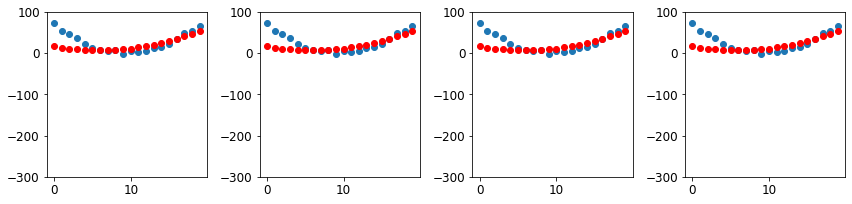

In [218]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

#### Step 7: stop

### Summarizing Gradient Descent

In [ ]:
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

## The MNIST Loss Function

In [219]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)  #"view" is basically a reshape

In [220]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)  #unsqueeze will add a null column, 
#e.g. instead of size 12396 it will be [12396,1]
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [221]:
dset = list(zip(train_x,train_y))  # this is a tuple and can index into using square brackets returning the tuple. 
#"Zip" combines each element at each index
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [222]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

In [223]:
def init_params(size, var=1.0): return (torch.randn(size)*var).requires_grad_()

In [224]:
weights = init_params((28*28,1))

In [225]:
bias = init_params(1)

In [226]:
(train_x[0]*weights.T).sum() + bias #"T" is transpose

tensor([11.6307], grad_fn=<AddBackward0>)

In [227]:
def linear1(xb): return xb@weights + bias #"@" matrix muliply, will use GPU
preds = linear1(train_x)
preds

tensor([[11.6307],
        [-2.0822],
        [11.1118],
        ...,
        [ 1.8331],
        [11.6307],
        [ 5.2742]], grad_fn=<AddBackward0>)

In [228]:
corrects = (preds>0.0).float() == train_y  #greater than 0 is a 3 and less tham is 7,
#Then check if it matches trainiing set converting to T/F.  
corrects

tensor([[ True],
        [False],
        [ True],
        ...,
        [False],
        [False],
        [False]])

In [229]:
corrects.float().mean().item()  # check accuracy

0.5803484916687012

In [233]:
with torch.no_grad():
    weights[0] *= 1.0001  # modify weight to see change in the prediction accuracy

In [234]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()  #here the grad is 0 so no immprovement is made. 
#changing a single pixel a little bit does not change the prediction and therefore the accuracy.  Need a non zero grad, loss

0.5803484916687012

In [235]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

In [236]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [237]:
torch.where(trgts==1, 1-prds, prds) # good predictions results in smaller results

tensor([0.1000, 0.4000, 0.8000])

In [238]:
mnist_loss(prds,trgts) # good predictions results in a smaller result, now predictions are considered in the loss

tensor(0.4333)

In [239]:
mnist_loss(tensor([0.9, 0.4, 0.8]),trgts)

tensor(0.2333)

### Sigmoid

In [240]:
def sigmoid(x): return 1/(1+torch.exp(-x))  # ensure predictions are between 0 and 1

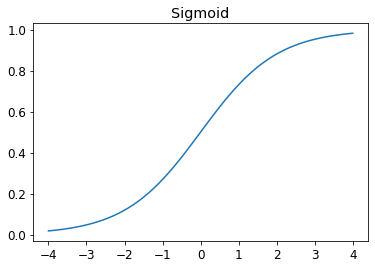

In [241]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

In [242]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

### SGD and Mini-Batches

In [243]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

In [244]:
ds = L(enumerate(string.ascii_lowercase))  # now we can do this with tuples
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [245]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([17, 18, 10, 22,  8, 14]), ('r', 's', 'k', 'w', 'i', 'o')),
 (tensor([20, 15,  9, 13, 21, 12]), ('u', 'p', 'j', 'n', 'v', 'm')),
 (tensor([ 7, 25,  6,  5, 11, 23]), ('h', 'z', 'g', 'f', 'l', 'x')),
 (tensor([ 1,  3,  0, 24, 19, 16]), ('b', 'd', 'a', 'y', 't', 'q')),
 (tensor([2, 4]), ('c', 'e'))]

## Putting It All Together

In [246]:
weights = init_params((28*28,1))
bias = init_params(1)

In [247]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)  #"first" grabs the first index from the data loader iterator
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [248]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [249]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [252]:
linear1??

In [250]:
preds = linear1(batch)
preds

tensor([[ -7.2146],
        [ -8.6773],
        [ -7.7675],
        [-15.9637]], grad_fn=<AddBackward0>)

In [253]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.9997, grad_fn=<MeanBackward0>)

In [254]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad  # every weight, length 784, has  agradient

(torch.Size([784, 1]), tensor(-4.7462e-05), tensor([-0.0003]))

In [255]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [256]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-9.4924e-05), tensor([-0.0007]))

In [259]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad 
#calling again the grads have changed and they should not.  
#this is due to ".grad" actually adding the gradients of loss to the gradients stroed

(tensor(-4.7462e-05), tensor([-0.0003]))

In [258]:
weights.grad.zero_()
bias.grad.zero_();

In [260]:
def train_epoch(model, lr, params):  #basic SGD loop
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [261]:
(preds>0.0).float() == train_y[:4]

tensor([[False],
        [False],
        [False],
        [False]])

In [262]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [263]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.)

In [264]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [265]:
validate_epoch(linear1)

0.473

In [266]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.642

In [267]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.8359 0.8945 0.9243 0.9404 0.9492 0.955 0.959 0.96 0.9614 0.9634 0.9644 0.9644 0.9663 0.9692 0.9707 0.9717 0.9717 0.9722 0.9722 0.9727 

### Creating an Optimizer

In [268]:
linear_model = nn.Linear(28*28,1)  # replaces our linear1(x@w +b) function, add includes initializations

In [269]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [270]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

In [271]:
opt = BasicOptim(linear_model.parameters(), lr)

In [272]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [273]:
validate_epoch(linear_model)

0.1465

In [274]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [275]:
train_model(linear_model, 20)

0.4932 0.8618 0.8149 0.9082 0.9326 0.9463 0.956 0.9624 0.9653 0.9673 0.9682 0.9712 0.9736 0.9751 0.9761 0.977 0.9775 0.978 0.9785 0.979 

In [276]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.8105 0.8452 0.9121 0.9346 0.9482 0.9565 0.9629 0.9663 0.9673 0.9697 0.9712 0.9731 0.9741 0.9761 0.977 0.9775 0.978 0.9785 0.9785 

In [277]:
dls = DataLoaders(dl, valid_dl)

In [278]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [280]:
learn.fit(100, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.016519,0.036250,0.968597,00:00
1,0.016224,0.034144,0.971050,00:00
2,0.015916,0.032429,0.973503,00:00
3,0.015616,0.031000,0.974975,00:00
4,0.015339,0.029793,0.975957,00:00
5,0.015091,0.028761,0.976448,00:00
6,0.014870,0.027872,0.977429,00:00
7,0.014674,0.027099,0.978410,00:00
8,0.014499,0.026422,0.978410,00:00
9,0.014340,0.025825,0.978410,00:00


## Adding a Nonlinearity

In [281]:
def simple_net(xb):  # two layer neural net, need RElu or similar (non-linearity) we can nolonger create a single linear function
    #allowing us to approximate in non-linnearr function
    res = xb@w1 + b1
    res = res.max(tensor(0.0))  #RELU, recitfied linear until, takes max of negative and 0 replacing negatives with 0s
    res = res@w2 + b2
    return res

In [283]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

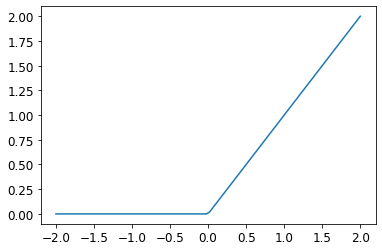

In [284]:
plot_function(F.relu)

In [285]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [286]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [293]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.009022,0.016420,0.985770,00:00
1,0.009005,0.016410,0.985770,00:00
2,0.008985,0.016400,0.985770,00:00
3,0.008964,0.016390,0.985770,00:00
4,0.008942,0.016380,0.985770,00:00
5,0.008919,0.016370,0.985770,00:00
6,0.008896,0.016361,0.985770,00:00
7,0.008873,0.016352,0.985770,00:00
8,0.008851,0.016342,0.985770,00:00
9,0.008828,0.016333,0.985770,00:00


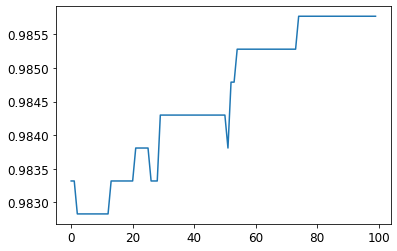

In [289]:
plt.plot(L(learn.recorder.values).itemgot(2)); #item 2 is batch accuracy, look in table above

In [292]:
learn.recorder.values[-1][2]

0.9857703447341919

In [294]:
m=learn.model
m

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

In [297]:
w,b=m[0].parameters()
w.shape

torch.Size([30, 784])

<AxesSubplot:>

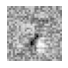

In [301]:
show_image(w[10].view(28,28))

### Going Deeper

In [303]:
path

Path('.')

In [308]:
def loss_aux(input, target, **kwargs):
  target = target.long()
  return F.cross_entropy(input, target, **kwargs)

In [309]:
dls = ImageDataLoaders.from_folder(path,num_workers=0)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=loss_aux, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.086860,0.016442,0.995093,00:30


## Jargon Recap

## Questionnaire

1. How is a grayscale image represented on a computer? How about a color image?
1. How are the files and folders in the `MNIST_SAMPLE` dataset structured? Why?
1. Explain how the "pixel similarity" approach to classifying digits works.
1. What is a list comprehension? Create one now that selects odd numbers from a list and doubles them.
1. What is a "rank-3 tensor"?
1. What is the difference between tensor rank and shape? How do you get the rank from the shape?
1. What are RMSE and L1 norm?
1. How can you apply a calculation on thousands of numbers at once, many thousands of times faster than a Python loop?
1. Create a 3×3 tensor or array containing the numbers from 1 to 9. Double it. Select the bottom-right four numbers.
1. What is broadcasting?
1. Are metrics generally calculated using the training set, or the validation set? Why?
1. What is SGD?
1. Why does SGD use mini-batches?
1. What are the seven steps in SGD for machine learning?
1. How do we initialize the weights in a model?
1. What is "loss"?
1. Why can't we always use a high learning rate?
1. What is a "gradient"?
1. Do you need to know how to calculate gradients yourself?
1. Why can't we use accuracy as a loss function?
1. Draw the sigmoid function. What is special about its shape?
1. What is the difference between a loss function and a metric?
1. What is the function to calculate new weights using a learning rate?
1. What does the `DataLoader` class do?
1. Write pseudocode showing the basic steps taken in each epoch for SGD.
1. Create a function that, if passed two arguments `[1,2,3,4]` and `'abcd'`, returns `[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]`. What is special about that output data structure?
1. What does `view` do in PyTorch?
1. What are the "bias" parameters in a neural network? Why do we need them?
1. What does the `@` operator do in Python?
1. What does the `backward` method do?
1. Why do we have to zero the gradients?
1. What information do we have to pass to `Learner`?
1. Show Python or pseudocode for the basic steps of a training loop.
1. What is "ReLU"? Draw a plot of it for values from `-2` to `+2`.
1. What is an "activation function"?
1. What's the difference between `F.relu` and `nn.ReLU`?
1. The universal approximation theorem shows that any function can be approximated as closely as needed using just one nonlinearity. So why do we normally use more?

### Further Research

1. Create your own implementation of `Learner` from scratch, based on the training loop shown in this chapter.
1. Complete all the steps in this chapter using the full MNIST datasets (that is, for all digits, not just 3s and 7s). This is a significant project and will take you quite a bit of time to complete! You'll need to do some of your own research to figure out how to overcome some obstacles you'll meet on the way.